In [ ]:
eta = 0.1
optimizer_lr = 1e-5 # try 1e-5 from dim=2

dim = 2
n_center = 5
l = 5

num_layers = 30
width = 256

n_max_mirror_iterations= 10       # num mirror steps (for the frist and second)
n_max_iterations=6000        # max inner steps

num_samples = 10000         # number of theta generated for training
num_samples_test =  8192 # samples to estimate KL
import math
verbose = True
set_seed = 114540 # seed not used.
exp_number = 0 # [0, 1, 2, 3, 4]
pretrain_factor = 100

outer_lr_final_factor = 1e0
outer_eta_final_factor = 1e0
import math
outer_lr_factor = pow(math.e, math.log(outer_lr_final_factor)/n_max_mirror_iterations)
outer_eta_factor = pow(math.e, math.log(outer_eta_final_factor)/n_max_mirror_iterations)

In [ ]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 837.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87245 sha256=2596f37c7dcb0b1e8e825620d01b45f9597c79906140ccba913fcf2d8b7f1715
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [ ]:
import numpy as np
import zlib
from multipledispatch import dispatch
import torch
import random

class RandomManager:
    '''
    Manage random using crc32 checksum for seeds generating
    '''

    @staticmethod
    def _get_crc32_seed(_str):
        _bstr = str.encode(_str)
        return zlib.crc32(_bstr)

    def _make_str(self, *args):
        return '@'.join(map(str, args))

    def __init__(self, *args):
        self._str = self._make_str(*args)

    def get_seed(self, *postfixes):
        _str = self._str + self._make_str(*postfixes)
        return self._get_crc32_seed(_str)

    def seed_random(self, *postfixes):
        rnd_postfixes = ('random',) + postfixes
        random.seed(self.get_seed(*rnd_postfixes))
        return self

    def seed_torch(self, *postfixes):
        torch_postfixes = ('pytorch',) + postfixes
        torch.manual_seed(self.get_seed(*torch_postfixes))
        return self

    def seed_numpy(self, *postfixes):
        np_postfixes = ('numpy',) + postfixes
        np.random.seed(self.get_seed(*np_postfixes))
        return self

    def seed(self, *postfixes):
        return self.seed_random(*postfixes).seed_numpy(*postfixes).seed_torch(*postfixes)

def get_random_manager(*args):
    return RandomManager(*args)

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch.nn.functional as F
import torch.distributions as TD
import pandas as pd
import seaborn as sb
import torch.nn as nn
import shutil
import gc
import copy
import time
from scipy.optimize import linear_sum_assignment

In [ ]:
torch.manual_seed(114514)
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [ ]:
def random_centers_distrib_generator(n, n_rand, target_span, std, device='cpu', dtype=torch.float32):
    centers_sample_distrib = TD.Uniform(-target_span, target_span)
    centers = centers_sample_distrib.sample((n_rand, n)).to(device, dtype)
    comp = TD.Independent(TD.Normal(centers, torch.tensor([std,]).to(device, dtype)), 1)
    mix = TD.Categorical(torch.ones(n_rand,).to(device, dtype))
    target = TD.MixtureSameFamily(mix, comp)
    return target

def random_project(input_data, p = 2, random_seed = 114514):
  import torch
# input_data n by m
# random_matrix m by p
# random_projected = 1/sqrt(p) * input_data %*% random_matrix
  torch.manual_seed(random_seed)
  m = input_data.shape[1]
  random_mx = torch.randn((m, p))
  projected = (1/torch.sqrt(torch.tensor(p)))*torch.matmul(input_data, random_mx)
  return projected

def plot_two_data(target_dist, model_transform):
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sb

  df_1 = pd.DataFrame(random_project(target_dist)).astype("float")
  df_2 =  pd.DataFrame(random_project(model_transform)).astype("float")

  df_1["type"] = "target dist"
  df_2["type"] = "model transform"
  df_all = pd.concat([df_1, df_2], ignore_index=True)
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)
  sns_plot = sb.jointplot(data=df_all, x="dim_0", y="dim_1", hue="type", kind="kde")
  return sns_plot

<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


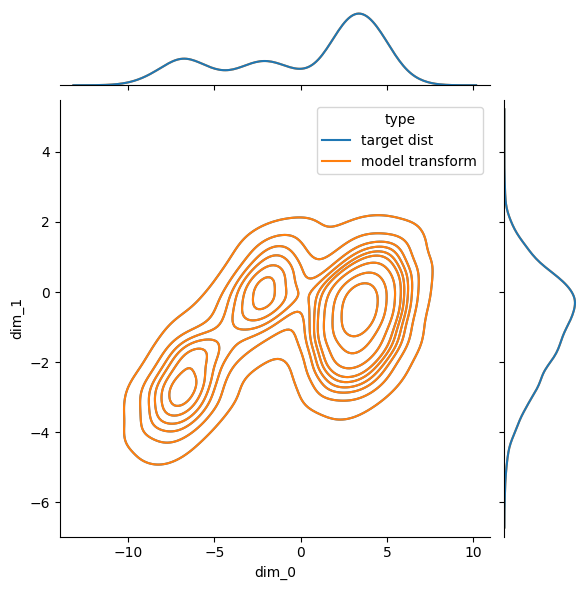

In [ ]:
r_m = get_random_manager('uran', dim, exp_number)
r_m.seed()

stationary_dist = random_centers_distrib_generator(n = dim, n_rand = n_center, target_span = l, std = 1, device=device, dtype=torch.float32)
target_samples = stationary_dist.sample((5000,))
plot_two_data(target_samples.cpu().detach(), target_samples.cpu().detach())

In [ ]:
kld1_hist = np.array([])
kld2_hist = np.array([])



trail_num = exp_number
torch.manual_seed(527)

# target_pretrain = TD.MultivariateNormal(
#     torch.zeros(dim).to(device), pretrain_factor * torch.eye(dim).to(device))
target_pretrain = TD.Uniform(-10, 10)
# Define 2D Gaussian base distribution
base = nf.distributions.DiagGaussian(dim, trainable=False)
# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(dim, mode='swap'))

# for i in range(num_layers):
#     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
#     flows += [nf.flows.LULinearPermute(dim)]

# Construct flow model
model = nf.NormalizingFlow(base, flows).to(device)
optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(100)):
    optimizer1.zero_grad()

    # Get training samples
    # x = target_pretrain.sample((num_samples,)).to(device)
    x = target_pretrain.sample((num_samples, dim)).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer1.step()

    if it % 100 == 99:
      clear_output(wait=True)
      print('Loss:', loss.item())


100%|██████████| 100/100 [00:09<00:00, 10.11it/s]

Loss: 6.143848419189453


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


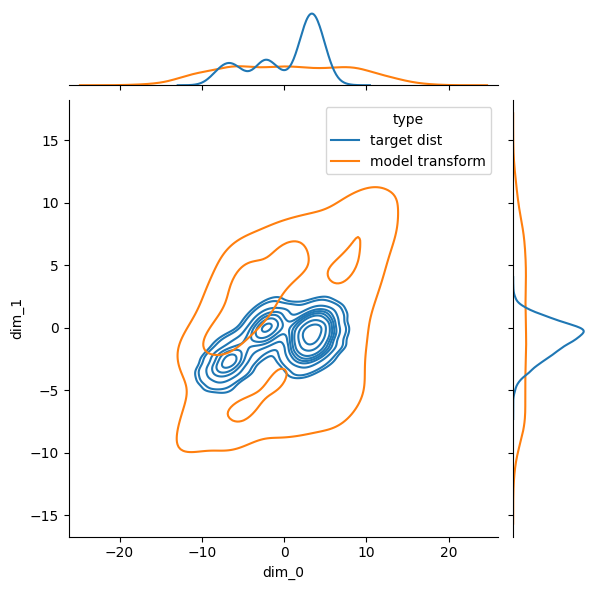

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

  2%|▏         | 100/6000 [00:28<30:13,  3.25it/s]

trail: 0 m step: 0 Loss: 9.53652811050415  L_n: 5.860776424407959  kld: 0.36757516860961914 KLD1: 5.889010906219482 KLD2: 1.5031237602233887


  3%|▎         | 200/6000 [00:56<30:30,  3.17it/s]

trail: 0 m step: 0 Loss: 9.244358539581299  L_n: 5.389702320098877  kld: 0.3854656219482422 KLD1: 5.176596641540527 KLD2: 1.3412789106369019


  5%|▌         | 300/6000 [01:26<30:42,  3.09it/s]

trail: 0 m step: 0 Loss: 8.8309645652771  L_n: 4.985597133636475  kld: 0.3845367431640625 KLD1: 5.076943397521973 KLD2: 1.2900757789611816


  7%|▋         | 400/6000 [01:56<30:39,  3.04it/s]

trail: 0 m step: 0 Loss: 8.837475299835205  L_n: 4.907054424285889  kld: 0.39304208755493164 KLD1: 4.8947367668151855 KLD2: 1.2489752769470215


  8%|▊         | 500/6000 [02:25<29:34,  3.10it/s]

trail: 0 m step: 0 Loss: 8.863523483276367  L_n: 4.904959678649902  kld: 0.3958563804626465 KLD1: 4.857669353485107 KLD2: 1.2196135520935059


 10%|█         | 600/6000 [02:55<29:13,  3.08it/s]

trail: 0 m step: 0 Loss: 8.922858715057373  L_n: 4.811778545379639  kld: 0.41110801696777344 KLD1: 4.66840124130249 KLD2: 1.1818718910217285


 12%|█▏        | 700/6000 [03:24<28:30,  3.10it/s]

trail: 0 m step: 0 Loss: 8.635843753814697  L_n: 4.829638957977295  kld: 0.38062047958374023 KLD1: 4.986311435699463 KLD2: 1.1818927526474


 13%|█▎        | 800/6000 [03:53<28:07,  3.08it/s]

trail: 0 m step: 0 Loss: 8.828516006469727  L_n: 4.820594787597656  kld: 0.40079212188720703 KLD1: 4.744564056396484 KLD2: 1.208796501159668


 15%|█▌        | 900/6000 [04:23<27:35,  3.08it/s]

trail: 0 m step: 0 Loss: 8.803478240966797  L_n: 4.784322738647461  kld: 0.4019155502319336 KLD1: 4.764564037322998 KLD2: 1.2080919742584229


 17%|█▋        | 1000/6000 [04:53<27:02,  3.08it/s]

trail: 0 m step: 0 Loss: 8.89457368850708  L_n: 4.758101940155029  kld: 0.4136471748352051 KLD1: 4.631680965423584 KLD2: 1.1883848905563354


 18%|█▊        | 1100/6000 [05:22<26:31,  3.08it/s]

trail: 0 m step: 0 Loss: 8.747644901275635  L_n: 4.7359232902526855  kld: 0.4011721611022949 KLD1: 4.739589691162109 KLD2: 1.1945958137512207


 20%|██        | 1200/6000 [05:51<26:01,  3.07it/s]

trail: 0 m step: 0 Loss: 8.686226844787598  L_n: 4.742053985595703  kld: 0.39441728591918945 KLD1: 4.801584243774414 KLD2: 1.17637300491333


 22%|██▏       | 1300/6000 [06:21<25:22,  3.09it/s]

trail: 0 m step: 0 Loss: 8.536188125610352  L_n: 4.599520683288574  kld: 0.39366674423217773 KLD1: 4.823418140411377 KLD2: 1.1940001249313354


 23%|██▎       | 1400/6000 [06:50<24:53,  3.08it/s]

trail: 0 m step: 0 Loss: 8.634432792663574  L_n: 4.714273452758789  kld: 0.3920159339904785 KLD1: 4.810963153839111 KLD2: 1.1693884134292603


 25%|██▌       | 1500/6000 [07:19<24:29,  3.06it/s]

trail: 0 m step: 0 Loss: 8.739566326141357  L_n: 4.714250087738037  kld: 0.40253162384033203 KLD1: 4.711720943450928 KLD2: 1.1776396036148071


 27%|██▋       | 1600/6000 [07:49<23:48,  3.08it/s]

trail: 0 m step: 0 Loss: 8.719023704528809  L_n: 4.589089393615723  kld: 0.4129934310913086 KLD1: 4.60621452331543 KLD2: 1.1756285429000854


 28%|██▊       | 1700/6000 [08:18<23:21,  3.07it/s]

trail: 0 m step: 0 Loss: 8.682218074798584  L_n: 4.675770282745361  kld: 0.40064477920532227 KLD1: 4.729799270629883 KLD2: 1.1933239698410034


 30%|███       | 1800/6000 [08:48<22:43,  3.08it/s]

trail: 0 m step: 0 Loss: 8.818645000457764  L_n: 4.762105464935303  kld: 0.4056539535522461 KLD1: 4.6954169273376465 KLD2: 1.1718168258666992


 32%|███▏      | 1900/6000 [09:17<22:15,  3.07it/s]

trail: 0 m step: 0 Loss: 8.841081619262695  L_n: 4.832383155822754  kld: 0.40086984634399414 KLD1: 4.722169876098633 KLD2: 1.1771576404571533


 33%|███▎      | 2000/6000 [09:46<21:41,  3.07it/s]

trail: 0 m step: 0 Loss: 8.767106533050537  L_n: 4.710123538970947  kld: 0.405698299407959 KLD1: 4.664410591125488 KLD2: 1.169245719909668


 35%|███▌      | 2100/6000 [10:16<21:04,  3.09it/s]

trail: 0 m step: 0 Loss: 8.641860485076904  L_n: 4.722812175750732  kld: 0.3919048309326172 KLD1: 4.8026123046875 KLD2: 1.1652082204818726


 37%|███▋      | 2200/6000 [10:45<20:35,  3.08it/s]

trail: 0 m step: 0 Loss: 8.653650283813477  L_n: 4.602608680725098  kld: 0.4051041603088379 KLD1: 4.667599678039551 KLD2: 1.1879884004592896


 38%|███▊      | 2300/6000 [11:15<20:01,  3.08it/s]

trail: 0 m step: 0 Loss: 8.849321365356445  L_n: 4.806705474853516  kld: 0.40426158905029297 KLD1: 4.660172462463379 KLD2: 1.1891570091247559


 40%|████      | 2400/6000 [11:44<19:31,  3.07it/s]

trail: 0 m step: 0 Loss: 8.65897512435913  L_n: 4.769838809967041  kld: 0.388913631439209 KLD1: 4.818789958953857 KLD2: 1.1944143772125244


 42%|████▏     | 2500/6000 [12:14<18:57,  3.08it/s]

trail: 0 m step: 0 Loss: 8.8437180519104  L_n: 4.70123815536499  kld: 0.414247989654541 KLD1: 4.579894065856934 KLD2: 1.1741588115692139


 43%|████▎     | 2600/6000 [12:43<18:26,  3.07it/s]

trail: 0 m step: 0 Loss: 8.62873888015747  L_n: 4.621618747711182  kld: 0.4007120132446289 KLD1: 4.704753875732422 KLD2: 1.1728911399841309


 45%|████▌     | 2700/6000 [13:13<17:54,  3.07it/s]

trail: 0 m step: 0 Loss: 8.659035205841064  L_n: 4.6540751457214355  kld: 0.4004960060119629 KLD1: 4.708056926727295 KLD2: 1.1850554943084717


 47%|████▋     | 2800/6000 [13:42<17:16,  3.09it/s]

trail: 0 m step: 0 Loss: 8.585343837738037  L_n: 4.660263538360596  kld: 0.39250802993774414 KLD1: 4.813528537750244 KLD2: 1.1664083003997803


 48%|████▊     | 2900/6000 [14:12<16:45,  3.08it/s]

trail: 0 m step: 0 Loss: 8.832308292388916  L_n: 4.710618495941162  kld: 0.4121689796447754 KLD1: 4.58494758605957 KLD2: 1.1677289009094238


 50%|█████     | 3000/6000 [14:41<16:12,  3.09it/s]

trail: 0 m step: 0 Loss: 8.691135883331299  L_n: 4.70479154586792  kld: 0.3986344337463379 KLD1: 4.708657264709473 KLD2: 1.1676437854766846


 52%|█████▏    | 3100/6000 [15:10<15:41,  3.08it/s]

trail: 0 m step: 0 Loss: 8.580944061279297  L_n: 4.644162178039551  kld: 0.3936781883239746 KLD1: 4.779397010803223 KLD2: 1.1577414274215698


 53%|█████▎    | 3200/6000 [15:40<15:09,  3.08it/s]

trail: 0 m step: 0 Loss: 8.763991355895996  L_n: 4.754239082336426  kld: 0.40097522735595703 KLD1: 4.70443058013916 KLD2: 1.1831737756729126


 55%|█████▌    | 3300/6000 [16:09<14:39,  3.07it/s]

trail: 0 m step: 0 Loss: 8.658984184265137  L_n: 4.664557456970215  kld: 0.3994426727294922 KLD1: 4.7232184410095215 KLD2: 1.1695104837417603


 57%|█████▋    | 3400/6000 [16:39<14:05,  3.08it/s]

trail: 0 m step: 0 Loss: 8.764411926269531  L_n: 4.75209903717041  kld: 0.4012312889099121 KLD1: 4.67372465133667 KLD2: 1.1628538370132446


 58%|█████▊    | 3500/6000 [17:08<13:34,  3.07it/s]

trail: 0 m step: 0 Loss: 8.712021350860596  L_n: 4.680644512176514  kld: 0.4031376838684082 KLD1: 4.672776222229004 KLD2: 1.183899164199829


 60%|██████    | 3600/6000 [17:37<13:01,  3.07it/s]

trail: 0 m step: 0 Loss: 8.826733112335205  L_n: 4.757161617279053  kld: 0.40695714950561523 KLD1: 4.630607604980469 KLD2: 1.1622204780578613


 62%|██████▏   | 3700/6000 [18:07<12:27,  3.08it/s]

trail: 0 m step: 0 Loss: 8.629359245300293  L_n: 4.623984336853027  kld: 0.40053749084472656 KLD1: 4.716187477111816 KLD2: 1.1749322414398193


 63%|██████▎   | 3800/6000 [18:36<11:56,  3.07it/s]

trail: 0 m step: 0 Loss: 8.669774532318115  L_n: 4.628942012786865  kld: 0.404083251953125 KLD1: 4.662955284118652 KLD2: 1.1576577425003052


 65%|██████▌   | 3900/6000 [19:06<11:23,  3.07it/s]

trail: 0 m step: 0 Loss: 8.781159400939941  L_n: 4.653690338134766  kld: 0.4127469062805176 KLD1: 4.577047348022461 KLD2: 1.1480872631072998


 67%|██████▋   | 4000/6000 [19:35<10:48,  3.09it/s]

trail: 0 m step: 0 Loss: 8.670559883117676  L_n: 4.602709770202637  kld: 0.4067850112915039 KLD1: 4.627373695373535 KLD2: 1.1705431938171387


 68%|██████▊   | 4100/6000 [20:05<10:17,  3.08it/s]

trail: 0 m step: 0 Loss: 8.461321353912354  L_n: 4.552587032318115  kld: 0.39087343215942383 KLD1: 4.789811134338379 KLD2: 1.1846250295639038


 70%|███████   | 4200/6000 [20:34<09:46,  3.07it/s]

trail: 0 m step: 0 Loss: 8.57332992553711  L_n: 4.5776777267456055  kld: 0.3995652198791504 KLD1: 4.710472106933594 KLD2: 1.1700537204742432


 72%|███████▏  | 4300/6000 [21:04<09:12,  3.08it/s]

trail: 0 m step: 0 Loss: 8.657037258148193  L_n: 4.654399394989014  kld: 0.40026378631591797 KLD1: 4.696587562561035 KLD2: 1.1620452404022217


 73%|███████▎  | 4400/6000 [21:33<08:41,  3.07it/s]

trail: 0 m step: 0 Loss: 8.654093742370605  L_n: 4.677734375  kld: 0.39763593673706055 KLD1: 4.7156782150268555 KLD2: 1.17013418674469


 75%|███████▌  | 4500/6000 [22:03<08:07,  3.08it/s]

trail: 0 m step: 0 Loss: 8.67383337020874  L_n: 4.712818622589111  kld: 0.3961014747619629 KLD1: 4.757822513580322 KLD2: 1.165949821472168


 77%|███████▋  | 4600/6000 [22:32<07:33,  3.09it/s]

trail: 0 m step: 0 Loss: 8.706298351287842  L_n: 4.661679744720459  kld: 0.4044618606567383 KLD1: 4.634573459625244 KLD2: 1.1637579202651978


 78%|███████▊  | 4700/6000 [23:02<07:04,  3.06it/s]

trail: 0 m step: 0 Loss: 8.564092636108398  L_n: 4.6795196533203125  kld: 0.3884572982788086 KLD1: 4.817343711853027 KLD2: 1.1782337427139282


 80%|████████  | 4800/6000 [23:31<06:30,  3.08it/s]

trail: 0 m step: 0 Loss: 8.802404880523682  L_n: 4.660749912261963  kld: 0.4141654968261719 KLD1: 4.55750846862793 KLD2: 1.1656008958816528


 82%|████████▏ | 4900/6000 [24:00<05:56,  3.08it/s]

trail: 0 m step: 0 Loss: 8.651859283447266  L_n: 4.639036178588867  kld: 0.40128231048583984 KLD1: 4.687844276428223 KLD2: 1.1734952926635742


 83%|████████▎ | 5000/6000 [24:30<05:24,  3.08it/s]

trail: 0 m step: 0 Loss: 8.59708833694458  L_n: 4.595590114593506  kld: 0.4001498222351074 KLD1: 4.702261924743652 KLD2: 1.1681325435638428


 85%|████████▌ | 5100/6000 [24:59<04:52,  3.07it/s]

trail: 0 m step: 0 Loss: 8.561395645141602  L_n: 4.587410926818848  kld: 0.3973984718322754 KLD1: 4.727139472961426 KLD2: 1.179769515991211


 87%|████████▋ | 5200/6000 [25:29<04:20,  3.07it/s]

trail: 0 m step: 0 Loss: 8.738637924194336  L_n: 4.715400695800781  kld: 0.40232372283935547 KLD1: 4.669289588928223 KLD2: 1.160151481628418


 88%|████████▊ | 5300/6000 [25:58<03:46,  3.09it/s]

trail: 0 m step: 0 Loss: 8.783034801483154  L_n: 4.809088230133057  kld: 0.39739465713500977 KLD1: 4.710110187530518 KLD2: 1.1720739603042603


 90%|█████████ | 5400/6000 [26:27<03:15,  3.08it/s]

trail: 0 m step: 0 Loss: 8.500945568084717  L_n: 4.580471515655518  kld: 0.3920474052429199 KLD1: 4.772581577301025 KLD2: 1.1742079257965088


 92%|█████████▏| 5500/6000 [26:57<02:42,  3.08it/s]

trail: 0 m step: 0 Loss: 8.806950569152832  L_n: 4.765707969665527  kld: 0.40412425994873047 KLD1: 4.661149978637695 KLD2: 1.163420557975769


 93%|█████████▎| 5600/6000 [27:26<02:09,  3.08it/s]

trail: 0 m step: 0 Loss: 8.542949676513672  L_n: 4.540879249572754  kld: 0.4002070426940918 KLD1: 4.705142974853516 KLD2: 1.1687641143798828


 95%|█████████▌| 5700/6000 [27:56<01:37,  3.08it/s]

trail: 0 m step: 0 Loss: 8.605671405792236  L_n: 4.558749675750732  kld: 0.4046921730041504 KLD1: 4.655739784240723 KLD2: 1.1806855201721191


 97%|█████████▋| 5800/6000 [28:25<01:04,  3.08it/s]

trail: 0 m step: 0 Loss: 8.704405307769775  L_n: 4.620147228240967  kld: 0.40842580795288086 KLD1: 4.608466148376465 KLD2: 1.1687846183776855


 98%|█████████▊| 5900/6000 [28:55<00:32,  3.09it/s]

trail: 0 m step: 0 Loss: 8.561033725738525  L_n: 4.571775913238525  kld: 0.39892578125 KLD1: 4.701534271240234 KLD2: 1.1695854663848877


100%|██████████| 6000/6000 [29:24<00:00,  3.40it/s]

trail: 0 m step: 0 Loss: 8.529226303100586  L_n: 4.567462921142578  kld: 0.3961763381958008 KLD1: 4.731338024139404 KLD2: 1.168020248413086



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


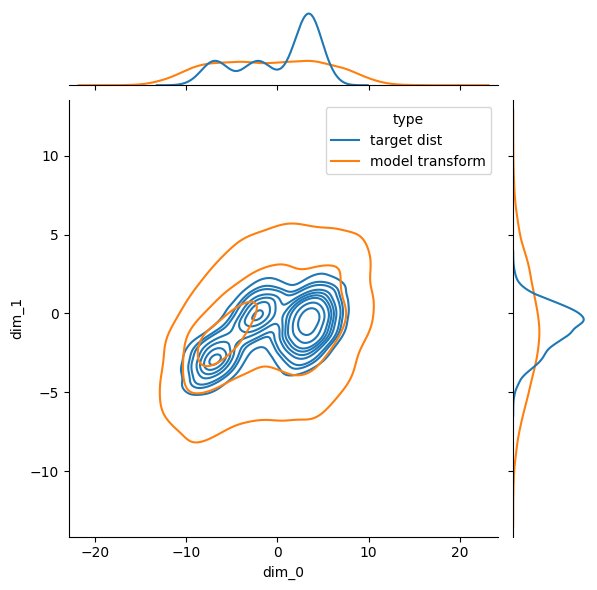

trail: 0 m step: 0 kl_test: 4.718952655792236


  2%|▏         | 100/6000 [00:29<32:25,  3.03it/s]

trail: 0 m step: 1 Loss: 3.2201662063598633  L_n: 2.3210086822509766  kld: 0.08991575241088867 KLD1: 2.3436832427978516 KLD2: 0.8639453053474426


  3%|▎         | 200/6000 [00:59<31:15,  3.09it/s]

trail: 0 m step: 1 Loss: 3.3340530395507812  L_n: 2.352397918701172  kld: 0.09816551208496094 KLD1: 2.233574628829956 KLD2: 0.8125653862953186


  5%|▌         | 300/6000 [01:28<30:44,  3.09it/s]

trail: 0 m step: 1 Loss: 3.2071189880371094  L_n: 2.2522144317626953  kld: 0.0954904556274414 KLD1: 2.271543264389038 KLD2: 0.827244222164154


  7%|▋         | 400/6000 [01:57<30:22,  3.07it/s]

trail: 0 m step: 1 Loss: 3.234614372253418  L_n: 2.2747983932495117  kld: 0.09598159790039062 KLD1: 2.2667524814605713 KLD2: 0.8258447051048279


  8%|▊         | 500/6000 [02:27<29:48,  3.08it/s]

trail: 0 m step: 1 Loss: 3.2513985633850098  L_n: 2.272108554840088  kld: 0.09792900085449219 KLD1: 2.2246041297912598 KLD2: 0.8149255514144897


 10%|█         | 600/6000 [02:56<29:09,  3.09it/s]

trail: 0 m step: 1 Loss: 3.2621569633483887  L_n: 2.245201587677002  kld: 0.10169553756713867 KLD1: 2.1809797286987305 KLD2: 0.7872936129570007


 12%|█▏        | 700/6000 [03:26<28:32,  3.09it/s]

trail: 0 m step: 1 Loss: 3.1116209030151367  L_n: 2.243000030517578  kld: 0.08686208724975586 KLD1: 2.305137872695923 KLD2: 0.7895430326461792


 13%|█▎        | 800/6000 [03:55<28:05,  3.08it/s]

trail: 0 m step: 1 Loss: 3.205685615539551  L_n: 2.2552108764648438  kld: 0.0950474739074707 KLD1: 2.232476234436035 KLD2: 0.8178508877754211


 15%|█▌        | 900/6000 [04:25<27:36,  3.08it/s]

trail: 0 m step: 1 Loss: 3.186953544616699  L_n: 2.21051025390625  kld: 0.09764432907104492 KLD1: 2.2113406658172607 KLD2: 0.8147237300872803


 17%|█▋        | 1000/6000 [04:54<27:11,  3.07it/s]

trail: 0 m step: 1 Loss: 3.254371166229248  L_n: 2.224998950958252  kld: 0.10293722152709961 KLD1: 2.1513831615448 KLD2: 0.8002544641494751


 18%|█▊        | 1100/6000 [05:24<26:38,  3.06it/s]

trail: 0 m step: 1 Loss: 3.1887669563293457  L_n: 2.183713436126709  kld: 0.10050535202026367 KLD1: 2.184446096420288 KLD2: 0.7993404269218445


 20%|██        | 1200/6000 [05:53<26:12,  3.05it/s]

trail: 0 m step: 1 Loss: 3.151296615600586  L_n: 2.179612159729004  kld: 0.0971684455871582 KLD1: 2.213871479034424 KLD2: 0.7848065495491028


 22%|██▏       | 1300/6000 [06:23<25:31,  3.07it/s]

trail: 0 m step: 1 Loss: 3.049884796142578  L_n: 2.118025779724121  kld: 0.0931859016418457 KLD1: 2.255772590637207 KLD2: 0.8023024797439575


 23%|██▎       | 1400/6000 [06:53<24:55,  3.08it/s]

trail: 0 m step: 1 Loss: 3.1430788040161133  L_n: 2.1717090606689453  kld: 0.0971369743347168 KLD1: 2.2039802074432373 KLD2: 0.7786428928375244


 25%|██▌       | 1500/6000 [07:22<24:18,  3.09it/s]

trail: 0 m step: 1 Loss: 3.1754894256591797  L_n: 2.187067985534668  kld: 0.09884214401245117 KLD1: 2.1774818897247314 KLD2: 0.7904852628707886


 27%|██▋       | 1600/6000 [07:52<23:50,  3.07it/s]

trail: 0 m step: 1 Loss: 3.1420979499816895  L_n: 2.0947775840759277  kld: 0.10473203659057617 KLD1: 2.1329152584075928 KLD2: 0.7872934341430664


 28%|██▊       | 1700/6000 [08:21<23:14,  3.08it/s]

trail: 0 m step: 1 Loss: 3.165440559387207  L_n: 2.175784111022949  kld: 0.09896564483642578 KLD1: 2.1721088886260986 KLD2: 0.8054783940315247


 30%|███       | 1800/6000 [08:50<22:46,  3.07it/s]

trail: 0 m step: 1 Loss: 3.1950902938842773  L_n: 2.208695411682129  kld: 0.09863948822021484 KLD1: 2.1834802627563477 KLD2: 0.7842013239860535


 32%|███▏      | 1900/6000 [09:20<22:13,  3.07it/s]

trail: 0 m step: 1 Loss: 3.251891613006592  L_n: 2.2765212059020996  kld: 0.09753704071044922 KLD1: 2.187708616256714 KLD2: 0.7886289954185486


 33%|███▎      | 2000/6000 [09:50<21:40,  3.08it/s]

trail: 0 m step: 1 Loss: 3.165614604949951  L_n: 2.1544575691223145  kld: 0.10111570358276367 KLD1: 2.1476151943206787 KLD2: 0.7778562307357788


 35%|███▌      | 2100/6000 [10:19<21:12,  3.06it/s]

trail: 0 m step: 1 Loss: 3.121495246887207  L_n: 2.18142032623291  kld: 0.09400749206542969 KLD1: 2.2239959239959717 KLD2: 0.7754353284835815


 37%|███▋      | 2200/6000 [10:49<20:36,  3.07it/s]

trail: 0 m step: 1 Loss: 3.1124024391174316  L_n: 2.117867946624756  kld: 0.09945344924926758 KLD1: 2.1654789447784424 KLD2: 0.7953284382820129


 38%|███▊      | 2300/6000 [11:18<19:59,  3.08it/s]

trail: 0 m step: 1 Loss: 3.246187210083008  L_n: 2.222231864929199  kld: 0.10239553451538086 KLD1: 2.144657850265503 KLD2: 0.7956256866455078


 40%|████      | 2400/6000 [11:48<19:26,  3.09it/s]

trail: 0 m step: 1 Loss: 3.125035285949707  L_n: 2.2089929580688477  kld: 0.09160423278808594 KLD1: 2.2399368286132812 KLD2: 0.8022709488868713


 42%|████▏     | 2500/6000 [12:18<18:58,  3.07it/s]

trail: 0 m step: 1 Loss: 3.2656655311584473  L_n: 2.1919236183166504  kld: 0.10737419128417969 KLD1: 2.089237928390503 KLD2: 0.7835866212844849


 43%|████▎     | 2600/6000 [12:47<18:21,  3.09it/s]

trail: 0 m step: 1 Loss: 3.129295825958252  L_n: 2.1383090019226074  kld: 0.09909868240356445 KLD1: 2.172477960586548 KLD2: 0.7828103303909302


 45%|████▌     | 2700/6000 [13:16<17:54,  3.07it/s]

trail: 0 m step: 1 Loss: 3.1514062881469727  L_n: 2.164486885070801  kld: 0.09869194030761719 KLD1: 2.1728830337524414 KLD2: 0.7947001457214355


 47%|████▋     | 2800/6000 [13:46<17:21,  3.07it/s]

trail: 0 m step: 1 Loss: 3.112379550933838  L_n: 2.1570029258728027  kld: 0.09553766250610352 KLD1: 2.207810163497925 KLD2: 0.7770524024963379


 48%|████▊     | 2900/6000 [14:15<16:46,  3.08it/s]

trail: 0 m step: 1 Loss: 3.2168145179748535  L_n: 2.178396701812744  kld: 0.10384178161621094 KLD1: 2.1302924156188965 KLD2: 0.7796393036842346


 50%|█████     | 3000/6000 [14:45<16:18,  3.07it/s]

trail: 0 m step: 1 Loss: 3.16058349609375  L_n: 2.1828718185424805  kld: 0.09777116775512695 KLD1: 2.1816964149475098 KLD2: 0.7795348167419434


 52%|█████▏    | 3100/6000 [15:14<15:44,  3.07it/s]

trail: 0 m step: 1 Loss: 3.095102310180664  L_n: 2.1359682083129883  kld: 0.09591341018676758 KLD1: 2.208803176879883 KLD2: 0.7692955732345581


 53%|█████▎    | 3200/6000 [15:44<15:15,  3.06it/s]

trail: 0 m step: 1 Loss: 3.195805549621582  L_n: 2.2072744369506836  kld: 0.09885311126708984 KLD1: 2.174342393875122 KLD2: 0.7947543263435364


 55%|█████▌    | 3300/6000 [16:14<14:53,  3.02it/s]

trail: 0 m step: 1 Loss: 3.146188259124756  L_n: 2.1844935417175293  kld: 0.09616947174072266 KLD1: 2.202265501022339 KLD2: 0.7839345932006836


 57%|█████▋    | 3400/6000 [16:43<14:10,  3.06it/s]

trail: 0 m step: 1 Loss: 3.2068305015563965  L_n: 2.2169642448425293  kld: 0.09898662567138672 KLD1: 2.173152208328247 KLD2: 0.7758979797363281


 58%|█████▊    | 3500/6000 [17:13<13:36,  3.06it/s]

trail: 0 m step: 1 Loss: 3.1879148483276367  L_n: 2.1721372604370117  kld: 0.1015777587890625 KLD1: 2.1446914672851562 KLD2: 0.7932562232017517


 60%|██████    | 3600/6000 [17:42<12:57,  3.09it/s]

trail: 0 m step: 1 Loss: 3.213118076324463  L_n: 2.224076747894287  kld: 0.09890413284301758 KLD1: 2.172220230102539 KLD2: 0.7766838073730469


 62%|██████▏   | 3700/6000 [18:12<12:25,  3.08it/s]

trail: 0 m step: 1 Loss: 3.0997543334960938  L_n: 2.111504554748535  kld: 0.09882497787475586 KLD1: 2.1746609210968018 KLD2: 0.7848997712135315


 63%|██████▎   | 3800/6000 [18:41<11:50,  3.10it/s]

trail: 0 m step: 1 Loss: 3.1583285331726074  L_n: 2.1701788902282715  kld: 0.0988149642944336 KLD1: 2.1741862297058105 KLD2: 0.7736356258392334


 65%|██████▌   | 3900/6000 [19:11<11:24,  3.07it/s]

trail: 0 m step: 1 Loss: 3.1968088150024414  L_n: 2.1716995239257812  kld: 0.10251092910766602 KLD1: 2.143688917160034 KLD2: 0.7666807174682617


 67%|██████▋   | 4000/6000 [19:40<10:52,  3.07it/s]

trail: 0 m step: 1 Loss: 3.164450168609619  L_n: 2.1426167488098145  kld: 0.10218334197998047 KLD1: 2.1362342834472656 KLD2: 0.7844570875167847


 68%|██████▊   | 4100/6000 [20:10<10:21,  3.06it/s]

trail: 0 m step: 1 Loss: 3.0100655555725098  L_n: 2.0925545692443848  kld: 0.0917510986328125 KLD1: 2.2499217987060547 KLD2: 0.7969037890434265


 70%|███████   | 4200/6000 [20:39<09:46,  3.07it/s]

trail: 0 m step: 1 Loss: 3.0923938751220703  L_n: 2.1117591857910156  kld: 0.09806346893310547 KLD1: 2.1754016876220703 KLD2: 0.781070351600647


 72%|███████▏  | 4300/6000 [21:09<09:11,  3.08it/s]

trail: 0 m step: 1 Loss: 3.131916046142578  L_n: 2.1488828659057617  kld: 0.09830331802368164 KLD1: 2.180988311767578 KLD2: 0.7764393091201782


 73%|███████▎  | 4400/6000 [21:39<08:37,  3.09it/s]

trail: 0 m step: 1 Loss: 3.144373893737793  L_n: 2.18203067779541  kld: 0.09623432159423828 KLD1: 2.2003588676452637 KLD2: 0.7833619713783264


 75%|███████▌  | 4500/6000 [22:08<08:08,  3.07it/s]

trail: 0 m step: 1 Loss: 3.1271214485168457  L_n: 2.162508487701416  kld: 0.09646129608154297 KLD1: 2.1967337131500244 KLD2: 0.7767541408538818


 77%|███████▋  | 4600/6000 [22:38<07:32,  3.09it/s]

trail: 0 m step: 1 Loss: 3.156609535217285  L_n: 2.151932716369629  kld: 0.10046768188476562 KLD1: 2.1556410789489746 KLD2: 0.7770524024963379


 78%|███████▊  | 4700/6000 [23:07<07:03,  3.07it/s]

trail: 0 m step: 1 Loss: 3.102293014526367  L_n: 2.1896743774414062  kld: 0.0912618637084961 KLD1: 2.2522830963134766 KLD2: 0.7883731126785278


 80%|████████  | 4800/6000 [23:37<06:28,  3.09it/s]

trail: 0 m step: 1 Loss: 3.210113525390625  L_n: 2.147167205810547  kld: 0.10629463195800781 KLD1: 2.1023061275482178 KLD2: 0.7759654521942139


 82%|████████▏ | 4900/6000 [24:06<05:58,  3.06it/s]

trail: 0 m step: 1 Loss: 3.150907039642334  L_n: 2.1574978828430176  kld: 0.09934091567993164 KLD1: 2.1701371669769287 KLD2: 0.7855632901191711


 83%|████████▎ | 5000/6000 [24:36<05:24,  3.09it/s]

trail: 0 m step: 1 Loss: 3.1260290145874023  L_n: 2.1495094299316406  kld: 0.09765195846557617 KLD1: 2.1849730014801025 KLD2: 0.7842519879341125


 85%|████████▌ | 5100/6000 [25:05<04:52,  3.07it/s]

trail: 0 m step: 1 Loss: 3.0801854133605957  L_n: 2.1205267906188965  kld: 0.09596586227416992 KLD1: 2.200610399246216 KLD2: 0.7903828620910645


 87%|████████▋ | 5200/6000 [25:35<04:21,  3.06it/s]

trail: 0 m step: 1 Loss: 3.190885066986084  L_n: 2.1873764991760254  kld: 0.10035085678100586 KLD1: 2.1599552631378174 KLD2: 0.7731615304946899


 88%|████████▊ | 5300/6000 [26:04<03:47,  3.07it/s]

trail: 0 m step: 1 Loss: 3.2212047576904297  L_n: 2.262204170227051  kld: 0.09590005874633789 KLD1: 2.200425386428833 KLD2: 0.7841976284980774


 90%|█████████ | 5400/6000 [26:34<03:15,  3.07it/s]

trail: 0 m step: 1 Loss: 3.0582118034362793  L_n: 2.132580280303955  kld: 0.09256315231323242 KLD1: 2.2353663444519043 KLD2: 0.7858354449272156


 92%|█████████▏| 5500/6000 [27:03<02:42,  3.07it/s]

trail: 0 m step: 1 Loss: 3.228250026702881  L_n: 2.228389263153076  kld: 0.09998607635498047 KLD1: 2.1605160236358643 KLD2: 0.7751843333244324


 93%|█████████▎| 5600/6000 [27:33<02:09,  3.08it/s]

trail: 0 m step: 1 Loss: 3.0960960388183594  L_n: 2.117917060852051  kld: 0.09781789779663086 KLD1: 2.1811206340789795 KLD2: 0.7809596657752991


 95%|█████████▌| 5700/6000 [28:03<01:38,  3.04it/s]

trail: 0 m step: 1 Loss: 3.116731643676758  L_n: 2.1299314498901367  kld: 0.09868001937866211 KLD1: 2.1696510314941406 KLD2: 0.7931022047996521


 97%|█████████▋| 5800/6000 [28:32<01:04,  3.08it/s]

trail: 0 m step: 1 Loss: 3.157102108001709  L_n: 2.143603801727295  kld: 0.1013498306274414 KLD1: 2.14861798286438 KLD2: 0.7813953161239624


 98%|█████████▊| 5900/6000 [29:02<00:32,  3.05it/s]

trail: 0 m step: 1 Loss: 3.102639675140381  L_n: 2.1144566535949707  kld: 0.09881830215454102 KLD1: 2.1751708984375 KLD2: 0.7806686162948608


100%|██████████| 6000/6000 [29:31<00:00,  3.39it/s]

trail: 0 m step: 1 Loss: 3.069643020629883  L_n: 2.0956363677978516  kld: 0.09740066528320312 KLD1: 2.1883933544158936 KLD2: 0.7784247398376465



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


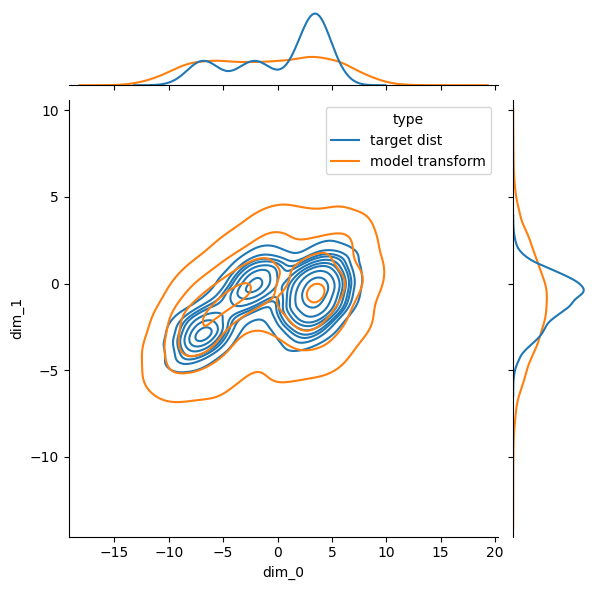

trail: 0 m step: 1 kl_test: 2.1908020973205566


  2%|▏         | 100/6000 [00:29<32:29,  3.03it/s]

trail: 0 m step: 2 Loss: 1.616340160369873  L_n: 1.277442455291748  kld: 0.0338897705078125 KLD1: 1.3012487888336182 KLD2: 0.5997174382209778


  3%|▎         | 200/6000 [00:59<31:31,  3.07it/s]

trail: 0 m step: 2 Loss: 1.7196884155273438  L_n: 1.311692237854004  kld: 0.040799617767333984 KLD1: 1.23392653465271 KLD2: 0.5651790499687195


  5%|▌         | 300/6000 [01:28<30:52,  3.08it/s]

trail: 0 m step: 2 Loss: 1.6259770393371582  L_n: 1.2477402687072754  kld: 0.03782367706298828 KLD1: 1.2700562477111816 KLD2: 0.5861061215400696


  7%|▋         | 400/6000 [01:58<30:36,  3.05it/s]

trail: 0 m step: 2 Loss: 1.6595916748046875  L_n: 1.2668352127075195  kld: 0.0392756462097168 KLD1: 1.2519243955612183 KLD2: 0.584972083568573


  8%|▊         | 500/6000 [02:28<32:05,  2.86it/s]

trail: 0 m step: 2 Loss: 1.6712794303894043  L_n: 1.2701163291931152  kld: 0.040116310119628906 KLD1: 1.232205867767334 KLD2: 0.582504391670227


 10%|█         | 600/6000 [02:57<29:22,  3.06it/s]

trail: 0 m step: 2 Loss: 1.6706676483154297  L_n: 1.264216423034668  kld: 0.04064512252807617 KLD1: 1.2248609066009521 KLD2: 0.5586357116699219


 12%|█▏        | 700/6000 [03:27<29:47,  2.97it/s]

trail: 0 m step: 2 Loss: 1.596287727355957  L_n: 1.2719526290893555  kld: 0.032433509826660156 KLD1: 1.3103034496307373 KLD2: 0.5624911189079285


 13%|█▎        | 800/6000 [03:56<28:23,  3.05it/s]

trail: 0 m step: 2 Loss: 1.6364421844482422  L_n: 1.2618961334228516  kld: 0.03745460510253906 KLD1: 1.2661705017089844 KLD2: 0.5858890414237976


 15%|█▌        | 900/6000 [04:26<27:45,  3.06it/s]

trail: 0 m step: 2 Loss: 1.640091896057129  L_n: 1.2511405944824219  kld: 0.0388951301574707 KLD1: 1.2479712963104248 KLD2: 0.5852285027503967


 17%|█▋        | 1000/6000 [04:55<27:05,  3.08it/s]

trail: 0 m step: 2 Loss: 1.6924805641174316  L_n: 1.2561554908752441  kld: 0.04363250732421875 KLD1: 1.1920043230056763 KLD2: 0.5715343356132507


 18%|█▊        | 1100/6000 [05:25<26:29,  3.08it/s]

trail: 0 m step: 2 Loss: 1.6477761268615723  L_n: 1.2309727668762207  kld: 0.041680335998535156 KLD1: 1.2214109897613525 KLD2: 0.5712915658950806


 20%|██        | 1200/6000 [05:55<26:06,  3.06it/s]

trail: 0 m step: 2 Loss: 1.6258149147033691  L_n: 1.2446074485778809  kld: 0.03812074661254883 KLD1: 1.2563542127609253 KLD2: 0.5613642334938049


 22%|██▏       | 1300/6000 [06:24<25:26,  3.08it/s]

trail: 0 m step: 2 Loss: 1.555253028869629  L_n: 1.1808500289916992  kld: 0.03744029998779297 KLD1: 1.2586450576782227 KLD2: 0.5716208815574646


 23%|██▎       | 1400/6000 [06:53<24:58,  3.07it/s]

trail: 0 m step: 2 Loss: 1.6053762435913086  L_n: 1.2240495681762695  kld: 0.038132667541503906 KLD1: 1.2553259134292603 KLD2: 0.5547080039978027


 25%|██▌       | 1500/6000 [07:23<24:21,  3.08it/s]

trail: 0 m step: 2 Loss: 1.6314506530761719  L_n: 1.2393903732299805  kld: 0.03920602798461914 KLD1: 1.2443549633026123 KLD2: 0.5675449371337891


 27%|██▋       | 1600/6000 [07:52<23:51,  3.07it/s]

trail: 0 m step: 2 Loss: 1.6218619346618652  L_n: 1.188169002532959  kld: 0.043369293212890625 KLD1: 1.2081069946289062 KLD2: 0.5664783120155334


 28%|██▊       | 1700/6000 [08:22<23:23,  3.06it/s]

trail: 0 m step: 2 Loss: 1.6393609046936035  L_n: 1.241807460784912  kld: 0.03975534439086914 KLD1: 1.2352421283721924 KLD2: 0.5814476609230042


 30%|███       | 1800/6000 [08:52<22:54,  3.06it/s]

trail: 0 m step: 2 Loss: 1.659440517425537  L_n: 1.2646002769470215  kld: 0.03948402404785156 KLD1: 1.240964412689209 KLD2: 0.5614116191864014


 32%|███▏      | 1900/6000 [09:21<22:16,  3.07it/s]

trail: 0 m step: 2 Loss: 1.673964023590088  L_n: 1.2950263023376465  kld: 0.03789377212524414 KLD1: 1.2507158517837524 KLD2: 0.5656128525733948


 33%|███▎      | 2000/6000 [09:51<22:08,  3.01it/s]

trail: 0 m step: 2 Loss: 1.6238412857055664  L_n: 1.2231264114379883  kld: 0.04007148742675781 KLD1: 1.2314226627349854 KLD2: 0.556254506111145


 35%|███▌      | 2100/6000 [10:21<21:08,  3.07it/s]

trail: 0 m step: 2 Loss: 1.6009111404418945  L_n: 1.241776466369629  kld: 0.03591346740722656 KLD1: 1.2710305452346802 KLD2: 0.5541952252388


 37%|███▋      | 2200/6000 [10:50<20:35,  3.07it/s]

trail: 0 m step: 2 Loss: 1.5911860466003418  L_n: 1.2049145698547363  kld: 0.03862714767456055 KLD1: 1.2421584129333496 KLD2: 0.5719018578529358


 38%|███▊      | 2300/6000 [11:20<22:32,  2.74it/s]

trail: 0 m step: 2 Loss: 1.6949882507324219  L_n: 1.277665138244629  kld: 0.0417323112487793 KLD1: 1.2155264616012573 KLD2: 0.5735675096511841


 40%|████      | 2400/6000 [11:49<19:33,  3.07it/s]

trail: 0 m step: 2 Loss: 1.6045222282409668  L_n: 1.2695918083190918  kld: 0.0334930419921875 KLD1: 1.2967466115951538 KLD2: 0.5805765390396118


 42%|████▏     | 2500/6000 [12:19<19:00,  3.07it/s]

trail: 0 m step: 2 Loss: 1.7065057754516602  L_n: 1.2636098861694336  kld: 0.044289588928222656 KLD1: 1.1894316673278809 KLD2: 0.563753604888916


 43%|████▎     | 2600/6000 [12:48<18:23,  3.08it/s]

trail: 0 m step: 2 Loss: 1.6175198554992676  L_n: 1.2246060371398926  kld: 0.0392913818359375 KLD1: 1.2405146360397339 KLD2: 0.5621850490570068


 45%|████▌     | 2700/6000 [13:17<17:52,  3.08it/s]

trail: 0 m step: 2 Loss: 1.6245417594909668  L_n: 1.2391953468322754  kld: 0.03853464126586914 KLD1: 1.24661386013031 KLD2: 0.5736969709396362


 47%|████▋     | 2800/6000 [13:47<17:21,  3.07it/s]

trail: 0 m step: 2 Loss: 1.6069731712341309  L_n: 1.2296090126037598  kld: 0.03773641586303711 KLD1: 1.252424716949463 KLD2: 0.5558973550796509


 48%|████▊     | 2900/6000 [14:16<16:49,  3.07it/s]

trail: 0 m step: 2 Loss: 1.664731502532959  L_n: 1.2480521202087402  kld: 0.041667938232421875 KLD1: 1.214856743812561 KLD2: 0.558448851108551


 50%|█████     | 3000/6000 [14:46<16:19,  3.06it/s]

trail: 0 m step: 2 Loss: 1.6258010864257812  L_n: 1.241551399230957  kld: 0.03842496871948242 KLD1: 1.245985507965088 KLD2: 0.5577250123023987


 52%|█████▏    | 3100/6000 [15:15<15:50,  3.05it/s]

trail: 0 m step: 2 Loss: 1.5881333351135254  L_n: 1.2179217338562012  kld: 0.03702116012573242 KLD1: 1.2673814296722412 KLD2: 0.5506967902183533


 53%|█████▎    | 3200/6000 [15:45<15:10,  3.07it/s]

trail: 0 m step: 2 Loss: 1.6599864959716797  L_n: 1.2653179168701172  kld: 0.03946685791015625 KLD1: 1.2377923727035522 KLD2: 0.5725389719009399


 55%|█████▌    | 3300/6000 [16:14<14:41,  3.06it/s]

trail: 0 m step: 2 Loss: 1.6186699867248535  L_n: 1.2454447746276855  kld: 0.0373225212097168 KLD1: 1.2572096586227417 KLD2: 0.5631088018417358


 57%|█████▋    | 3400/6000 [16:44<14:04,  3.08it/s]

trail: 0 m step: 2 Loss: 1.665313720703125  L_n: 1.2793378829956055  kld: 0.03859758377075195 KLD1: 1.2487967014312744 KLD2: 0.5567156672477722


 58%|█████▊    | 3500/6000 [17:13<13:32,  3.08it/s]

trail: 0 m step: 2 Loss: 1.6562328338623047  L_n: 1.2487754821777344  kld: 0.04074573516845703 KLD1: 1.2248327732086182 KLD2: 0.572152316570282


 60%|██████    | 3600/6000 [17:43<12:58,  3.08it/s]

trail: 0 m step: 2 Loss: 1.666264533996582  L_n: 1.281895637512207  kld: 0.0384368896484375 KLD1: 1.247408151626587 KLD2: 0.5576669573783875


 62%|██████▏   | 3700/6000 [18:12<12:27,  3.08it/s]

trail: 0 m step: 2 Loss: 1.5869574546813965  L_n: 1.1953024864196777  kld: 0.039165496826171875 KLD1: 1.239499568939209 KLD2: 0.5638221502304077


 63%|██████▎   | 3800/6000 [18:42<11:57,  3.07it/s]

trail: 0 m step: 2 Loss: 1.630662441253662  L_n: 1.2502226829528809  kld: 0.038043975830078125 KLD1: 1.2531421184539795 KLD2: 0.5564325451850891


 65%|██████▌   | 3900/6000 [19:11<11:22,  3.08it/s]

trail: 0 m step: 2 Loss: 1.6489605903625488  L_n: 1.2460904121398926  kld: 0.040287017822265625 KLD1: 1.2309198379516602 KLD2: 0.5491350293159485


 67%|██████▋   | 4000/6000 [19:41<10:54,  3.06it/s]

trail: 0 m step: 2 Loss: 1.6387114524841309  L_n: 1.2265429496765137  kld: 0.04121685028076172 KLD1: 1.2169889211654663 KLD2: 0.5648936629295349


 68%|██████▊   | 4100/6000 [20:10<10:18,  3.07it/s]

trail: 0 m step: 2 Loss: 1.5300922393798828  L_n: 1.1925582885742188  kld: 0.033753395080566406 KLD1: 1.2975648641586304 KLD2: 0.5753034949302673


 70%|███████   | 4200/6000 [20:40<09:47,  3.07it/s]

trail: 0 m step: 2 Loss: 1.5948286056518555  L_n: 1.2070789337158203  kld: 0.038774967193603516 KLD1: 1.2391088008880615 KLD2: 0.5604754090309143


 72%|███████▏  | 4300/6000 [21:09<09:14,  3.07it/s]

trail: 0 m step: 2 Loss: 1.6114606857299805  L_n: 1.227621078491211  kld: 0.03838396072387695 KLD1: 1.2485734224319458 KLD2: 0.5581285953521729


 73%|███████▎  | 4400/6000 [21:39<08:41,  3.07it/s]

trail: 0 m step: 2 Loss: 1.6204242706298828  L_n: 1.2554054260253906  kld: 0.03650188446044922 KLD1: 1.2655365467071533 KLD2: 0.5644601583480835


 75%|███████▌  | 4500/6000 [22:08<08:06,  3.09it/s]

trail: 0 m step: 2 Loss: 1.5979599952697754  L_n: 1.2282013893127441  kld: 0.036975860595703125 KLD1: 1.2626570463180542 KLD2: 0.5579802393913269


 77%|███████▋  | 4600/6000 [22:38<07:34,  3.08it/s]

trail: 0 m step: 2 Loss: 1.6303191184997559  L_n: 1.2312493324279785  kld: 0.039906978607177734 KLD1: 1.2326323986053467 KLD2: 0.5580220818519592


 78%|███████▊  | 4700/6000 [23:07<07:00,  3.09it/s]

trail: 0 m step: 2 Loss: 1.6024808883666992  L_n: 1.2647371292114258  kld: 0.033774375915527344 KLD1: 1.292588710784912 KLD2: 0.5682266354560852


 80%|████████  | 4800/6000 [23:36<06:31,  3.06it/s]

trail: 0 m step: 2 Loss: 1.6630964279174805  L_n: 1.2266569137573242  kld: 0.043643951416015625 KLD1: 1.1978846788406372 KLD2: 0.5571848154067993


 82%|████████▏ | 4900/6000 [24:06<05:57,  3.07it/s]

trail: 0 m step: 2 Loss: 1.6241364479064941  L_n: 1.237135410308838  kld: 0.038700103759765625 KLD1: 1.2468249797821045 KLD2: 0.566051185131073


 83%|████████▎ | 5000/6000 [24:35<05:24,  3.08it/s]

trail: 0 m step: 2 Loss: 1.61366605758667  L_n: 1.230989933013916  kld: 0.03826761245727539 KLD1: 1.2484482526779175 KLD2: 0.5659207105636597


 85%|████████▌ | 5100/6000 [25:05<04:53,  3.07it/s]

trail: 0 m step: 2 Loss: 1.5786776542663574  L_n: 1.206449031829834  kld: 0.037222862243652344 KLD1: 1.258190631866455 KLD2: 0.5700460076332092


 87%|████████▋ | 5200/6000 [25:34<04:20,  3.08it/s]

trail: 0 m step: 2 Loss: 1.6545848846435547  L_n: 1.2566308975219727  kld: 0.0397953987121582 KLD1: 1.2377009391784668 KLD2: 0.5547703504562378


 88%|████████▊ | 5300/6000 [26:03<03:47,  3.07it/s]

trail: 0 m step: 2 Loss: 1.6713495254516602  L_n: 1.3094730377197266  kld: 0.03618764877319336 KLD1: 1.2690761089324951 KLD2: 0.5660693645477295


 90%|█████████ | 5400/6000 [26:33<03:15,  3.07it/s]

trail: 0 m step: 2 Loss: 1.5621676445007324  L_n: 1.2192931175231934  kld: 0.034287452697753906 KLD1: 1.2898539304733276 KLD2: 0.5684898495674133


 92%|█████████▏| 5500/6000 [27:02<02:43,  3.06it/s]

trail: 0 m step: 2 Loss: 1.672905445098877  L_n: 1.2823233604431152  kld: 0.03905820846557617 KLD1: 1.2400132417678833 KLD2: 0.5573775172233582


 93%|█████████▎| 5600/6000 [27:32<02:09,  3.08it/s]

trail: 0 m step: 2 Loss: 1.5976448059082031  L_n: 1.2126941680908203  kld: 0.03849506378173828 KLD1: 1.244818925857544 KLD2: 0.5619560480117798


 95%|█████████▌| 5700/6000 [28:02<01:37,  3.07it/s]

trail: 0 m step: 2 Loss: 1.6033148765563965  L_n: 1.2152934074401855  kld: 0.038802146911621094 KLD1: 1.2391928434371948 KLD2: 0.5730918049812317


 97%|█████████▋| 5800/6000 [28:31<01:04,  3.08it/s]

trail: 0 m step: 2 Loss: 1.625291347503662  L_n: 1.2246193885803223  kld: 0.040067195892333984 KLD1: 1.2312068939208984 KLD2: 0.5633565187454224


 98%|█████████▊| 5900/6000 [29:01<00:32,  3.07it/s]

trail: 0 m step: 2 Loss: 1.5972356796264648  L_n: 1.208603858947754  kld: 0.038863182067871094 KLD1: 1.244430422782898 KLD2: 0.5619441866874695


100%|██████████| 6000/6000 [29:31<00:00,  3.39it/s]

trail: 0 m step: 2 Loss: 1.5745759010314941  L_n: 1.192305088043213  kld: 0.038227081298828125 KLD1: 1.249829888343811 KLD2: 0.5599249601364136



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


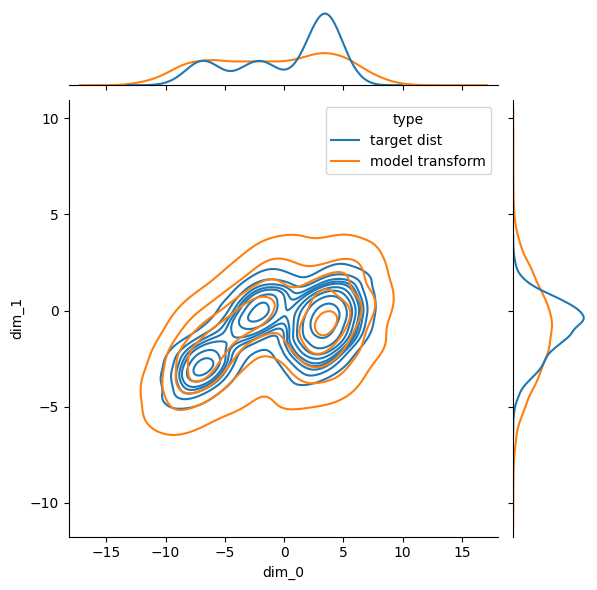

trail: 0 m step: 2 kl_test: 1.260920524597168


  2%|▏         | 100/6000 [00:29<32:24,  3.03it/s]

trail: 0 m step: 3 Loss: 0.9649014472961426  L_n: 0.8049988746643066  kld: 0.015990257263183594 KLD1: 0.8296738266944885 KLD2: 0.4457683861255646


  3%|▎         | 200/6000 [00:58<31:31,  3.07it/s]

trail: 0 m step: 3 Loss: 1.0500946044921875  L_n: 0.849517822265625  kld: 0.02005767822265625 KLD1: 0.7934897541999817 KLD2: 0.4200935959815979


  5%|▌         | 300/6000 [01:28<30:42,  3.09it/s]

trail: 0 m step: 3 Loss: 0.9841341972351074  L_n: 0.7941527366638184  kld: 0.018998146057128906 KLD1: 0.8092719316482544 KLD2: 0.4368424713611603


  7%|▋         | 400/6000 [01:57<30:23,  3.07it/s]

trail: 0 m step: 3 Loss: 1.0113611221313477  L_n: 0.8146419525146484  kld: 0.019671916961669922 KLD1: 0.7999411821365356 KLD2: 0.43833333253860474


  8%|▊         | 500/6000 [02:27<29:54,  3.07it/s]

trail: 0 m step: 3 Loss: 1.014866828918457  L_n: 0.813298225402832  kld: 0.0201568603515625 KLD1: 0.7891058325767517 KLD2: 0.43605780601501465


 10%|█         | 600/6000 [02:56<29:10,  3.08it/s]

trail: 0 m step: 3 Loss: 1.0137147903442383  L_n: 0.8085174560546875  kld: 0.020519733428955078 KLD1: 0.786147952079773 KLD2: 0.41503670811653137


 12%|█▏        | 700/6000 [03:26<28:50,  3.06it/s]

trail: 0 m step: 3 Loss: 0.969996452331543  L_n: 0.819544792175293  kld: 0.015045166015625 KLD1: 0.84332674741745 KLD2: 0.4185551106929779


 13%|█▎        | 800/6000 [03:55<28:14,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9871311187744141  L_n: 0.8065099716186523  kld: 0.018062114715576172 KLD1: 0.8148416876792908 KLD2: 0.43875619769096375


 15%|█▌        | 900/6000 [04:25<27:41,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9993324279785156  L_n: 0.8034048080444336  kld: 0.019592761993408203 KLD1: 0.7975916266441345 KLD2: 0.4397006332874298


 17%|█▋        | 1000/6000 [04:54<27:00,  3.09it/s]

trail: 0 m step: 3 Loss: 1.0325217247009277  L_n: 0.7986664772033691  kld: 0.02338552474975586 KLD1: 0.7550395131111145 KLD2: 0.42678123712539673


 18%|█▊        | 1100/6000 [05:24<26:35,  3.07it/s]

trail: 0 m step: 3 Loss: 1.000098705291748  L_n: 0.7861514091491699  kld: 0.021394729614257812 KLD1: 0.780728280544281 KLD2: 0.427871972322464


 20%|██        | 1200/6000 [05:53<25:56,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9838643074035645  L_n: 0.7963051795959473  kld: 0.01875591278076172 KLD1: 0.8058933615684509 KLD2: 0.41876423358917236


 22%|██▏       | 1300/6000 [06:23<25:29,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9423403739929199  L_n: 0.7518820762634277  kld: 0.01904582977294922 KLD1: 0.8007766604423523 KLD2: 0.42683249711990356


 23%|██▎       | 1400/6000 [06:52<24:48,  3.09it/s]

trail: 0 m step: 3 Loss: 0.97149658203125  L_n: 0.7831935882568359  kld: 0.018830299377441406 KLD1: 0.8061182498931885 KLD2: 0.41258949041366577


 25%|██▌       | 1500/6000 [07:21<24:20,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9848065376281738  L_n: 0.7895464897155762  kld: 0.019526004791259766 KLD1: 0.796566903591156 KLD2: 0.42533397674560547


 27%|██▋       | 1600/6000 [07:51<23:50,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9892287254333496  L_n: 0.7626595497131348  kld: 0.022656917572021484 KLD1: 0.7713783979415894 KLD2: 0.4239407181739807


 28%|██▊       | 1700/6000 [08:20<23:15,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9998559951782227  L_n: 0.7977819442749023  kld: 0.02020740509033203 KLD1: 0.7895991206169128 KLD2: 0.4375026226043701


 30%|███       | 1800/6000 [08:50<22:45,  3.08it/s]

trail: 0 m step: 3 Loss: 1.0144104957580566  L_n: 0.8079209327697754  kld: 0.020648956298828125 KLD1: 0.7866767644882202 KLD2: 0.41814500093460083


 32%|███▏      | 1900/6000 [09:19<22:10,  3.08it/s]

trail: 0 m step: 3 Loss: 1.0203728675842285  L_n: 0.8367571830749512  kld: 0.018361568450927734 KLD1: 0.8040370941162109 KLD2: 0.4247519373893738


 33%|███▎      | 2000/6000 [09:49<21:40,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9819474220275879  L_n: 0.7847228050231934  kld: 0.019722461700439453 KLD1: 0.7935296297073364 KLD2: 0.41613906621932983


 35%|███▌      | 2100/6000 [10:18<20:59,  3.10it/s]

trail: 0 m step: 3 Loss: 0.9677653312683105  L_n: 0.7983403205871582  kld: 0.016942501068115234 KLD1: 0.8198508620262146 KLD2: 0.41391971707344055


 37%|███▋      | 2200/6000 [10:47<20:37,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9605121612548828  L_n: 0.7735538482666016  kld: 0.018695831298828125 KLD1: 0.8005368113517761 KLD2: 0.42926058173179626


 38%|███▊      | 2300/6000 [11:25<20:01,  3.08it/s]

trail: 0 m step: 3 Loss: 1.0407671928405762  L_n: 0.8247599601745605  kld: 0.021600723266601562 KLD1: 0.774948000907898 KLD2: 0.4307584762573242


 40%|████      | 2400/6000 [11:54<19:34,  3.07it/s]

trail: 0 m step: 3 Loss: 0.964271068572998  L_n: 0.8158984184265137  kld: 0.014837265014648438 KLD1: 0.8439733982086182 KLD2: 0.43829578161239624


 42%|████▏     | 2500/6000 [12:24<18:54,  3.09it/s]

trail: 0 m step: 3 Loss: 1.0475983619689941  L_n: 0.8165707588195801  kld: 0.023102760314941406 KLD1: 0.7586899399757385 KLD2: 0.4227297604084015


 43%|████▎     | 2600/6000 [12:54<18:25,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9824647903442383  L_n: 0.7837715148925781  kld: 0.019869327545166016 KLD1: 0.7929819822311401 KLD2: 0.4196505844593048


 45%|████▌     | 2700/6000 [13:23<17:51,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9852089881896973  L_n: 0.7947793006896973  kld: 0.01904296875 KLD1: 0.7995324730873108 KLD2: 0.43027499318122864


 47%|████▋     | 2800/6000 [13:53<17:45,  3.00it/s]

trail: 0 m step: 3 Loss: 0.9741916656494141  L_n: 0.7867374420166016  kld: 0.01874542236328125 KLD1: 0.8025345802307129 KLD2: 0.4149557650089264


 48%|████▊     | 2900/6000 [14:22<16:47,  3.08it/s]

trail: 0 m step: 3 Loss: 1.015021800994873  L_n: 0.802304744720459  kld: 0.021271705627441406 KLD1: 0.7778455018997192 KLD2: 0.4170054495334625


 50%|█████     | 3000/6000 [14:52<16:19,  3.06it/s]

trail: 0 m step: 3 Loss: 0.9821958541870117  L_n: 0.789677619934082  kld: 0.01925182342529297 KLD1: 0.7974603176116943 KLD2: 0.4156710207462311


 52%|█████▏    | 3100/6000 [15:21<15:46,  3.06it/s]

trail: 0 m step: 3 Loss: 0.9581460952758789  L_n: 0.7780447006225586  kld: 0.01801013946533203 KLD1: 0.8161220550537109 KLD2: 0.41053447127342224


 53%|█████▎    | 3200/6000 [15:51<15:07,  3.09it/s]

trail: 0 m step: 3 Loss: 1.0155673027038574  L_n: 0.8158965110778809  kld: 0.019967079162597656 KLD1: 0.7912541031837463 KLD2: 0.4299468994140625


 55%|█████▌    | 3300/6000 [16:20<14:39,  3.07it/s]

trail: 0 m step: 3 Loss: 0.981694221496582  L_n: 0.7997951507568359  kld: 0.01818990707397461 KLD1: 0.8067441582679749 KLD2: 0.421814501285553


 57%|█████▋    | 3400/6000 [16:50<14:04,  3.08it/s]

trail: 0 m step: 3 Loss: 1.0166606903076172  L_n: 0.8247623443603516  kld: 0.019189834594726562 KLD1: 0.8017664551734924 KLD2: 0.4154798090457916


 58%|█████▊    | 3500/6000 [17:19<13:33,  3.07it/s]

trail: 0 m step: 3 Loss: 1.0106110572814941  L_n: 0.8051466941833496  kld: 0.020546436309814453 KLD1: 0.7867648005485535 KLD2: 0.4300888478755951


 60%|██████    | 3600/6000 [17:49<13:08,  3.04it/s]

trail: 0 m step: 3 Loss: 1.0163183212280273  L_n: 0.8252878189086914  kld: 0.019103050231933594 KLD1: 0.7991020083427429 KLD2: 0.41686999797821045


 62%|██████▏   | 3700/6000 [18:18<12:26,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9567384719848633  L_n: 0.7591753005981445  kld: 0.019756317138671875 KLD1: 0.7936370372772217 KLD2: 0.42210349440574646


 63%|██████▎   | 3800/6000 [18:47<11:54,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9924707412719727  L_n: 0.804072380065918  kld: 0.01883983612060547 KLD1: 0.8051335215568542 KLD2: 0.41576600074768066


 65%|██████▌   | 3900/6000 [19:17<11:25,  3.06it/s]

trail: 0 m step: 3 Loss: 1.0031795501708984  L_n: 0.8011102676391602  kld: 0.020206928253173828 KLD1: 0.7902038097381592 KLD2: 0.40896353125572205


 67%|██████▋   | 4000/6000 [19:46<10:51,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9995121955871582  L_n: 0.7893843650817871  kld: 0.02101278305053711 KLD1: 0.7782946825027466 KLD2: 0.4238871932029724


 68%|██████▊   | 4100/6000 [20:16<10:19,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9143834114074707  L_n: 0.7610278129577637  kld: 0.015335559844970703 KLD1: 0.8380222320556641 KLD2: 0.4327811896800995


 70%|███████   | 4200/6000 [20:45<09:44,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9662051200866699  L_n: 0.7714505195617676  kld: 0.019475460052490234 KLD1: 0.7910510301589966 KLD2: 0.41921111941337585


 72%|███████▏  | 4300/6000 [21:15<09:12,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9782533645629883  L_n: 0.7879762649536133  kld: 0.0190277099609375 KLD1: 0.7999894618988037 KLD2: 0.4178828001022339


 73%|███████▎  | 4400/6000 [21:44<08:43,  3.06it/s]

trail: 0 m step: 3 Loss: 0.9810481071472168  L_n: 0.8053383827209473  kld: 0.017570972442626953 KLD1: 0.8135562539100647 KLD2: 0.42330530285835266


 75%|███████▌  | 4500/6000 [22:14<08:08,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9616913795471191  L_n: 0.7834925651550293  kld: 0.017819881439208984 KLD1: 0.8130092024803162 KLD2: 0.417086660861969


 77%|███████▋  | 4600/6000 [22:43<07:35,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9886054992675781  L_n: 0.7874612808227539  kld: 0.020114421844482422 KLD1: 0.790320873260498 KLD2: 0.4172237813472748


 78%|███████▊  | 4700/6000 [23:12<07:02,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9728899002075195  L_n: 0.8179130554199219  kld: 0.015497684478759766 KLD1: 0.8345337510108948 KLD2: 0.42694178223609924


 80%|████████  | 4800/6000 [23:42<06:30,  3.08it/s]

trail: 0 m step: 3 Loss: 1.0149970054626465  L_n: 0.7894816398620605  kld: 0.022551536560058594 KLD1: 0.7663516402244568 KLD2: 0.41701072454452515


 82%|████████▏ | 4900/6000 [24:12<05:56,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9848480224609375  L_n: 0.793269157409668  kld: 0.019157886505126953 KLD1: 0.8014793992042542 KLD2: 0.42447346448898315


 83%|████████▎ | 5000/6000 [24:41<05:27,  3.06it/s]

trail: 0 m step: 3 Loss: 0.9789838790893555  L_n: 0.7893409729003906  kld: 0.018964290618896484 KLD1: 0.8002102375030518 KLD2: 0.42494842410087585


 85%|████████▌ | 5100/6000 [25:11<04:53,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9519953727722168  L_n: 0.7697148323059082  kld: 0.01822805404663086 KLD1: 0.807822585105896 KLD2: 0.428424209356308


 87%|████████▋ | 5200/6000 [25:40<04:20,  3.07it/s]

trail: 0 m step: 3 Loss: 1.0049128532409668  L_n: 0.8072113990783691  kld: 0.019770145416259766 KLD1: 0.7937295436859131 KLD2: 0.4142577648162842


 88%|████████▊ | 5300/6000 [26:10<03:46,  3.09it/s]

trail: 0 m step: 3 Loss: 1.019127368927002  L_n: 0.8470034599304199  kld: 0.017212390899658203 KLD1: 0.8166763782501221 KLD2: 0.42487040162086487


 90%|█████████ | 5400/6000 [26:39<03:16,  3.06it/s]

trail: 0 m step: 3 Loss: 0.9389452934265137  L_n: 0.780463695526123  kld: 0.015848159790039062 KLD1: 0.8334898352622986 KLD2: 0.4276689291000366


 92%|█████████▏| 5500/6000 [27:08<02:42,  3.08it/s]

trail: 0 m step: 3 Loss: 1.0187339782714844  L_n: 0.8261728286743164  kld: 0.019256114959716797 KLD1: 0.7971141338348389 KLD2: 0.4170515537261963


 93%|█████████▎| 5600/6000 [27:38<02:09,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9712691307067871  L_n: 0.7798094749450684  kld: 0.019145965576171875 KLD1: 0.7977159023284912 KLD2: 0.4210779070854187


 95%|█████████▌| 5700/6000 [28:07<01:37,  3.08it/s]

trail: 0 m step: 3 Loss: 0.9717392921447754  L_n: 0.7775425910949707  kld: 0.01941967010498047 KLD1: 0.7930967807769775 KLD2: 0.430332750082016


 97%|█████████▋| 5800/6000 [28:37<01:05,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9834794998168945  L_n: 0.7831506729125977  kld: 0.020032882690429688 KLD1: 0.791615903377533 KLD2: 0.4227236211299896


 98%|█████████▊| 5900/6000 [29:06<00:32,  3.07it/s]

trail: 0 m step: 3 Loss: 0.9674811363220215  L_n: 0.775148868560791  kld: 0.019233226776123047 KLD1: 0.7997512817382812 KLD2: 0.42140740156173706


100%|██████████| 6000/6000 [29:36<00:00,  3.38it/s]

trail: 0 m step: 3 Loss: 0.9498991966247559  L_n: 0.7591023445129395  kld: 0.01907968521118164 KLD1: 0.8014447093009949 KLD2: 0.41920486092567444



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


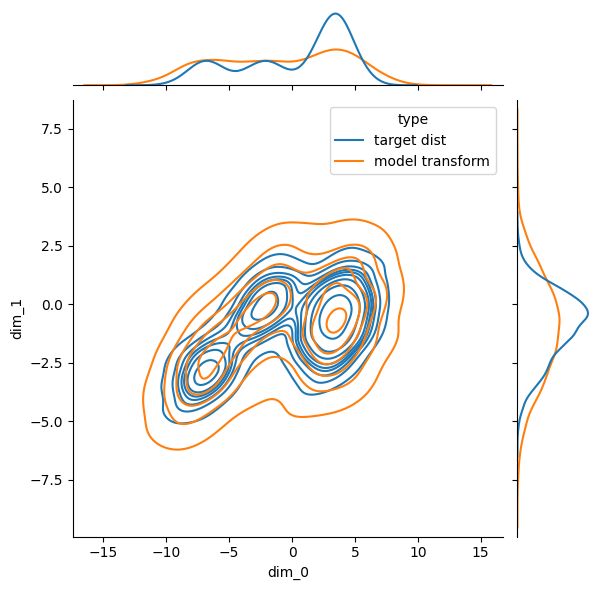

trail: 0 m step: 3 kl_test: 0.8134441375732422


  2%|▏         | 100/6000 [00:29<32:33,  3.02it/s]

trail: 0 m step: 4 Loss: 0.6377253532409668  L_n: 0.5490813255310059  kld: 0.008864402770996094 KLD1: 0.5700631737709045 KLD2: 0.3405649960041046


  3%|▎         | 200/6000 [00:59<31:27,  3.07it/s]

trail: 0 m step: 4 Loss: 0.7056589126586914  L_n: 0.5944318771362305  kld: 0.011122703552246094 KLD1: 0.5488145351409912 KLD2: 0.3210398852825165


  5%|▌         | 300/6000 [01:28<30:51,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6522135734558105  L_n: 0.5415301322937012  kld: 0.011068344116210938 KLD1: 0.5523053407669067 KLD2: 0.3342207372188568


  7%|▋         | 400/6000 [01:58<30:25,  3.07it/s]

trail: 0 m step: 4 Loss: 0.6758933067321777  L_n: 0.561790943145752  kld: 0.011410236358642578 KLD1: 0.5511272549629211 KLD2: 0.3381980359554291


  8%|▊         | 500/6000 [02:27<30:06,  3.04it/s]

trail: 0 m step: 4 Loss: 0.6764216423034668  L_n: 0.5591673851013184  kld: 0.011725425720214844 KLD1: 0.5440953373908997 KLD2: 0.33526816964149475


 10%|█         | 600/6000 [02:57<29:04,  3.10it/s]

trail: 0 m step: 4 Loss: 0.6744265556335449  L_n: 0.5563759803771973  kld: 0.011805057525634766 KLD1: 0.5428834557533264 KLD2: 0.31725648045539856


 12%|█▏        | 700/6000 [03:26<28:42,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6468162536621094  L_n: 0.5654821395874023  kld: 0.008133411407470703 KLD1: 0.5806585550308228 KLD2: 0.3199411928653717


 13%|█▎        | 800/6000 [03:56<28:06,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6530075073242188  L_n: 0.552943229675293  kld: 0.010006427764892578 KLD1: 0.5611305236816406 KLD2: 0.3370152413845062


 15%|█▌        | 900/6000 [04:25<27:39,  3.07it/s]

trail: 0 m step: 4 Loss: 0.6655550003051758  L_n: 0.5502796173095703  kld: 0.011527538299560547 KLD1: 0.5467174053192139 KLD2: 0.33920255303382874


 17%|█▋        | 1000/6000 [04:54<27:04,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6916074752807617  L_n: 0.5488901138305664  kld: 0.014271736145019531 KLD1: 0.5157784819602966 KLD2: 0.3279985189437866


 18%|█▊        | 1100/6000 [05:24<26:44,  3.05it/s]

trail: 0 m step: 4 Loss: 0.6660356521606445  L_n: 0.5405416488647461  kld: 0.012549400329589844 KLD1: 0.5364853739738464 KLD2: 0.328372597694397


 20%|██        | 1200/6000 [05:53<25:55,  3.09it/s]

trail: 0 m step: 4 Loss: 0.6528692245483398  L_n: 0.5461292266845703  kld: 0.010673999786376953 KLD1: 0.5540565252304077 KLD2: 0.3203900456428528


 22%|██▏       | 1300/6000 [06:23<25:26,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6257214546203613  L_n: 0.5145182609558105  kld: 0.011120319366455078 KLD1: 0.5477020740509033 KLD2: 0.32790789008140564


 23%|██▎       | 1400/6000 [06:52<24:53,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6446051597595215  L_n: 0.5383706092834473  kld: 0.010623455047607422 KLD1: 0.555232584476471 KLD2: 0.3152526915073395


 25%|██▌       | 1500/6000 [07:22<24:19,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6524333953857422  L_n: 0.538116455078125  kld: 0.011431694030761719 KLD1: 0.5442742109298706 KLD2: 0.32574477791786194


 27%|██▋       | 1600/6000 [07:51<23:54,  3.07it/s]

trail: 0 m step: 4 Loss: 0.6605353355407715  L_n: 0.5246367454528809  kld: 0.013589859008789062 KLD1: 0.5287280082702637 KLD2: 0.325056791305542


 28%|██▊       | 1700/6000 [08:20<23:10,  3.09it/s]

trail: 0 m step: 4 Loss: 0.6671476364135742  L_n: 0.5474615097045898  kld: 0.011968612670898438 KLD1: 0.5387268662452698 KLD2: 0.3376554846763611


 30%|███       | 1800/6000 [08:50<22:37,  3.09it/s]

trail: 0 m step: 4 Loss: 0.678126335144043  L_n: 0.5520601272583008  kld: 0.012606620788574219 KLD1: 0.5343801379203796 KLD2: 0.31919947266578674


 32%|███▏      | 1900/6000 [09:19<22:08,  3.09it/s]

trail: 0 m step: 4 Loss: 0.6812138557434082  L_n: 0.5772919654846191  kld: 0.010392189025878906 KLD1: 0.5528866052627563 KLD2: 0.32606032490730286


 33%|███▎      | 2000/6000 [09:49<21:33,  3.09it/s]

trail: 0 m step: 4 Loss: 0.651669979095459  L_n: 0.5395941734313965  kld: 0.01120758056640625 KLD1: 0.547922670841217 KLD2: 0.3178322911262512


 35%|███▌      | 2100/6000 [10:19<21:02,  3.09it/s]

trail: 0 m step: 4 Loss: 0.643345832824707  L_n: 0.5503387451171875  kld: 0.009300708770751953 KLD1: 0.5657457113265991 KLD2: 0.31650280952453613


 37%|███▋      | 2200/6000 [10:48<20:29,  3.09it/s]

trail: 0 m step: 4 Loss: 0.6344504356384277  L_n: 0.5298514366149902  kld: 0.01045989990234375 KLD1: 0.5507481694221497 KLD2: 0.33021488785743713


 38%|███▊      | 2300/6000 [11:17<20:01,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6989283561706543  L_n: 0.5688185691833496  kld: 0.013010978698730469 KLD1: 0.5301645398139954 KLD2: 0.33136284351348877


 40%|████      | 2400/6000 [11:47<19:25,  3.09it/s]

trail: 0 m step: 4 Loss: 0.6324372291564941  L_n: 0.5579838752746582  kld: 0.007445335388183594 KLD1: 0.5870817303657532 KLD2: 0.33853447437286377


 42%|████▏     | 2500/6000 [12:16<18:56,  3.08it/s]

trail: 0 m step: 4 Loss: 0.702791690826416  L_n: 0.5630688667297363  kld: 0.013972282409667969 KLD1: 0.5177956819534302 KLD2: 0.3245193362236023


 43%|████▎     | 2600/6000 [12:46<18:23,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6541662216186523  L_n: 0.5392436981201172  kld: 0.011492252349853516 KLD1: 0.5444595813751221 KLD2: 0.3218993544578552


 45%|████▌     | 2700/6000 [13:15<17:49,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6546897888183594  L_n: 0.5457134246826172  kld: 0.010897636413574219 KLD1: 0.5507119297981262 KLD2: 0.3310888409614563


 47%|████▋     | 2800/6000 [13:44<17:20,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6448826789855957  L_n: 0.5381760597229004  kld: 0.010670661926269531 KLD1: 0.5516026020050049 KLD2: 0.31753525137901306


 48%|████▊     | 2900/6000 [14:14<16:45,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6786494255065918  L_n: 0.5520157814025879  kld: 0.01266336441040039 KLD1: 0.5317277312278748 KLD2: 0.31889796257019043


 50%|█████     | 3000/6000 [14:43<16:13,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6492705345153809  L_n: 0.5371184349060059  kld: 0.0112152099609375 KLD1: 0.5470943450927734 KLD2: 0.3170251250267029


 52%|█████▏    | 3100/6000 [15:12<15:37,  3.09it/s]

trail: 0 m step: 4 Loss: 0.6338067054748535  L_n: 0.5316348075866699  kld: 0.01021718978881836 KLD1: 0.5620335936546326 KLD2: 0.3134320080280304


 53%|█████▎    | 3200/6000 [15:42<15:07,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6792478561401367  L_n: 0.5625228881835938  kld: 0.011672496795654297 KLD1: 0.5416657328605652 KLD2: 0.33064258098602295


 55%|█████▌    | 3300/6000 [16:11<14:34,  3.09it/s]

trail: 0 m step: 4 Loss: 0.6565666198730469  L_n: 0.5524110794067383  kld: 0.01041555404663086 KLD1: 0.5535878539085388 KLD2: 0.32358598709106445


 57%|█████▋    | 3400/6000 [16:41<14:05,  3.07it/s]

trail: 0 m step: 4 Loss: 0.6805405616760254  L_n: 0.5706534385681152  kld: 0.010988712310791016 KLD1: 0.5510240793228149 KLD2: 0.3178348243236542


 58%|█████▊    | 3500/6000 [17:10<13:42,  3.04it/s]

trail: 0 m step: 4 Loss: 0.6753802299499512  L_n: 0.5542445182800293  kld: 0.012113571166992188 KLD1: 0.5395978093147278 KLD2: 0.33093196153640747


 60%|██████    | 3600/6000 [17:40<13:04,  3.06it/s]

trail: 0 m step: 4 Loss: 0.6790223121643066  L_n: 0.568748950958252  kld: 0.011027336120605469 KLD1: 0.5459069013595581 KLD2: 0.31915488839149475


 62%|██████▏   | 3700/6000 [18:09<12:25,  3.08it/s]

trail: 0 m step: 4 Loss: 0.631432056427002  L_n: 0.5158133506774902  kld: 0.011561870574951172 KLD1: 0.5429707765579224 KLD2: 0.3237124979496002


 63%|██████▎   | 3800/6000 [18:38<11:54,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6614503860473633  L_n: 0.5529079437255859  kld: 0.010854244232177734 KLD1: 0.5523229241371155 KLD2: 0.31820806860923767


 65%|██████▌   | 3900/6000 [19:08<11:23,  3.07it/s]

trail: 0 m step: 4 Loss: 0.668950080871582  L_n: 0.5528831481933594  kld: 0.011606693267822266 KLD1: 0.5440730452537537 KLD2: 0.3119916319847107


 67%|██████▋   | 4000/6000 [19:37<10:50,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6686983108520508  L_n: 0.5431852340698242  kld: 0.012551307678222656 KLD1: 0.5314661264419556 KLD2: 0.3255554735660553


 68%|██████▊   | 4100/6000 [20:07<10:13,  3.10it/s]

trail: 0 m step: 4 Loss: 0.5987582206726074  L_n: 0.5192742347717285  kld: 0.00794839859008789 KLD1: 0.5803124308586121 KLD2: 0.333518922328949


 70%|███████   | 4200/6000 [20:36<09:46,  3.07it/s]

trail: 0 m step: 4 Loss: 0.6383132934570312  L_n: 0.5256080627441406  kld: 0.011270523071289062 KLD1: 0.5407429933547974 KLD2: 0.3208884596824646


 72%|███████▏  | 4300/6000 [21:05<09:11,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6508016586303711  L_n: 0.5421543121337891  kld: 0.010864734649658203 KLD1: 0.549278736114502 KLD2: 0.3207189440727234


 73%|███████▎  | 4400/6000 [21:35<08:39,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6492176055908203  L_n: 0.5523862838745117  kld: 0.00968313217163086 KLD1: 0.5594803094863892 KLD2: 0.3250179588794708


 75%|███████▌  | 4500/6000 [22:04<08:07,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6321921348571777  L_n: 0.533663272857666  kld: 0.009852886199951172 KLD1: 0.55964195728302 KLD2: 0.31882935762405396


 77%|███████▋  | 4600/6000 [22:34<07:35,  3.07it/s]

trail: 0 m step: 4 Loss: 0.6561703681945801  L_n: 0.5382199287414551  kld: 0.0117950439453125 KLD1: 0.541930079460144 KLD2: 0.31917959451675415


 78%|███████▊  | 4700/6000 [23:03<07:02,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6460227966308594  L_n: 0.5649032592773438  kld: 0.008111953735351562 KLD1: 0.5765417814254761 KLD2: 0.328581303358078


 80%|████████  | 4800/6000 [23:33<06:27,  3.10it/s]

trail: 0 m step: 4 Loss: 0.6770539283752441  L_n: 0.5433773994445801  kld: 0.013367652893066406 KLD1: 0.5246400237083435 KLD2: 0.31956663727760315


 82%|████████▏ | 4900/6000 [24:02<05:58,  3.07it/s]

trail: 0 m step: 4 Loss: 0.6564273834228516  L_n: 0.5466642379760742  kld: 0.010976314544677734 KLD1: 0.5519986152648926 KLD2: 0.32622236013412476


 83%|████████▎ | 5000/6000 [24:32<05:23,  3.09it/s]

trail: 0 m step: 4 Loss: 0.6487245559692383  L_n: 0.5409927368164062  kld: 0.010773181915283203 KLD1: 0.5495949983596802 KLD2: 0.3266476094722748


 85%|████████▌ | 5100/6000 [25:01<04:51,  3.09it/s]

trail: 0 m step: 4 Loss: 0.6291985511779785  L_n: 0.5263352394104004  kld: 0.010286331176757812 KLD1: 0.5544713139533997 KLD2: 0.32984858751296997


 87%|████████▋ | 5200/6000 [25:31<04:18,  3.09it/s]

trail: 0 m step: 4 Loss: 0.6674408912658691  L_n: 0.5556797981262207  kld: 0.011176109313964844 KLD1: 0.5474674105644226 KLD2: 0.3171146512031555


 88%|████████▊ | 5300/6000 [26:00<03:46,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6812682151794434  L_n: 0.5878510475158691  kld: 0.009341716766357422 KLD1: 0.5631484389305115 KLD2: 0.3264918029308319


 90%|█████████ | 5400/6000 [26:29<03:13,  3.10it/s]

trail: 0 m step: 4 Loss: 0.6189322471618652  L_n: 0.5349183082580566  kld: 0.00840139389038086 KLD1: 0.5755930542945862 KLD2: 0.3292964696884155


 92%|█████████▏| 5500/6000 [26:59<02:42,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6790661811828613  L_n: 0.568993091583252  kld: 0.011007308959960938 KLD1: 0.547953724861145 KLD2: 0.31952255964279175


 93%|█████████▎| 5600/6000 [27:29<02:09,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6465959548950195  L_n: 0.5375766754150391  kld: 0.010901927947998047 KLD1: 0.5479049682617188 KLD2: 0.3232852816581726


 95%|█████████▌| 5700/6000 [27:58<01:37,  3.08it/s]

trail: 0 m step: 4 Loss: 0.6428289413452148  L_n: 0.5325555801391602  kld: 0.011027336120605469 KLD1: 0.5448694229125977 KLD2: 0.3314064145088196


 97%|█████████▋| 5800/6000 [28:27<01:05,  3.07it/s]

trail: 0 m step: 4 Loss: 0.6512899398803711  L_n: 0.5348701477050781  kld: 0.011641979217529297 KLD1: 0.5440050363540649 KLD2: 0.3246847689151764


 98%|█████████▊| 5900/6000 [28:57<00:32,  3.07it/s]

trail: 0 m step: 4 Loss: 0.6413068771362305  L_n: 0.5317344665527344  kld: 0.01095724105834961 KLD1: 0.5500980019569397 KLD2: 0.32391268014907837


100%|██████████| 6000/6000 [29:26<00:00,  3.40it/s]

trail: 0 m step: 4 Loss: 0.6267180442810059  L_n: 0.5164542198181152  kld: 0.011026382446289062 KLD1: 0.5483840703964233 KLD2: 0.3213057816028595



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


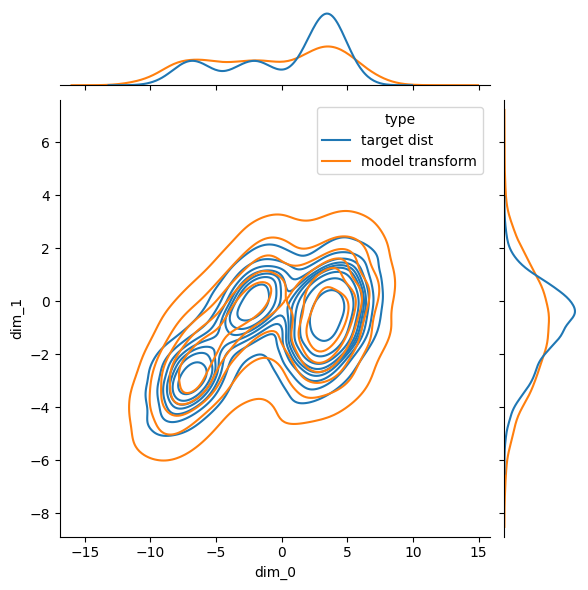

trail: 0 m step: 4 kl_test: 0.5599522590637207


  2%|▏         | 100/6000 [00:29<31:58,  3.08it/s]

trail: 0 m step: 5 Loss: 0.44524431228637695  L_n: 0.39072275161743164  kld: 0.005452156066894531 KLD1: 0.40845146775245667 KLD2: 0.26467791199684143


  3%|▎         | 200/6000 [00:58<31:11,  3.10it/s]

trail: 0 m step: 5 Loss: 0.5003185272216797  L_n: 0.43143463134765625  kld: 0.006888389587402344 KLD1: 0.3940731883049011 KLD2: 0.24834482371807098


  5%|▌         | 300/6000 [01:28<30:44,  3.09it/s]

trail: 0 m step: 5 Loss: 0.45562124252319336  L_n: 0.38623666763305664  kld: 0.006938457489013672 KLD1: 0.3949246108531952 KLD2: 0.25995194911956787


  7%|▋         | 400/6000 [01:57<30:19,  3.08it/s]

trail: 0 m step: 5 Loss: 0.4750485420227051  L_n: 0.40268850326538086  kld: 0.007236003875732422 KLD1: 0.3961182236671448 KLD2: 0.26514360308647156


  8%|▊         | 500/6000 [02:26<29:48,  3.07it/s]

trail: 0 m step: 5 Loss: 0.4758906364440918  L_n: 0.40209054946899414  kld: 0.007380008697509766 KLD1: 0.39179325103759766 KLD2: 0.262636661529541


 10%|█         | 600/6000 [02:56<29:11,  3.08it/s]

trail: 0 m step: 5 Loss: 0.47359132766723633  L_n: 0.3990187644958496  kld: 0.007457256317138672 KLD1: 0.3910582661628723 KLD2: 0.24630986154079437


 12%|█▏        | 700/6000 [03:25<28:37,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4565410614013672  L_n: 0.40643978118896484  kld: 0.005010128021240234 KLD1: 0.4162939488887787 KLD2: 0.24857230484485626


 13%|█▎        | 800/6000 [03:54<28:26,  3.05it/s]

trail: 0 m step: 5 Loss: 0.45580148696899414  L_n: 0.3962826728820801  kld: 0.005951881408691406 KLD1: 0.4049215018749237 KLD2: 0.26338666677474976


 15%|█▌        | 900/6000 [04:24<27:29,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4676380157470703  L_n: 0.39267444610595703  kld: 0.007496356964111328 KLD1: 0.39043059945106506 KLD2: 0.2655833065509796


 17%|█▋        | 1000/6000 [04:53<27:03,  3.08it/s]

trail: 0 m step: 5 Loss: 0.4899129867553711  L_n: 0.39481258392333984  kld: 0.009510040283203125 KLD1: 0.3676171898841858 KLD2: 0.2565534710884094


 18%|█▊        | 1100/6000 [05:23<26:24,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4681262969970703  L_n: 0.38860416412353516  kld: 0.007952213287353516 KLD1: 0.3859669864177704 KLD2: 0.25659364461898804


 20%|██        | 1200/6000 [05:52<25:56,  3.08it/s]

trail: 0 m step: 5 Loss: 0.45821380615234375  L_n: 0.39192867279052734  kld: 0.006628513336181641 KLD1: 0.39792048931121826 KLD2: 0.24893903732299805


 22%|██▏       | 1300/6000 [06:21<25:21,  3.09it/s]

trail: 0 m step: 5 Loss: 0.43924808502197266  L_n: 0.3686189651489258  kld: 0.0070629119873046875 KLD1: 0.3906666040420532 KLD2: 0.2560562491416931


 23%|██▎       | 1400/6000 [06:51<24:44,  3.10it/s]

trail: 0 m step: 5 Loss: 0.4533219337463379  L_n: 0.3877425193786621  kld: 0.006557941436767578 KLD1: 0.4001756012439728 KLD2: 0.24519509077072144


 25%|██▌       | 1500/6000 [07:20<24:16,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4556007385253906  L_n: 0.38280200958251953  kld: 0.007279872894287109 KLD1: 0.3872024416923523 KLD2: 0.25355976819992065


 27%|██▋       | 1600/6000 [07:50<23:47,  3.08it/s]

trail: 0 m step: 5 Loss: 0.4662032127380371  L_n: 0.37653398513793945  kld: 0.008966922760009766 KLD1: 0.37758374214172363 KLD2: 0.2526389956474304


 28%|██▊       | 1700/6000 [08:19<23:08,  3.10it/s]

trail: 0 m step: 5 Loss: 0.47229528427124023  L_n: 0.39273977279663086  kld: 0.007955551147460938 KLD1: 0.38407084345817566 KLD2: 0.26491019129753113


 30%|███       | 1800/6000 [08:48<22:43,  3.08it/s]

trail: 0 m step: 5 Loss: 0.47882556915283203  L_n: 0.3926420211791992  kld: 0.008618354797363281 KLD1: 0.37911921739578247 KLD2: 0.2470570206642151


 32%|███▏      | 1900/6000 [09:18<22:08,  3.09it/s]

trail: 0 m step: 5 Loss: 0.47869873046875  L_n: 0.4156465530395508  kld: 0.006305217742919922 KLD1: 0.39723411202430725 KLD2: 0.2544603943824768


 33%|███▎      | 2000/6000 [09:47<22:09,  3.01it/s]

trail: 0 m step: 5 Loss: 0.4568767547607422  L_n: 0.38748741149902344  kld: 0.006938934326171875 KLD1: 0.3955962359905243 KLD2: 0.246768981218338


 35%|███▌      | 2100/6000 [10:17<20:59,  3.10it/s]

trail: 0 m step: 5 Loss: 0.4525609016418457  L_n: 0.396298885345459  kld: 0.005626201629638672 KLD1: 0.40792039036750793 KLD2: 0.2459018975496292


 37%|███▋      | 2200/6000 [10:46<20:32,  3.08it/s]

trail: 0 m step: 5 Loss: 0.4427509307861328  L_n: 0.3795604705810547  kld: 0.0063190460205078125 KLD1: 0.3953777849674225 KLD2: 0.25827935338020325


 38%|███▊      | 2300/6000 [11:16<20:02,  3.08it/s]

trail: 0 m step: 5 Loss: 0.494138240814209  L_n: 0.40817880630493164  kld: 0.008595943450927734 KLD1: 0.3775586783885956 KLD2: 0.25899940729141235


 40%|████      | 2400/6000 [11:45<19:21,  3.10it/s]

trail: 0 m step: 5 Loss: 0.4380970001220703  L_n: 0.3980140686035156  kld: 0.004008293151855469 KLD1: 0.4251054525375366 KLD2: 0.26578786969184875


 42%|████▏     | 2500/6000 [12:14<18:55,  3.08it/s]

trail: 0 m step: 5 Loss: 0.49941253662109375  L_n: 0.4057188034057617  kld: 0.009369373321533203 KLD1: 0.36873456835746765 KLD2: 0.2528143525123596


 43%|████▎     | 2600/6000 [12:44<18:18,  3.09it/s]

trail: 0 m step: 5 Loss: 0.46070146560668945  L_n: 0.3871731758117676  kld: 0.0073528289794921875 KLD1: 0.38949263095855713 KLD2: 0.2509012222290039


 45%|████▌     | 2700/6000 [13:13<18:14,  3.02it/s]

trail: 0 m step: 5 Loss: 0.4599766731262207  L_n: 0.3915839195251465  kld: 0.006839275360107422 KLD1: 0.3958222568035126 KLD2: 0.2588755190372467


 47%|████▋     | 2800/6000 [13:43<17:15,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4510941505432129  L_n: 0.38533830642700195  kld: 0.006575584411621094 KLD1: 0.396663635969162 KLD2: 0.24670977890491486


 48%|████▊     | 2900/6000 [14:12<16:42,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4789867401123047  L_n: 0.39693260192871094  kld: 0.008205413818359375 KLD1: 0.37983328104019165 KLD2: 0.24787543714046478


 50%|█████     | 3000/6000 [14:41<16:07,  3.10it/s]

trail: 0 m step: 5 Loss: 0.4535098075866699  L_n: 0.3813643455505371  kld: 0.007214546203613281 KLD1: 0.39180678129196167 KLD2: 0.24576933681964874


 52%|█████▏    | 3100/6000 [15:11<15:37,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4412069320678711  L_n: 0.3782787322998047  kld: 0.006292819976806641 KLD1: 0.4036502242088318 KLD2: 0.24283580482006073


 53%|█████▎    | 3200/6000 [15:41<15:09,  3.08it/s]

trail: 0 m step: 5 Loss: 0.4810829162597656  L_n: 0.40591907501220703  kld: 0.007516384124755859 KLD1: 0.3879659175872803 KLD2: 0.2587743103504181


 55%|█████▌    | 3300/6000 [16:10<14:32,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4643821716308594  L_n: 0.3989076614379883  kld: 0.006547451019287109 KLD1: 0.3956233263015747 KLD2: 0.2521153688430786


 57%|█████▋    | 3400/6000 [16:39<13:57,  3.11it/s]

trail: 0 m step: 5 Loss: 0.48009204864501953  L_n: 0.41171836853027344  kld: 0.006837368011474609 KLD1: 0.3955060541629791 KLD2: 0.24710224568843842


 58%|█████▊    | 3500/6000 [17:09<13:26,  3.10it/s]

trail: 0 m step: 5 Loss: 0.4759197235107422  L_n: 0.3977947235107422  kld: 0.0078125 KLD1: 0.386888712644577 KLD2: 0.25880157947540283


 60%|██████    | 3600/6000 [17:38<12:56,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4809575080871582  L_n: 0.409512996673584  kld: 0.007144451141357422 KLD1: 0.3893434703350067 KLD2: 0.24803808331489563


 62%|██████▏   | 3700/6000 [18:07<12:24,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4407963752746582  L_n: 0.36663389205932617  kld: 0.007416248321533203 KLD1: 0.38847893476486206 KLD2: 0.25239256024360657


 63%|██████▎   | 3800/6000 [18:37<11:59,  3.06it/s]

trail: 0 m step: 5 Loss: 0.466641902923584  L_n: 0.3978390693664551  kld: 0.006880283355712891 KLD1: 0.3956761360168457 KLD2: 0.24747946858406067


 65%|██████▌   | 3900/6000 [19:06<11:40,  3.00it/s]

trail: 0 m step: 5 Loss: 0.4718918800354004  L_n: 0.39980363845825195  kld: 0.007208824157714844 KLD1: 0.39077049493789673 KLD2: 0.24164320528507233


 67%|██████▋   | 4000/6000 [19:36<10:46,  3.09it/s]

trail: 0 m step: 5 Loss: 0.47284746170043945  L_n: 0.39061689376831055  kld: 0.00822305679321289 KLD1: 0.3793010711669922 KLD2: 0.25374260544776917


 68%|██████▊   | 4100/6000 [20:05<10:17,  3.08it/s]

trail: 0 m step: 5 Loss: 0.41445207595825195  L_n: 0.36971521377563477  kld: 0.004473686218261719 KLD1: 0.4187319278717041 KLD2: 0.2611274719238281


 70%|███████   | 4200/6000 [20:34<09:44,  3.08it/s]

trail: 0 m step: 5 Loss: 0.44545555114746094  L_n: 0.3743400573730469  kld: 0.007111549377441406 KLD1: 0.38668984174728394 KLD2: 0.2496255785226822


 72%|███████▏  | 4300/6000 [21:04<09:08,  3.10it/s]

trail: 0 m step: 5 Loss: 0.45700597763061523  L_n: 0.3894381523132324  kld: 0.006756782531738281 KLD1: 0.39329734444618225 KLD2: 0.2499854415655136


 73%|███████▎  | 4400/6000 [21:33<08:37,  3.09it/s]

trail: 0 m step: 5 Loss: 0.45415639877319336  L_n: 0.3961968421936035  kld: 0.005795955657958984 KLD1: 0.4021341800689697 KLD2: 0.253710001707077


 75%|███████▌  | 4500/6000 [22:03<08:05,  3.09it/s]

trail: 0 m step: 5 Loss: 0.43859004974365234  L_n: 0.3792715072631836  kld: 0.005931854248046875 KLD1: 0.4024710953235626 KLD2: 0.2476203739643097


 77%|███████▋  | 4600/6000 [22:32<07:35,  3.07it/s]

trail: 0 m step: 5 Loss: 0.4594883918762207  L_n: 0.3834567070007324  kld: 0.007603168487548828 KLD1: 0.3868925869464874 KLD2: 0.24802826344966888


 78%|███████▊  | 4700/6000 [23:02<07:02,  3.07it/s]

trail: 0 m step: 5 Loss: 0.4521212577819824  L_n: 0.40601110458374023  kld: 0.004611015319824219 KLD1: 0.4159295856952667 KLD2: 0.25673967599868774


 80%|████████  | 4800/6000 [23:31<06:27,  3.09it/s]

trail: 0 m step: 5 Loss: 0.47586870193481445  L_n: 0.39053869247436523  kld: 0.008533000946044922 KLD1: 0.37610527873039246 KLD2: 0.24864716827869415


 82%|████████▏ | 4900/6000 [24:01<05:56,  3.09it/s]

trail: 0 m step: 5 Loss: 0.46071815490722656  L_n: 0.3934030532836914  kld: 0.006731510162353516 KLD1: 0.39714115858078003 KLD2: 0.25495219230651855


 83%|████████▎ | 5000/6000 [24:30<05:24,  3.08it/s]

trail: 0 m step: 5 Loss: 0.45461273193359375  L_n: 0.38751697540283203  kld: 0.006709575653076172 KLD1: 0.39498457312583923 KLD2: 0.25503963232040405


 85%|████████▌ | 5100/6000 [24:59<04:52,  3.08it/s]

trail: 0 m step: 5 Loss: 0.44103097915649414  L_n: 0.37579965591430664  kld: 0.00652313232421875 KLD1: 0.3968188464641571 KLD2: 0.25796186923980713


 87%|████████▋ | 5200/6000 [25:29<04:18,  3.10it/s]

trail: 0 m step: 5 Loss: 0.466947078704834  L_n: 0.3989071846008301  kld: 0.006803989410400391 KLD1: 0.3940177857875824 KLD2: 0.24657271802425385


 88%|████████▊ | 5300/6000 [25:58<03:58,  2.94it/s]

trail: 0 m step: 5 Loss: 0.48053884506225586  L_n: 0.42473459243774414  kld: 0.005580425262451172 KLD1: 0.40587615966796875 KLD2: 0.25496524572372437


 90%|█████████ | 5400/6000 [26:28<03:21,  2.97it/s]

trail: 0 m step: 5 Loss: 0.43001413345336914  L_n: 0.381467342376709  kld: 0.004854679107666016 KLD1: 0.4153141975402832 KLD2: 0.25727495551109314


 92%|█████████▏| 5500/6000 [26:57<02:41,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4773902893066406  L_n: 0.40840625762939453  kld: 0.006898403167724609 KLD1: 0.3924340605735779 KLD2: 0.24859242141246796


 93%|█████████▎| 5600/6000 [27:26<02:09,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4568600654602051  L_n: 0.38756608963012695  kld: 0.0069293975830078125 KLD1: 0.39296621084213257 KLD2: 0.2519126832485199


 95%|█████████▌| 5700/6000 [27:56<01:36,  3.10it/s]

trail: 0 m step: 5 Loss: 0.4483308792114258  L_n: 0.38092517852783203  kld: 0.006740570068359375 KLD1: 0.39216485619544983 KLD2: 0.2591313123703003


 97%|█████████▋| 5800/6000 [28:25<01:04,  3.09it/s]

trail: 0 m step: 5 Loss: 0.4555802345275879  L_n: 0.3816370964050293  kld: 0.007394313812255859 KLD1: 0.3901052474975586 KLD2: 0.2531226873397827


 98%|█████████▊| 5900/6000 [28:55<00:32,  3.10it/s]

trail: 0 m step: 5 Loss: 0.449404239654541  L_n: 0.3812260627746582  kld: 0.006817817687988281 KLD1: 0.39422905445098877 KLD2: 0.2527320683002472


100%|██████████| 6000/6000 [29:24<00:00,  3.40it/s]

trail: 0 m step: 5 Loss: 0.43647098541259766  L_n: 0.3673105239868164  kld: 0.006916046142578125 KLD1: 0.3923020660877228 KLD2: 0.2503378391265869



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


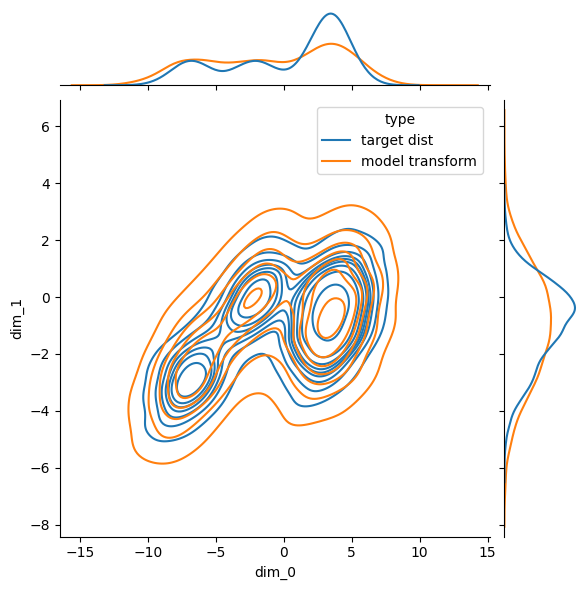

trail: 0 m step: 5 kl_test: 0.4033985137939453


  2%|▏         | 100/6000 [00:29<32:21,  3.04it/s]

trail: 0 m step: 6 Loss: 0.32317590713500977  L_n: 0.2869744300842285  kld: 0.003620147705078125 KLD1: 0.301388680934906 KLD2: 0.2080174684524536


  3%|▎         | 200/6000 [00:58<31:13,  3.10it/s]

trail: 0 m step: 6 Loss: 0.36700963973999023  L_n: 0.32115697860717773  kld: 0.00458526611328125 KLD1: 0.29208412766456604 KLD2: 0.19425514340400696


  5%|▌         | 300/6000 [01:28<30:34,  3.11it/s]

trail: 0 m step: 6 Loss: 0.32981204986572266  L_n: 0.28479862213134766  kld: 0.0045013427734375 KLD1: 0.29124563932418823 KLD2: 0.20499132573604584


  7%|▋         | 400/6000 [01:57<30:10,  3.09it/s]

trail: 0 m step: 6 Loss: 0.3460698127746582  L_n: 0.2978997230529785  kld: 0.004817008972167969 KLD1: 0.2925528585910797 KLD2: 0.210214301943779


  8%|▊         | 500/6000 [02:26<29:59,  3.06it/s]

trail: 0 m step: 6 Loss: 0.34639739990234375  L_n: 0.2974071502685547  kld: 0.004899024963378906 KLD1: 0.29006850719451904 KLD2: 0.20796345174312592


 10%|█         | 600/6000 [02:56<29:01,  3.10it/s]

trail: 0 m step: 6 Loss: 0.34514570236206055  L_n: 0.2959122657775879  kld: 0.004923343658447266 KLD1: 0.2904215157032013 KLD2: 0.19409866631031036


 12%|█▏        | 700/6000 [03:25<28:32,  3.10it/s]

trail: 0 m step: 6 Loss: 0.33425283432006836  L_n: 0.30030202865600586  kld: 0.00339508056640625 KLD1: 0.3059667944908142 KLD2: 0.19519096612930298


 13%|█▎        | 800/6000 [03:54<27:52,  3.11it/s]

trail: 0 m step: 6 Loss: 0.33071231842041016  L_n: 0.2937049865722656  kld: 0.003700733184814453 KLD1: 0.3019530177116394 KLD2: 0.20899321138858795


 15%|█▌        | 900/6000 [04:24<27:31,  3.09it/s]

trail: 0 m step: 6 Loss: 0.3397507667541504  L_n: 0.28905344009399414  kld: 0.005069732666015625 KLD1: 0.2884691059589386 KLD2: 0.2109493613243103


 17%|█▋        | 1000/6000 [04:53<27:00,  3.09it/s]

trail: 0 m step: 6 Loss: 0.36025094985961914  L_n: 0.29280710220336914  kld: 0.006744384765625 KLD1: 0.269660621881485 KLD2: 0.20305486023426056


 18%|█▊        | 1100/6000 [05:22<26:30,  3.08it/s]

trail: 0 m step: 6 Loss: 0.3428635597229004  L_n: 0.287416934967041  kld: 0.0055446624755859375 KLD1: 0.28589367866516113 KLD2: 0.20260341465473175


 20%|██        | 1200/6000 [05:52<25:53,  3.09it/s]

trail: 0 m step: 6 Loss: 0.33348798751831055  L_n: 0.28983354568481445  kld: 0.004365444183349609 KLD1: 0.29437437653541565 KLD2: 0.19557581841945648


 22%|██▏       | 1300/6000 [06:21<25:14,  3.10it/s]

trail: 0 m step: 6 Loss: 0.3199892044067383  L_n: 0.27250099182128906  kld: 0.004748821258544922 KLD1: 0.2873627543449402 KLD2: 0.20240795612335205


 23%|██▎       | 1400/6000 [06:50<24:47,  3.09it/s]

trail: 0 m step: 6 Loss: 0.33028316497802734  L_n: 0.2868623733520508  kld: 0.004342079162597656 KLD1: 0.2961699366569519 KLD2: 0.19248683750629425


 25%|██▌       | 1500/6000 [07:20<24:12,  3.10it/s]

trail: 0 m step: 6 Loss: 0.33204221725463867  L_n: 0.2807297706604004  kld: 0.005131244659423828 KLD1: 0.284403920173645 KLD2: 0.19976964592933655


 27%|██▋       | 1600/6000 [07:49<23:34,  3.11it/s]

trail: 0 m step: 6 Loss: 0.34107160568237305  L_n: 0.27852487564086914  kld: 0.006254673004150391 KLD1: 0.2777274549007416 KLD2: 0.19887274503707886


 28%|██▊       | 1700/6000 [08:19<23:09,  3.10it/s]

trail: 0 m step: 6 Loss: 0.34642791748046875  L_n: 0.28951263427734375  kld: 0.0056915283203125 KLD1: 0.28081804513931274 KLD2: 0.2101375013589859


 30%|███       | 1800/6000 [08:48<22:43,  3.08it/s]

trail: 0 m step: 6 Loss: 0.35213565826416016  L_n: 0.28864002227783203  kld: 0.0063495635986328125 KLD1: 0.27766191959381104 KLD2: 0.1933361291885376


 32%|███▏      | 1900/6000 [09:18<22:05,  3.09it/s]

trail: 0 m step: 6 Loss: 0.34731149673461914  L_n: 0.3069281578063965  kld: 0.004038333892822266 KLD1: 0.29406967759132385 KLD2: 0.20088772475719452


 33%|███▎      | 2000/6000 [09:47<21:34,  3.09it/s]

trail: 0 m step: 6 Loss: 0.3330211639404297  L_n: 0.285614013671875  kld: 0.004740715026855469 KLD1: 0.2924676537513733 KLD2: 0.19328854978084564


 35%|███▌      | 2100/6000 [10:16<21:57,  2.96it/s]

trail: 0 m step: 6 Loss: 0.32962846755981445  L_n: 0.2954249382019043  kld: 0.0034203529357910156 KLD1: 0.3027231693267822 KLD2: 0.19328223168849945


 37%|███▋      | 2200/6000 [10:46<20:30,  3.09it/s]

trail: 0 m step: 6 Loss: 0.32080507278442383  L_n: 0.2801976203918457  kld: 0.0040607452392578125 KLD1: 0.29274454712867737 KLD2: 0.20452770590782166


 38%|███▊      | 2300/6000 [11:15<20:17,  3.04it/s]

trail: 0 m step: 6 Loss: 0.3624577522277832  L_n: 0.3015751838684082  kld: 0.0060882568359375 KLD1: 0.2774900794029236 KLD2: 0.20474766194820404


 40%|████      | 2400/6000 [11:45<19:47,  3.03it/s]

trail: 0 m step: 6 Loss: 0.31364011764526367  L_n: 0.2920536994934082  kld: 0.002158641815185547 KLD1: 0.31620848178863525 KLD2: 0.21094898879528046


 42%|████▏     | 2500/6000 [12:14<18:53,  3.09it/s]

trail: 0 m step: 6 Loss: 0.36834001541137695  L_n: 0.30150651931762695  kld: 0.006683349609375 KLD1: 0.2713382840156555 KLD2: 0.19924499094486237


 43%|████▎     | 2600/6000 [12:43<18:22,  3.08it/s]

trail: 0 m step: 6 Loss: 0.33679962158203125  L_n: 0.2859210968017578  kld: 0.005087852478027344 KLD1: 0.28718191385269165 KLD2: 0.19787780940532684


 45%|████▌     | 2700/6000 [13:13<17:46,  3.09it/s]

trail: 0 m step: 6 Loss: 0.33487462997436523  L_n: 0.28940343856811523  kld: 0.004547119140625 KLD1: 0.2931070625782013 KLD2: 0.2048310935497284


 47%|████▋     | 2800/6000 [13:42<17:17,  3.08it/s]

trail: 0 m step: 6 Loss: 0.32609081268310547  L_n: 0.2826271057128906  kld: 0.004346370697021484 KLD1: 0.2937905490398407 KLD2: 0.19359268248081207


 48%|████▊     | 2900/6000 [14:12<16:43,  3.09it/s]

trail: 0 m step: 6 Loss: 0.35111284255981445  L_n: 0.29529428482055664  kld: 0.005581855773925781 KLD1: 0.28047797083854675 KLD2: 0.1948162317276001


 50%|█████     | 3000/6000 [14:41<16:25,  3.04it/s]

trail: 0 m step: 6 Loss: 0.32770538330078125  L_n: 0.2798929214477539  kld: 0.004781246185302734 KLD1: 0.2899481952190399 KLD2: 0.1930098831653595


 52%|█████▏    | 3100/6000 [15:10<15:38,  3.09it/s]

trail: 0 m step: 6 Loss: 0.31922197341918945  L_n: 0.27667856216430664  kld: 0.004254341125488281 KLD1: 0.2984378933906555 KLD2: 0.18973957002162933


 53%|█████▎    | 3200/6000 [15:40<15:07,  3.09it/s]

trail: 0 m step: 6 Loss: 0.35350561141967773  L_n: 0.302121639251709  kld: 0.005138397216796875 KLD1: 0.28642845153808594 KLD2: 0.20508502423763275


 55%|█████▌    | 3300/6000 [16:10<14:45,  3.05it/s]

trail: 0 m step: 6 Loss: 0.34207773208618164  L_n: 0.29745054244995117  kld: 0.004462718963623047 KLD1: 0.29180267453193665 KLD2: 0.1986912041902542


 57%|█████▋    | 3400/6000 [16:39<14:27,  3.00it/s]

trail: 0 m step: 6 Loss: 0.3523082733154297  L_n: 0.3067941665649414  kld: 0.004551410675048828 KLD1: 0.2924244999885559 KLD2: 0.19425883889198303


 58%|█████▊    | 3500/6000 [17:08<13:30,  3.09it/s]

trail: 0 m step: 6 Loss: 0.3483242988586426  L_n: 0.29444169998168945  kld: 0.0053882598876953125 KLD1: 0.28678154945373535 KLD2: 0.204995796084404


 60%|██████    | 3600/6000 [17:38<12:57,  3.09it/s]

trail: 0 m step: 6 Loss: 0.3521270751953125  L_n: 0.30426692962646484  kld: 0.004786014556884766 KLD1: 0.2863742709159851 KLD2: 0.19514521956443787


 62%|██████▏   | 3700/6000 [18:07<12:24,  3.09it/s]

trail: 0 m step: 6 Loss: 0.31934070587158203  L_n: 0.26926326751708984  kld: 0.005007743835449219 KLD1: 0.28661584854125977 KLD2: 0.19939950108528137


 63%|██████▎   | 3800/6000 [18:37<11:51,  3.09it/s]

trail: 0 m step: 6 Loss: 0.3411374092102051  L_n: 0.294588565826416  kld: 0.004654884338378906 KLD1: 0.29183733463287354 KLD2: 0.19477155804634094


 65%|██████▌   | 3900/6000 [19:06<11:38,  3.01it/s]

trail: 0 m step: 6 Loss: 0.3446688652038574  L_n: 0.2957453727722168  kld: 0.0048923492431640625 KLD1: 0.2881797254085541 KLD2: 0.189329132437706


 67%|██████▋   | 4000/6000 [19:36<10:45,  3.10it/s]

trail: 0 m step: 6 Loss: 0.34597158432006836  L_n: 0.289151668548584  kld: 0.0056819915771484375 KLD1: 0.27923351526260376 KLD2: 0.20011773705482483


 68%|██████▊   | 4100/6000 [20:05<10:17,  3.08it/s]

trail: 0 m step: 6 Loss: 0.2970128059387207  L_n: 0.2710442543029785  kld: 0.0025968551635742188 KLD1: 0.3112829029560089 KLD2: 0.2069929838180542


 70%|███████   | 4200/6000 [20:35<09:42,  3.09it/s]

trail: 0 m step: 6 Loss: 0.3235440254211426  L_n: 0.2748541831970215  kld: 0.004868984222412109 KLD1: 0.28564995527267456 KLD2: 0.1962624192237854


 72%|███████▏  | 4300/6000 [21:04<09:06,  3.11it/s]

trail: 0 m step: 6 Loss: 0.33274173736572266  L_n: 0.28770923614501953  kld: 0.0045032501220703125 KLD1: 0.29033899307250977 KLD2: 0.19703324139118195


 73%|███████▎  | 4400/6000 [21:34<08:38,  3.08it/s]

trail: 0 m step: 6 Loss: 0.32948827743530273  L_n: 0.29244279861450195  kld: 0.003704547882080078 KLD1: 0.29783621430397034 KLD2: 0.2003486007452011


 75%|███████▌  | 4500/6000 [22:03<08:07,  3.08it/s]

trail: 0 m step: 6 Loss: 0.3158259391784668  L_n: 0.2785038948059082  kld: 0.0037322044372558594 KLD1: 0.29959210753440857 KLD2: 0.19466359913349152


 77%|███████▋  | 4600/6000 [22:32<07:32,  3.10it/s]

trail: 0 m step: 6 Loss: 0.33512449264526367  L_n: 0.28229570388793945  kld: 0.005282878875732422 KLD1: 0.2850993275642395 KLD2: 0.19517351686954498


 78%|███████▊  | 4700/6000 [23:02<06:59,  3.10it/s]

trail: 0 m step: 6 Loss: 0.32913875579833984  L_n: 0.3014202117919922  kld: 0.0027718544006347656 KLD1: 0.3083884119987488 KLD2: 0.20295093953609467


 80%|████████  | 4800/6000 [23:32<06:28,  3.09it/s]

trail: 0 m step: 6 Loss: 0.34737348556518555  L_n: 0.2892947196960449  kld: 0.0058078765869140625 KLD1: 0.278854638338089 KLD2: 0.19557687640190125


 82%|████████▏ | 4900/6000 [24:01<05:56,  3.09it/s]

trail: 0 m step: 6 Loss: 0.3379082679748535  L_n: 0.2930474281311035  kld: 0.004486083984375 KLD1: 0.29391518235206604 KLD2: 0.20139265060424805


 83%|████████▎ | 5000/6000 [24:31<05:25,  3.07it/s]

trail: 0 m step: 6 Loss: 0.3296670913696289  L_n: 0.285736083984375  kld: 0.004393100738525391 KLD1: 0.29349127411842346 KLD2: 0.20153836905956268


 85%|████████▌ | 5100/6000 [25:00<04:51,  3.08it/s]

trail: 0 m step: 6 Loss: 0.32087135314941406  L_n: 0.27722644805908203  kld: 0.004364490509033203 KLD1: 0.2922401428222656 KLD2: 0.2041778266429901


 87%|████████▋ | 5200/6000 [25:30<04:17,  3.10it/s]

trail: 0 m step: 6 Loss: 0.33957481384277344  L_n: 0.29599666595458984  kld: 0.004357814788818359 KLD1: 0.29231932759284973 KLD2: 0.1940266340970993


 88%|████████▊ | 5300/6000 [25:59<03:46,  3.09it/s]

trail: 0 m step: 6 Loss: 0.35220909118652344  L_n: 0.3165321350097656  kld: 0.0035676956176757812 KLD1: 0.3009072244167328 KLD2: 0.2012685239315033


 90%|█████████ | 5400/6000 [26:29<03:14,  3.09it/s]

trail: 0 m step: 6 Loss: 0.31109619140625  L_n: 0.28151798248291016  kld: 0.0029578208923339844 KLD1: 0.3089699447154999 KLD2: 0.2036229819059372


 92%|█████████▏| 5500/6000 [26:58<02:48,  2.96it/s]

trail: 0 m step: 6 Loss: 0.35047435760498047  L_n: 0.30341529846191406  kld: 0.004705905914306641 KLD1: 0.2900194823741913 KLD2: 0.19571058452129364


 93%|█████████▎| 5600/6000 [27:28<02:09,  3.08it/s]

trail: 0 m step: 6 Loss: 0.33571338653564453  L_n: 0.28807735443115234  kld: 0.004763603210449219 KLD1: 0.29174521565437317 KLD2: 0.19868279993534088


 95%|█████████▌| 5700/6000 [27:57<01:37,  3.08it/s]

trail: 0 m step: 6 Loss: 0.32471418380737305  L_n: 0.28159379959106445  kld: 0.004312038421630859 KLD1: 0.29094603657722473 KLD2: 0.20504829287528992


 97%|█████████▋| 5800/6000 [28:27<01:05,  3.06it/s]

trail: 0 m step: 6 Loss: 0.3308424949645996  L_n: 0.28081750869750977  kld: 0.005002498626708984 KLD1: 0.28881797194480896 KLD2: 0.19973869621753693


 98%|█████████▊| 5900/6000 [28:56<00:32,  3.09it/s]

trail: 0 m step: 6 Loss: 0.3267221450805664  L_n: 0.28110790252685547  kld: 0.004561424255371094 KLD1: 0.29111990332603455 KLD2: 0.19981689751148224


100%|██████████| 6000/6000 [29:25<00:00,  3.40it/s]

trail: 0 m step: 6 Loss: 0.3162956237792969  L_n: 0.26897430419921875  kld: 0.0047321319580078125 KLD1: 0.28870275616645813 KLD2: 0.1972033828496933



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


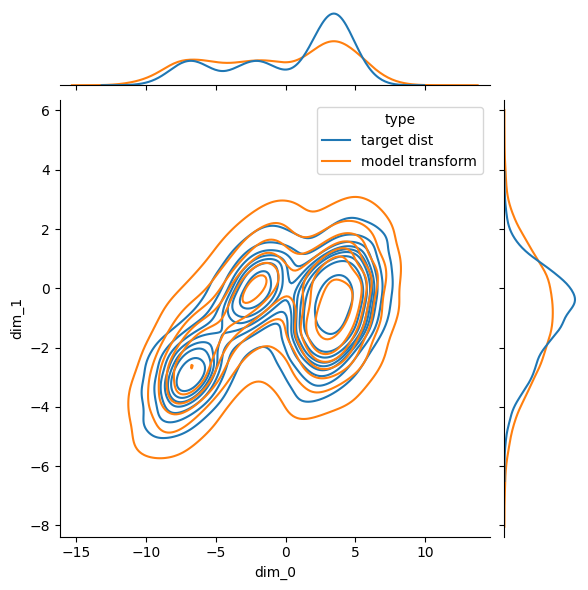

trail: 0 m step: 6 kl_test: 0.2996706962585449


  2%|▏         | 100/6000 [00:29<32:20,  3.04it/s]

trail: 0 m step: 7 Loss: 0.2409992218017578  L_n: 0.2145538330078125  kld: 0.0026445388793945312 KLD1: 0.22627626359462738 KLD2: 0.16494469344615936


  3%|▎         | 200/6000 [00:59<31:06,  3.11it/s]

trail: 0 m step: 7 Loss: 0.2766742706298828  L_n: 0.2448406219482422  kld: 0.0031833648681640625 KLD1: 0.22132717072963715 KLD2: 0.15327630937099457


  5%|▌         | 300/6000 [01:28<30:32,  3.11it/s]

trail: 0 m step: 7 Loss: 0.2453012466430664  L_n: 0.21503639221191406  kld: 0.0030264854431152344 KLD1: 0.22027401626110077 KLD2: 0.16340935230255127


  7%|▋         | 400/6000 [01:57<30:11,  3.09it/s]

trail: 0 m step: 7 Loss: 0.2601895332336426  L_n: 0.22760248184204102  kld: 0.0032587051391601562 KLD1: 0.22200559079647064 KLD2: 0.16866932809352875


  8%|▊         | 500/6000 [02:26<29:28,  3.11it/s]

trail: 0 m step: 7 Loss: 0.26009607315063477  L_n: 0.2256016731262207  kld: 0.0034494400024414062 KLD1: 0.22027230262756348 KLD2: 0.16640226542949677


 10%|█         | 600/6000 [02:56<29:06,  3.09it/s]

trail: 0 m step: 7 Loss: 0.25855541229248047  L_n: 0.22358417510986328  kld: 0.0034971237182617188 KLD1: 0.21968969702720642 KLD2: 0.15382251143455505


 12%|█▏        | 700/6000 [03:25<28:29,  3.10it/s]

trail: 0 m step: 7 Loss: 0.25154972076416016  L_n: 0.22678756713867188  kld: 0.002476215362548828 KLD1: 0.23007360100746155 KLD2: 0.15450824797153473


 13%|█▎        | 800/6000 [03:55<28:15,  3.07it/s]

trail: 0 m step: 7 Loss: 0.24588966369628906  L_n: 0.22266292572021484  kld: 0.002322673797607422 KLD1: 0.22975625097751617 KLD2: 0.1671328991651535


 15%|█▌        | 900/6000 [04:24<27:34,  3.08it/s]

trail: 0 m step: 7 Loss: 0.2542109489440918  L_n: 0.21819067001342773  kld: 0.0036020278930664062 KLD1: 0.21838432550430298 KLD2: 0.16917535662651062


 17%|█▋        | 1000/6000 [04:53<26:57,  3.09it/s]

trail: 0 m step: 7 Loss: 0.27302122116088867  L_n: 0.22225713729858398  kld: 0.005076408386230469 KLD1: 0.20181982219219208 KLD2: 0.16195280849933624


 18%|█▊        | 1100/6000 [05:23<26:22,  3.10it/s]

trail: 0 m step: 7 Loss: 0.2572450637817383  L_n: 0.21740055084228516  kld: 0.0039844512939453125 KLD1: 0.2169295847415924 KLD2: 0.16153360903263092


 20%|██        | 1200/6000 [05:52<26:00,  3.08it/s]

trail: 0 m step: 7 Loss: 0.2492809295654297  L_n: 0.21875381469726562  kld: 0.0030527114868164062 KLD1: 0.22224818170070648 KLD2: 0.15495665371418


 22%|██▏       | 1300/6000 [06:22<25:28,  3.07it/s]

trail: 0 m step: 7 Loss: 0.2401576042175293  L_n: 0.20646905899047852  kld: 0.003368854522705078 KLD1: 0.21613256633281708 KLD2: 0.16166412830352783


 23%|██▎       | 1400/6000 [06:51<24:37,  3.11it/s]

trail: 0 m step: 7 Loss: 0.2462754249572754  L_n: 0.2163538932800293  kld: 0.0029921531677246094 KLD1: 0.22440937161445618 KLD2: 0.15237630903720856


 25%|██▌       | 1500/6000 [07:20<24:25,  3.07it/s]

trail: 0 m step: 7 Loss: 0.24948549270629883  L_n: 0.21222543716430664  kld: 0.0037260055541992188 KLD1: 0.2138412594795227 KLD2: 0.15916775166988373


 27%|██▋       | 1600/6000 [07:50<24:08,  3.04it/s]

trail: 0 m step: 7 Loss: 0.2555384635925293  L_n: 0.20988130569458008  kld: 0.004565715789794922 KLD1: 0.20962123572826385 KLD2: 0.15819372236728668


 28%|██▊       | 1700/6000 [08:19<23:11,  3.09it/s]

trail: 0 m step: 7 Loss: 0.2612476348876953  L_n: 0.21782207489013672  kld: 0.004342555999755859 KLD1: 0.20914992690086365 KLD2: 0.1678582727909088


 30%|███       | 1800/6000 [08:49<22:44,  3.08it/s]

trail: 0 m step: 7 Loss: 0.2659754753112793  L_n: 0.21771001815795898  kld: 0.004826545715332031 KLD1: 0.20802050828933716 KLD2: 0.1530105024576187


 32%|███▏      | 1900/6000 [09:18<22:09,  3.08it/s]

trail: 0 m step: 7 Loss: 0.2599368095397949  L_n: 0.23329591751098633  kld: 0.0026640892028808594 KLD1: 0.22452597320079803 KLD2: 0.16038787364959717


 33%|███▎      | 2000/6000 [09:48<21:27,  3.11it/s]

trail: 0 m step: 7 Loss: 0.2490077018737793  L_n: 0.21599626541137695  kld: 0.0033011436462402344 KLD1: 0.22149071097373962 KLD2: 0.15313217043876648


 35%|███▌      | 2100/6000 [10:17<20:57,  3.10it/s]

trail: 0 m step: 7 Loss: 0.24679279327392578  L_n: 0.22460556030273438  kld: 0.0022187232971191406 KLD1: 0.2299923300743103 KLD2: 0.1531316190958023


 37%|███▋      | 2200/6000 [10:46<20:27,  3.10it/s]

trail: 0 m step: 7 Loss: 0.23755693435668945  L_n: 0.21100187301635742  kld: 0.002655506134033203 KLD1: 0.2214258760213852 KLD2: 0.1634020209312439


 38%|███▊      | 2300/6000 [11:16<19:52,  3.10it/s]

trail: 0 m step: 7 Loss: 0.2724018096923828  L_n: 0.22722625732421875  kld: 0.004517555236816406 KLD1: 0.20870299637317657 KLD2: 0.1633671224117279


 40%|████      | 2400/6000 [11:45<19:25,  3.09it/s]

trail: 0 m step: 7 Loss: 0.23222112655639648  L_n: 0.21967554092407227  kld: 0.0012545585632324219 KLD1: 0.239991694688797 KLD2: 0.16890588402748108


 42%|████▏     | 2500/6000 [12:15<18:55,  3.08it/s]

trail: 0 m step: 7 Loss: 0.27981090545654297  L_n: 0.22937583923339844  kld: 0.005043506622314453 KLD1: 0.2037021368741989 KLD2: 0.15830808877944946


 43%|████▎     | 2600/6000 [12:44<19:00,  2.98it/s]

trail: 0 m step: 7 Loss: 0.25334644317626953  L_n: 0.21609115600585938  kld: 0.0037255287170410156 KLD1: 0.21578000485897064 KLD2: 0.1572679877281189


 45%|████▌     | 2700/6000 [13:14<17:49,  3.09it/s]

trail: 0 m step: 7 Loss: 0.25044775009155273  L_n: 0.2185664176940918  kld: 0.0031881332397460938 KLD1: 0.22124305367469788 KLD2: 0.16336670517921448


 47%|████▋     | 2800/6000 [13:43<17:17,  3.09it/s]

trail: 0 m step: 7 Loss: 0.24135446548461914  L_n: 0.2111515998840332  kld: 0.0030202865600585938 KLD1: 0.22197547554969788 KLD2: 0.15312567353248596


 48%|████▊     | 2900/6000 [14:13<16:45,  3.08it/s]

trail: 0 m step: 7 Loss: 0.26342153549194336  L_n: 0.2240443229675293  kld: 0.003937721252441406 KLD1: 0.2118118554353714 KLD2: 0.15424887835979462


 50%|█████     | 3000/6000 [14:42<16:10,  3.09it/s]

trail: 0 m step: 7 Loss: 0.24370813369750977  L_n: 0.21036291122436523  kld: 0.003334522247314453 KLD1: 0.22026820480823517 KLD2: 0.1528288722038269


 52%|█████▏    | 3100/6000 [15:12<15:41,  3.08it/s]

trail: 0 m step: 7 Loss: 0.23761940002441406  L_n: 0.20670604705810547  kld: 0.0030913352966308594 KLD1: 0.22612033784389496 KLD2: 0.14955288171768188


 53%|█████▎    | 3200/6000 [15:41<15:06,  3.09it/s]

trail: 0 m step: 7 Loss: 0.2656559944152832  L_n: 0.22873926162719727  kld: 0.0036916732788085938 KLD1: 0.21525971591472626 KLD2: 0.16369161009788513


 55%|█████▌    | 3300/6000 [16:10<14:30,  3.10it/s]

trail: 0 m step: 7 Loss: 0.25871849060058594  L_n: 0.22631263732910156  kld: 0.0032405853271484375 KLD1: 0.2197408825159073 KLD2: 0.1577921062707901


 57%|█████▋    | 3400/6000 [16:40<14:03,  3.08it/s]

trail: 0 m step: 7 Loss: 0.2656865119934082  L_n: 0.2334761619567871  kld: 0.0032210350036621094 KLD1: 0.22072982788085938 KLD2: 0.15377755463123322


 58%|█████▊    | 3500/6000 [17:09<13:25,  3.10it/s]

trail: 0 m step: 7 Loss: 0.2609877586364746  L_n: 0.22283124923706055  kld: 0.0038156509399414062 KLD1: 0.21644356846809387 KLD2: 0.16399076581001282


 60%|██████    | 3600/6000 [17:39<12:56,  3.09it/s]

trail: 0 m step: 7 Loss: 0.26467227935791016  L_n: 0.2302112579345703  kld: 0.0034461021423339844 KLD1: 0.21553656458854675 KLD2: 0.1546645164489746


 62%|██████▏   | 3700/6000 [18:09<12:28,  3.07it/s]

trail: 0 m step: 7 Loss: 0.23672008514404297  L_n: 0.20135784149169922  kld: 0.003536224365234375 KLD1: 0.21646766364574432 KLD2: 0.15889376401901245


 63%|██████▎   | 3800/6000 [18:38<11:49,  3.10it/s]

trail: 0 m step: 7 Loss: 0.25715160369873047  L_n: 0.2240304946899414  kld: 0.0033121109008789062 KLD1: 0.22066576778888702 KLD2: 0.15452665090560913


 65%|██████▌   | 3900/6000 [19:08<11:17,  3.10it/s]

trail: 0 m step: 7 Loss: 0.25911378860473633  L_n: 0.22408056259155273  kld: 0.0035033226013183594 KLD1: 0.21715080738067627 KLD2: 0.14958272874355316


 67%|██████▋   | 4000/6000 [19:37<10:50,  3.08it/s]

trail: 0 m step: 7 Loss: 0.26055049896240234  L_n: 0.2193136215209961  kld: 0.004123687744140625 KLD1: 0.2107289731502533 KLD2: 0.15931634604930878


 68%|██████▊   | 4100/6000 [20:07<10:14,  3.09it/s]

trail: 0 m step: 7 Loss: 0.21807050704956055  L_n: 0.2025303840637207  kld: 0.0015540122985839844 KLD1: 0.2362493872642517 KLD2: 0.1653955578804016


 70%|███████   | 4200/6000 [20:36<09:56,  3.02it/s]

trail: 0 m step: 7 Loss: 0.24080705642700195  L_n: 0.20674657821655273  kld: 0.003406047821044922 KLD1: 0.21610821783542633 KLD2: 0.1556658148765564


 72%|███████▏  | 4300/6000 [21:06<09:08,  3.10it/s]

trail: 0 m step: 7 Loss: 0.24901819229125977  L_n: 0.2172560691833496  kld: 0.0031762123107910156 KLD1: 0.21965789794921875 KLD2: 0.15646222233772278


 73%|███████▎  | 4400/6000 [21:35<08:36,  3.10it/s]

trail: 0 m step: 7 Loss: 0.24522781372070312  L_n: 0.22129058837890625  kld: 0.0023937225341796875 KLD1: 0.22606241703033447 KLD2: 0.15964601933956146


 75%|███████▌  | 4500/6000 [22:04<08:06,  3.09it/s]

trail: 0 m step: 7 Loss: 0.2328028678894043  L_n: 0.20865106582641602  kld: 0.002415180206298828 KLD1: 0.2277359813451767 KLD2: 0.15427516400814056


 77%|███████▋  | 4600/6000 [22:34<07:34,  3.08it/s]

trail: 0 m step: 7 Loss: 0.25111913681030273  L_n: 0.21234750747680664  kld: 0.0038771629333496094 KLD1: 0.2141251415014267 KLD2: 0.15479451417922974


 78%|███████▊  | 4700/6000 [23:03<07:02,  3.07it/s]

trail: 0 m step: 7 Loss: 0.24603557586669922  L_n: 0.2285308837890625  kld: 0.0017504692077636719 KLD1: 0.2339097559452057 KLD2: 0.16184011101722717


 80%|████████  | 4800/6000 [23:33<06:27,  3.10it/s]

trail: 0 m step: 7 Loss: 0.259829044342041  L_n: 0.21853017807006836  kld: 0.004129886627197266 KLD1: 0.211236372590065 KLD2: 0.15510965883731842


 82%|████████▏ | 4900/6000 [24:02<05:54,  3.11it/s]

trail: 0 m step: 7 Loss: 0.25418758392333984  L_n: 0.22281646728515625  kld: 0.0031371116638183594 KLD1: 0.221612349152565 KLD2: 0.16044805943965912


 83%|████████▎ | 5000/6000 [24:32<05:23,  3.09it/s]

trail: 0 m step: 7 Loss: 0.24504470825195312  L_n: 0.21560955047607422  kld: 0.0029435157775878906 KLD1: 0.22288358211517334 KLD2: 0.16051779687404633


 85%|████████▌ | 5100/6000 [25:01<04:51,  3.09it/s]

trail: 0 m step: 7 Loss: 0.23990392684936523  L_n: 0.20881891250610352  kld: 0.003108501434326172 KLD1: 0.21933232247829437 KLD2: 0.16287435591220856


 87%|████████▋ | 5200/6000 [25:30<04:19,  3.09it/s]

trail: 0 m step: 7 Loss: 0.25345420837402344  L_n: 0.2242145538330078  kld: 0.0029239654541015625 KLD1: 0.2211473137140274 KLD2: 0.15387369692325592


 88%|████████▊ | 5300/6000 [26:00<03:46,  3.09it/s]

trail: 0 m step: 7 Loss: 0.26510095596313477  L_n: 0.24101591110229492  kld: 0.0024085044860839844 KLD1: 0.22868016362190247 KLD2: 0.1601436287164688


 90%|█████████ | 5400/6000 [26:29<03:13,  3.10it/s]

trail: 0 m step: 7 Loss: 0.2308363914489746  L_n: 0.21257829666137695  kld: 0.0018258094787597656 KLD1: 0.23438866436481476 KLD2: 0.16244690120220184


 92%|█████████▏| 5500/6000 [26:59<02:41,  3.09it/s]

trail: 0 m step: 7 Loss: 0.26362037658691406  L_n: 0.23050403594970703  kld: 0.003311634063720703 KLD1: 0.21856656670570374 KLD2: 0.1553264856338501


 93%|█████████▎| 5600/6000 [27:28<02:09,  3.08it/s]

trail: 0 m step: 7 Loss: 0.25225114822387695  L_n: 0.21792364120483398  kld: 0.003432750701904297 KLD1: 0.22105829417705536 KLD2: 0.1578635275363922


 95%|█████████▌| 5700/6000 [27:57<01:37,  3.09it/s]

trail: 0 m step: 7 Loss: 0.2412862777709961  L_n: 0.21238994598388672  kld: 0.0028896331787109375 KLD1: 0.22193925082683563 KLD2: 0.16365356743335724


 97%|█████████▋| 5800/6000 [28:27<01:07,  2.95it/s]

trail: 0 m step: 7 Loss: 0.24669885635375977  L_n: 0.21102666854858398  kld: 0.003567218780517578 KLD1: 0.21788133680820465 KLD2: 0.15884920954704285


 98%|█████████▊| 5900/6000 [28:57<00:32,  3.09it/s]

trail: 0 m step: 7 Loss: 0.2427821159362793  L_n: 0.2108769416809082  kld: 0.0031905174255371094 KLD1: 0.2190713882446289 KLD2: 0.1593162566423416


100%|██████████| 6000/6000 [29:26<00:00,  3.40it/s]

trail: 0 m step: 7 Loss: 0.23541641235351562  L_n: 0.20088863372802734  kld: 0.003452777862548828 KLD1: 0.21656624972820282 KLD2: 0.15665124356746674



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


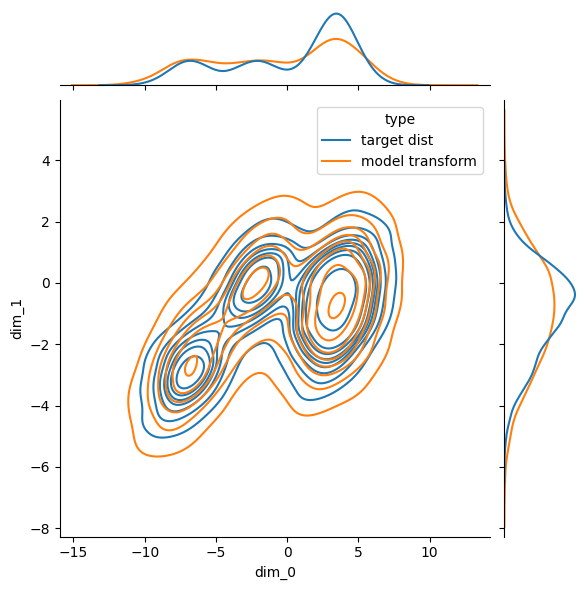

trail: 0 m step: 7 kl_test: 0.2272477149963379


  2%|▏         | 100/6000 [00:29<32:34,  3.02it/s]

trail: 0 m step: 8 Loss: 0.18263006210327148  L_n: 0.16336584091186523  kld: 0.001926422119140625 KLD1: 0.17278149724006653 KLD2: 0.131989985704422


  3%|▎         | 200/6000 [00:59<31:13,  3.10it/s]

trail: 0 m step: 8 Loss: 0.21226072311401367  L_n: 0.18904829025268555  kld: 0.0023212432861328125 KLD1: 0.17111141979694366 KLD2: 0.12148381024599075


  5%|▌         | 300/6000 [01:28<30:57,  3.07it/s]

trail: 0 m step: 8 Loss: 0.18654584884643555  L_n: 0.16486406326293945  kld: 0.0021681785583496094 KLD1: 0.16977250576019287 KLD2: 0.13123732805252075


  7%|▋         | 400/6000 [01:58<30:42,  3.04it/s]

trail: 0 m step: 8 Loss: 0.2004108428955078  L_n: 0.1770792007446289  kld: 0.0023331642150878906 KLD1: 0.1716967523097992 KLD2: 0.13652482628822327


  8%|▊         | 500/6000 [02:27<29:35,  3.10it/s]

trail: 0 m step: 8 Loss: 0.19884157180786133  L_n: 0.17311620712280273  kld: 0.0025725364685058594 KLD1: 0.16993212699890137 KLD2: 0.13379526138305664


 10%|█         | 600/6000 [02:56<29:03,  3.10it/s]

trail: 0 m step: 8 Loss: 0.1963667869567871  L_n: 0.1699070930480957  kld: 0.0026459693908691406 KLD1: 0.16826732456684113 KLD2: 0.12245159596204758


 12%|█▏        | 700/6000 [03:26<28:37,  3.09it/s]

trail: 0 m step: 8 Loss: 0.1934351921081543  L_n: 0.1740565299987793  kld: 0.0019378662109375 KLD1: 0.17530865967273712 KLD2: 0.12281310558319092


 13%|█▎        | 800/6000 [03:55<27:56,  3.10it/s]

trail: 0 m step: 8 Loss: 0.18650579452514648  L_n: 0.17119455337524414  kld: 0.0015311241149902344 KLD1: 0.17779457569122314 KLD2: 0.13453319668769836


 15%|█▌        | 900/6000 [04:25<27:26,  3.10it/s]

trail: 0 m step: 8 Loss: 0.19489669799804688  L_n: 0.1685800552368164  kld: 0.002631664276123047 KLD1: 0.1680546998977661 KLD2: 0.13668251037597656


 17%|█▋        | 1000/6000 [04:54<26:53,  3.10it/s]

trail: 0 m step: 8 Loss: 0.21058177947998047  L_n: 0.17017459869384766  kld: 0.004040718078613281 KLD1: 0.1531655192375183 KLD2: 0.1298242211341858


 18%|█▊        | 1100/6000 [05:23<26:20,  3.10it/s]

trail: 0 m step: 8 Loss: 0.19687509536743164  L_n: 0.1667008399963379  kld: 0.003017425537109375 KLD1: 0.1672709584236145 KLD2: 0.12945155799388885


 20%|██        | 1200/6000 [05:53<25:54,  3.09it/s]

trail: 0 m step: 8 Loss: 0.1901407241821289  L_n: 0.16788673400878906  kld: 0.0022253990173339844 KLD1: 0.17056386172771454 KLD2: 0.12357763200998306


 22%|██▏       | 1300/6000 [06:23<25:15,  3.10it/s]

trail: 0 m step: 8 Loss: 0.18361568450927734  L_n: 0.1594066619873047  kld: 0.0024209022521972656 KLD1: 0.1659242808818817 KLD2: 0.13023988902568817


 23%|██▎       | 1400/6000 [06:52<24:45,  3.10it/s]

trail: 0 m step: 8 Loss: 0.18743562698364258  L_n: 0.16585397720336914  kld: 0.0021581649780273438 KLD1: 0.17304620146751404 KLD2: 0.12122789025306702


 25%|██▌       | 1500/6000 [07:21<24:16,  3.09it/s]

trail: 0 m step: 8 Loss: 0.19133853912353516  L_n: 0.16315269470214844  kld: 0.002818584442138672 KLD1: 0.16372917592525482 KLD2: 0.12749531865119934


 27%|██▋       | 1600/6000 [07:51<23:45,  3.09it/s]

trail: 0 m step: 8 Loss: 0.19385194778442383  L_n: 0.1605973243713379  kld: 0.0033254623413085938 KLD1: 0.16096484661102295 KLD2: 0.12654198706150055


 28%|██▊       | 1700/6000 [08:20<23:02,  3.11it/s]

trail: 0 m step: 8 Loss: 0.20071887969970703  L_n: 0.16680145263671875  kld: 0.003391742706298828 KLD1: 0.15821249783039093 KLD2: 0.1351684182882309


 30%|███       | 1800/6000 [08:50<22:28,  3.11it/s]

trail: 0 m step: 8 Loss: 0.20401763916015625  L_n: 0.16663837432861328  kld: 0.003737926483154297 KLD1: 0.15839150547981262 KLD2: 0.12201008200645447


 32%|███▏      | 1900/6000 [09:20<22:06,  3.09it/s]

trail: 0 m step: 8 Loss: 0.19774627685546875  L_n: 0.17935943603515625  kld: 0.00183868408203125 KLD1: 0.17339731752872467 KLD2: 0.12836122512817383


 33%|███▎      | 2000/6000 [09:49<21:32,  3.10it/s]

trail: 0 m step: 8 Loss: 0.19058990478515625  L_n: 0.16567039489746094  kld: 0.0024919509887695312 KLD1: 0.16966600716114044 KLD2: 0.12206976860761642


 35%|███▌      | 2100/6000 [10:18<21:03,  3.09it/s]

trail: 0 m step: 8 Loss: 0.1878652572631836  L_n: 0.17300701141357422  kld: 0.0014858245849609375 KLD1: 0.17770156264305115 KLD2: 0.12187933176755905


 37%|███▋      | 2200/6000 [10:48<20:28,  3.09it/s]

trail: 0 m step: 8 Loss: 0.17865848541259766  L_n: 0.1602954864501953  kld: 0.0018362998962402344 KLD1: 0.17043349146842957 KLD2: 0.13126780092716217


 38%|███▊      | 2300/6000 [11:17<19:55,  3.09it/s]

trail: 0 m step: 8 Loss: 0.20828008651733398  L_n: 0.17418622970581055  kld: 0.0034093856811523438 KLD1: 0.1589493602514267 KLD2: 0.1313209980726242


 40%|████      | 2400/6000 [11:46<19:51,  3.02it/s]

trail: 0 m step: 8 Loss: 0.1760101318359375  L_n: 0.16872882843017578  kld: 0.0007281303405761719 KLD1: 0.1851852685213089 KLD2: 0.13631987571716309


 42%|████▏     | 2500/6000 [12:16<18:58,  3.07it/s]

trail: 0 m step: 8 Loss: 0.21642589569091797  L_n: 0.17751598358154297  kld: 0.0038909912109375 KLD1: 0.15514785051345825 KLD2: 0.12653475999832153


 43%|████▎     | 2600/6000 [12:45<18:35,  3.05it/s]

trail: 0 m step: 8 Loss: 0.1932849884033203  L_n: 0.16562843322753906  kld: 0.002765655517578125 KLD1: 0.1646803915500641 KLD2: 0.12582984566688538


 45%|████▌     | 2700/6000 [13:15<18:03,  3.04it/s]

trail: 0 m step: 8 Loss: 0.19156932830810547  L_n: 0.16781330108642578  kld: 0.0023756027221679688 KLD1: 0.16959983110427856 KLD2: 0.1311696469783783


 47%|████▋     | 2800/6000 [13:44<17:11,  3.10it/s]

trail: 0 m step: 8 Loss: 0.1816391944885254  L_n: 0.16000986099243164  kld: 0.002162933349609375 KLD1: 0.170541450381279 KLD2: 0.12187051773071289


 48%|████▊     | 2900/6000 [14:14<16:54,  3.05it/s]

trail: 0 m step: 8 Loss: 0.202178955078125  L_n: 0.17388343811035156  kld: 0.0028295516967773438 KLD1: 0.1640150398015976 KLD2: 0.12309694290161133


 50%|█████     | 3000/6000 [14:43<16:09,  3.09it/s]

trail: 0 m step: 8 Loss: 0.1840653419494629  L_n: 0.16031408309936523  kld: 0.0023751258850097656 KLD1: 0.17016078531742096 KLD2: 0.12181519716978073


 52%|█████▏    | 3100/6000 [15:13<15:57,  3.03it/s]

trail: 0 m step: 8 Loss: 0.17929410934448242  L_n: 0.15697336196899414  kld: 0.002232074737548828 KLD1: 0.17363029718399048 KLD2: 0.11871017515659332


 53%|█████▎    | 3200/6000 [15:42<15:03,  3.10it/s]

trail: 0 m step: 8 Loss: 0.20278501510620117  L_n: 0.17562437057495117  kld: 0.002716064453125 KLD1: 0.16363336145877838 KLD2: 0.131565660238266


 55%|█████▌    | 3300/6000 [16:12<14:31,  3.10it/s]

trail: 0 m step: 8 Loss: 0.19968891143798828  L_n: 0.1752033233642578  kld: 0.002448558807373047 KLD1: 0.1678932011127472 KLD2: 0.12625974416732788


 57%|█████▋    | 3400/6000 [16:41<13:58,  3.10it/s]

trail: 0 m step: 8 Loss: 0.20467519760131836  L_n: 0.18074750900268555  kld: 0.0023927688598632812 KLD1: 0.16907966136932373 KLD2: 0.1223505437374115


 58%|█████▊    | 3500/6000 [17:10<13:27,  3.10it/s]

trail: 0 m step: 8 Loss: 0.19957304000854492  L_n: 0.17112970352172852  kld: 0.0028443336486816406 KLD1: 0.16604942083358765 KLD2: 0.1319105625152588


 60%|██████    | 3600/6000 [17:40<12:53,  3.10it/s]

trail: 0 m step: 8 Loss: 0.20157909393310547  L_n: 0.17633533477783203  kld: 0.0025243759155273438 KLD1: 0.1649588793516159 KLD2: 0.12326545268297195


 62%|██████▏   | 3700/6000 [18:09<12:37,  3.04it/s]

trail: 0 m step: 8 Loss: 0.17939424514770508  L_n: 0.15346860885620117  kld: 0.0025925636291503906 KLD1: 0.1668359637260437 KLD2: 0.1275663822889328


 63%|██████▎   | 3800/6000 [18:39<11:51,  3.09it/s]

trail: 0 m step: 8 Loss: 0.19640111923217773  L_n: 0.17259740829467773  kld: 0.00238037109375 KLD1: 0.1688620001077652 KLD2: 0.12314064800739288


 65%|██████▌   | 3900/6000 [19:08<11:23,  3.07it/s]

trail: 0 m step: 8 Loss: 0.19963550567626953  L_n: 0.1731853485107422  kld: 0.0026450157165527344 KLD1: 0.1668930947780609 KLD2: 0.11876657605171204


 67%|██████▋   | 4000/6000 [19:38<10:47,  3.09it/s]

trail: 0 m step: 8 Loss: 0.20030450820922852  L_n: 0.16949129104614258  kld: 0.0030813217163085938 KLD1: 0.1611817628145218 KLD2: 0.1274118721485138


 68%|██████▊   | 4100/6000 [20:07<10:13,  3.10it/s]

trail: 0 m step: 8 Loss: 0.16355323791503906  L_n: 0.1533679962158203  kld: 0.001018524169921875 KLD1: 0.18217670917510986 KLD2: 0.13294583559036255


 70%|███████   | 4200/6000 [20:37<09:41,  3.09it/s]

trail: 0 m step: 8 Loss: 0.18199872970581055  L_n: 0.15738439559936523  kld: 0.0024614334106445312 KLD1: 0.16625022888183594 KLD2: 0.12422943860292435


 72%|███████▏  | 4300/6000 [21:06<09:14,  3.06it/s]

trail: 0 m step: 8 Loss: 0.1895909309387207  L_n: 0.16686010360717773  kld: 0.002273082733154297 KLD1: 0.1693018078804016 KLD2: 0.1249871551990509


 73%|███████▎  | 4400/6000 [21:36<08:34,  3.11it/s]

trail: 0 m step: 8 Loss: 0.18588590621948242  L_n: 0.17009782791137695  kld: 0.0015788078308105469 KLD1: 0.1740405410528183 KLD2: 0.12787064909934998


 75%|███████▌  | 4500/6000 [22:05<08:04,  3.10it/s]

trail: 0 m step: 8 Loss: 0.17537641525268555  L_n: 0.15869665145874023  kld: 0.0016679763793945312 KLD1: 0.17580734193325043 KLD2: 0.12274180352687836


 77%|███████▋  | 4600/6000 [22:35<07:31,  3.10it/s]

trail: 0 m step: 8 Loss: 0.1914691925048828  L_n: 0.16182422637939453  kld: 0.002964496612548828 KLD1: 0.16293565928936005 KLD2: 0.1234351322054863


 78%|███████▊  | 4700/6000 [23:04<06:58,  3.10it/s]

trail: 0 m step: 8 Loss: 0.1875925064086914  L_n: 0.17590999603271484  kld: 0.0011682510375976562 KLD1: 0.18014661967754364 KLD2: 0.12991945445537567


 80%|████████  | 4800/6000 [23:33<06:26,  3.10it/s]

trail: 0 m step: 8 Loss: 0.19703245162963867  L_n: 0.16739225387573242  kld: 0.002964019775390625 KLD1: 0.16134203970432281 KLD2: 0.12366000562906265


 82%|████████▏ | 4900/6000 [24:03<05:55,  3.09it/s]

trail: 0 m step: 8 Loss: 0.1935291290283203  L_n: 0.17067909240722656  kld: 0.002285003662109375 KLD1: 0.16951321065425873 KLD2: 0.12843185663223267


 83%|████████▎ | 5000/6000 [24:33<05:23,  3.09it/s]

trail: 0 m step: 8 Loss: 0.18755626678466797  L_n: 0.1668376922607422  kld: 0.002071857452392578 KLD1: 0.1724315881729126 KLD2: 0.1285899430513382


 85%|████████▌ | 5100/6000 [25:02<04:50,  3.10it/s]

trail: 0 m step: 8 Loss: 0.18290376663208008  L_n: 0.1597914695739746  kld: 0.002311229705810547 KLD1: 0.16717030107975006 KLD2: 0.13077114522457123


 87%|████████▋ | 5200/6000 [25:32<04:17,  3.11it/s]

trail: 0 m step: 8 Loss: 0.1930069923400879  L_n: 0.17271757125854492  kld: 0.002028942108154297 KLD1: 0.16970601677894592 KLD2: 0.12284736335277557


 88%|████████▊ | 5300/6000 [26:01<03:46,  3.09it/s]

trail: 0 m step: 8 Loss: 0.20269489288330078  L_n: 0.1864013671875  kld: 0.0016293525695800781 KLD1: 0.17605656385421753 KLD2: 0.12828630208969116


 90%|█████████ | 5400/6000 [26:31<03:14,  3.09it/s]

trail: 0 m step: 8 Loss: 0.17449331283569336  L_n: 0.16323041915893555  kld: 0.0011262893676757812 KLD1: 0.18026132881641388 KLD2: 0.13037936389446259


 92%|█████████▏| 5500/6000 [27:00<02:41,  3.10it/s]

trail: 0 m step: 8 Loss: 0.20209169387817383  L_n: 0.17763948440551758  kld: 0.002445220947265625 KLD1: 0.16756534576416016 KLD2: 0.12408927828073502


 93%|█████████▎| 5600/6000 [27:30<02:09,  3.09it/s]

trail: 0 m step: 8 Loss: 0.19255733489990234  L_n: 0.16686534881591797  kld: 0.0025691986083984375 KLD1: 0.17050419747829437 KLD2: 0.12633968889713287


 95%|█████████▌| 5700/6000 [27:59<01:36,  3.09it/s]

trail: 0 m step: 8 Loss: 0.18268251419067383  L_n: 0.16298913955688477  kld: 0.0019693374633789062 KLD1: 0.1713632494211197 KLD2: 0.1315072774887085


 97%|█████████▋| 5800/6000 [28:29<01:04,  3.10it/s]

trail: 0 m step: 8 Loss: 0.18706274032592773  L_n: 0.16083669662475586  kld: 0.0026226043701171875 KLD1: 0.1666480451822281 KLD2: 0.12724106013774872


 98%|█████████▊| 5900/6000 [28:58<00:32,  3.10it/s]

trail: 0 m step: 8 Loss: 0.18399286270141602  L_n: 0.16086626052856445  kld: 0.0023126602172851562 KLD1: 0.16756542026996613 KLD2: 0.12790454924106598


100%|██████████| 6000/6000 [29:28<00:00,  3.39it/s]

trail: 0 m step: 8 Loss: 0.17778491973876953  L_n: 0.1521453857421875  kld: 0.002563953399658203 KLD1: 0.1650209277868271 KLD2: 0.12534943222999573



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


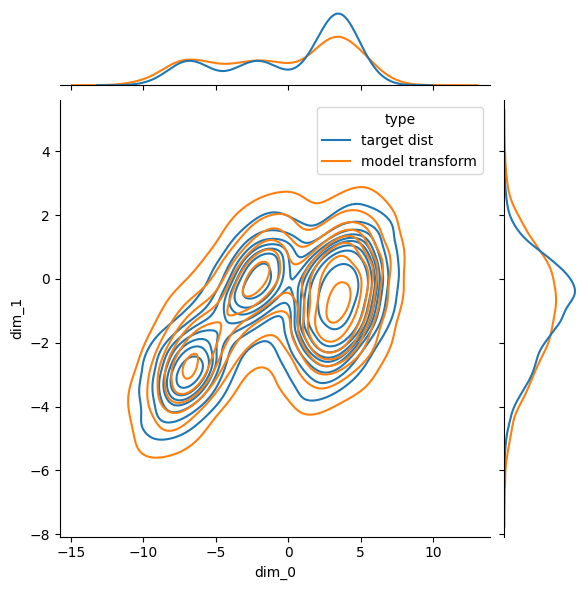

trail: 0 m step: 8 kl_test: 0.17447566986083984


  2%|▏         | 100/6000 [00:29<32:28,  3.03it/s]

trail: 0 m step: 9 Loss: 0.14107036590576172  L_n: 0.1266031265258789  kld: 0.0014467239379882812 KLD1: 0.13338422775268555 KLD2: 0.10631830990314484


  3%|▎         | 200/6000 [00:58<31:13,  3.10it/s]

trail: 0 m step: 9 Loss: 0.16510295867919922  L_n: 0.1486043930053711  kld: 0.0016498565673828125 KLD1: 0.1340050995349884 KLD2: 0.09694182127714157


  5%|▌         | 300/6000 [01:28<32:45,  2.90it/s]

trail: 0 m step: 9 Loss: 0.14388036727905273  L_n: 0.12848329544067383  kld: 0.0015397071838378906 KLD1: 0.13307350873947144 KLD2: 0.10638449341058731


  7%|▋         | 400/6000 [01:57<30:04,  3.10it/s]

trail: 0 m step: 9 Loss: 0.15595197677612305  L_n: 0.1392674446105957  kld: 0.0016684532165527344 KLD1: 0.13425284624099731 KLD2: 0.11107379198074341


  8%|▊         | 500/6000 [02:27<29:38,  3.09it/s]

trail: 0 m step: 9 Loss: 0.15413475036621094  L_n: 0.13492298126220703  kld: 0.0019211769104003906 KLD1: 0.13339880108833313 KLD2: 0.10848697274923325


 10%|█         | 600/6000 [02:56<30:36,  2.94it/s]

trail: 0 m step: 9 Loss: 0.15239286422729492  L_n: 0.1313023567199707  kld: 0.002109050750732422 KLD1: 0.13068053126335144 KLD2: 0.09776409715414047


 12%|█▏        | 700/6000 [03:26<28:23,  3.11it/s]

trail: 0 m step: 9 Loss: 0.1517486572265625  L_n: 0.13532638549804688  kld: 0.0016422271728515625 KLD1: 0.1355586051940918 KLD2: 0.09809621423482895


 13%|█▎        | 800/6000 [03:55<28:13,  3.07it/s]

trail: 0 m step: 9 Loss: 0.14328432083129883  L_n: 0.13361883163452148  kld: 0.0009665489196777344 KLD1: 0.13972096145153046 KLD2: 0.10929587483406067


 15%|█▌        | 900/6000 [04:24<27:28,  3.09it/s]

trail: 0 m step: 9 Loss: 0.15182113647460938  L_n: 0.13213729858398438  kld: 0.0019683837890625 KLD1: 0.13054309785366058 KLD2: 0.11126071214675903


 17%|█▋        | 1000/6000 [04:54<26:59,  3.09it/s]

trail: 0 m step: 9 Loss: 0.16492795944213867  L_n: 0.1321883201599121  kld: 0.0032739639282226562 KLD1: 0.1175675168633461 KLD2: 0.10474027693271637


 18%|█▊        | 1100/6000 [05:23<26:25,  3.09it/s]

trail: 0 m step: 9 Loss: 0.1542506217956543  L_n: 0.13013696670532227  kld: 0.002411365509033203 KLD1: 0.1316540688276291 KLD2: 0.1045975312590599


 20%|██        | 1200/6000 [05:53<25:48,  3.10it/s]

trail: 0 m step: 9 Loss: 0.14615488052368164  L_n: 0.13007116317749023  kld: 0.0016083717346191406 KLD1: 0.13305161893367767 KLD2: 0.09930827468633652


 22%|██▏       | 1300/6000 [06:22<25:43,  3.04it/s]

trail: 0 m step: 9 Loss: 0.14238500595092773  L_n: 0.1251664161682129  kld: 0.0017218589782714844 KLD1: 0.1295354664325714 KLD2: 0.10587257146835327


 23%|██▎       | 1400/6000 [06:52<24:48,  3.09it/s]

trail: 0 m step: 9 Loss: 0.14500141143798828  L_n: 0.12917518615722656  kld: 0.0015826225280761719 KLD1: 0.13495339453220367 KLD2: 0.09705771505832672


 25%|██▌       | 1500/6000 [07:21<24:22,  3.08it/s]

trail: 0 m step: 9 Loss: 0.14821195602416992  L_n: 0.12726449966430664  kld: 0.002094745635986328 KLD1: 0.1267663538455963 KLD2: 0.1030326634645462


 27%|██▋       | 1600/6000 [07:50<23:45,  3.09it/s]

trail: 0 m step: 9 Loss: 0.15043878555297852  L_n: 0.12526655197143555  kld: 0.002517223358154297 KLD1: 0.12533554434776306 KLD2: 0.10186507552862167


 28%|██▊       | 1700/6000 [08:20<23:08,  3.10it/s]

trail: 0 m step: 9 Loss: 0.15657758712768555  L_n: 0.1301560401916504  kld: 0.0026421546936035156 KLD1: 0.12164557725191116 KLD2: 0.1098368838429451


 30%|███       | 1800/6000 [08:49<22:41,  3.08it/s]

trail: 0 m step: 9 Loss: 0.15884017944335938  L_n: 0.1296863555908203  kld: 0.0029153823852539062 KLD1: 0.12242399901151657 KLD2: 0.09808135777711868


 32%|███▏      | 1900/6000 [09:18<22:06,  3.09it/s]

trail: 0 m step: 9 Loss: 0.1524181365966797  L_n: 0.1400585174560547  kld: 0.0012359619140625 KLD1: 0.13572551310062408 KLD2: 0.10339579731225967


 33%|███▎      | 2000/6000 [09:48<22:07,  3.01it/s]

trail: 0 m step: 9 Loss: 0.1491255760192871  L_n: 0.12926054000854492  kld: 0.0019865036010742188 KLD1: 0.13138815760612488 KLD2: 0.09769413620233536


 35%|███▌      | 2100/6000 [10:18<20:59,  3.10it/s]

trail: 0 m step: 9 Loss: 0.1462078094482422  L_n: 0.13534069061279297  kld: 0.0010867118835449219 KLD1: 0.1394168883562088 KLD2: 0.09758506715297699


 37%|███▋      | 2200/6000 [10:47<20:24,  3.10it/s]

trail: 0 m step: 9 Loss: 0.13611173629760742  L_n: 0.12323236465454102  kld: 0.0012879371643066406 KLD1: 0.1327303946018219 KLD2: 0.10626564919948578


 38%|███▊      | 2300/6000 [11:16<19:52,  3.10it/s]

trail: 0 m step: 9 Loss: 0.1624894142150879  L_n: 0.13553380966186523  kld: 0.0026955604553222656 KLD1: 0.12254683673381805 KLD2: 0.106321319937706


 40%|████      | 2400/6000 [11:46<19:29,  3.08it/s]

trail: 0 m step: 9 Loss: 0.1363668441772461  L_n: 0.13227558135986328  kld: 0.00040912628173828125 KLD1: 0.1443379670381546 KLD2: 0.11068500578403473


 42%|████▏     | 2500/6000 [12:15<18:55,  3.08it/s]

trail: 0 m step: 9 Loss: 0.17017889022827148  L_n: 0.13869810104370117  kld: 0.0031480789184570312 KLD1: 0.11954332888126373 KLD2: 0.10174360126256943


 43%|████▎     | 2600/6000 [12:45<18:20,  3.09it/s]

trail: 0 m step: 9 Loss: 0.15106678009033203  L_n: 0.12869834899902344  kld: 0.0022368431091308594 KLD1: 0.12709924578666687 KLD2: 0.10113976895809174


 45%|████▌     | 2700/6000 [13:14<17:47,  3.09it/s]

trail: 0 m step: 9 Loss: 0.1488785743713379  L_n: 0.13076353073120117  kld: 0.0018115043640136719 KLD1: 0.1314729005098343 KLD2: 0.10618696361780167


 47%|████▋     | 2800/6000 [13:44<17:08,  3.11it/s]

trail: 0 m step: 9 Loss: 0.13961124420166016  L_n: 0.12329864501953125  kld: 0.0016312599182128906 KLD1: 0.1326531022787094 KLD2: 0.09779004007577896


 48%|████▊     | 2900/6000 [14:13<16:43,  3.09it/s]

trail: 0 m step: 9 Loss: 0.1574382781982422  L_n: 0.13738727569580078  kld: 0.0020051002502441406 KLD1: 0.12853625416755676 KLD2: 0.09901897609233856


 50%|█████     | 3000/6000 [14:42<16:32,  3.02it/s]

trail: 0 m step: 9 Loss: 0.1410064697265625  L_n: 0.12415504455566406  kld: 0.0016851425170898438 KLD1: 0.13369710743427277 KLD2: 0.0976991206407547


 52%|█████▏    | 3100/6000 [15:12<15:42,  3.08it/s]

trail: 0 m step: 9 Loss: 0.13718032836914062  L_n: 0.12065315246582031  kld: 0.0016527175903320312 KLD1: 0.13517609238624573 KLD2: 0.09470077604055405


 53%|█████▎    | 3200/6000 [15:41<14:16,  3.27it/s]

trail: 0 m step: 9 Loss: 0.15761518478393555  L_n: 0.13631010055541992  kld: 0.0021305084228515625 KLD1: 0.1259903460741043 KLD2: 0.10627223551273346


 55%|█████▌    | 3300/6000 [16:11<14:32,  3.10it/s]

trail: 0 m step: 9 Loss: 0.15550851821899414  L_n: 0.13746023178100586  kld: 0.0018048286437988281 KLD1: 0.12983715534210205 KLD2: 0.10167981684207916


 57%|█████▋    | 3400/6000 [16:40<13:56,  3.11it/s]

trail: 0 m step: 9 Loss: 0.16007423400878906  L_n: 0.14207839965820312  kld: 0.0017995834350585938 KLD1: 0.131108820438385 KLD2: 0.09792929142713547


 58%|█████▊    | 3500/6000 [17:10<13:28,  3.09it/s]

trail: 0 m step: 9 Loss: 0.1555495262145996  L_n: 0.1339583396911621  kld: 0.00215911865234375 KLD1: 0.12878142297267914 KLD2: 0.10704341530799866


 60%|██████    | 3600/6000 [17:39<13:08,  3.04it/s]

trail: 0 m step: 9 Loss: 0.1557631492614746  L_n: 0.1374049186706543  kld: 0.0018358230590820312 KLD1: 0.1288485825061798 KLD2: 0.09920234233140945


 62%|██████▏   | 3700/6000 [18:09<12:24,  3.09it/s]

trail: 0 m step: 9 Loss: 0.13720130920410156  L_n: 0.1182708740234375  kld: 0.0018930435180664062 KLD1: 0.13091203570365906 KLD2: 0.10328211635351181


 63%|██████▎   | 3800/6000 [18:38<11:47,  3.11it/s]

trail: 0 m step: 9 Loss: 0.15302085876464844  L_n: 0.1344766616821289  kld: 0.0018544197082519531 KLD1: 0.1314336359500885 KLD2: 0.09886045008897781


 65%|██████▌   | 3900/6000 [19:08<11:38,  3.00it/s]

trail: 0 m step: 9 Loss: 0.15540695190429688  L_n: 0.13583755493164062  kld: 0.001956939697265625 KLD1: 0.12998086214065552 KLD2: 0.0948767438530922


 67%|██████▋   | 4000/6000 [19:37<10:57,  3.04it/s]

trail: 0 m step: 9 Loss: 0.15653228759765625  L_n: 0.1326141357421875  kld: 0.002391815185546875 KLD1: 0.1255078911781311 KLD2: 0.10269224643707275


 68%|██████▊   | 4100/6000 [20:06<10:26,  3.03it/s]

trail: 0 m step: 9 Loss: 0.12364912033081055  L_n: 0.11739301681518555  kld: 0.0006256103515625 KLD1: 0.14246496558189392 KLD2: 0.10759509354829788


 70%|███████   | 4200/6000 [20:36<09:42,  3.09it/s]

trail: 0 m step: 9 Loss: 0.1392383575439453  L_n: 0.12129497528076172  kld: 0.0017943382263183594 KLD1: 0.12883827090263367 KLD2: 0.09984700381755829


 72%|███████▏  | 4300/6000 [21:05<09:09,  3.09it/s]

trail: 0 m step: 9 Loss: 0.14593839645385742  L_n: 0.1296401023864746  kld: 0.0016298294067382812 KLD1: 0.1331966519355774 KLD2: 0.10072249174118042


 73%|███████▎  | 4400/6000 [21:35<08:35,  3.10it/s]

trail: 0 m step: 9 Loss: 0.14310503005981445  L_n: 0.13312482833862305  kld: 0.0009980201721191406 KLD1: 0.135887011885643 KLD2: 0.10322336107492447


 75%|███████▌  | 4500/6000 [22:05<08:15,  3.03it/s]

trail: 0 m step: 9 Loss: 0.13370990753173828  L_n: 0.122528076171875  kld: 0.0011181831359863281 KLD1: 0.13706262409687042 KLD2: 0.09842886030673981


 77%|███████▋  | 4600/6000 [22:34<07:30,  3.11it/s]

trail: 0 m step: 9 Loss: 0.148284912109375  L_n: 0.1246480941772461  kld: 0.0023636817932128906 KLD1: 0.12559203803539276 KLD2: 0.09900179505348206


 78%|███████▊  | 4700/6000 [23:04<06:59,  3.10it/s]

trail: 0 m step: 9 Loss: 0.14459943771362305  L_n: 0.13669347763061523  kld: 0.0007905960083007812 KLD1: 0.14047154784202576 KLD2: 0.10490375757217407


 80%|████████  | 4800/6000 [23:33<06:27,  3.09it/s]

trail: 0 m step: 9 Loss: 0.15201759338378906  L_n: 0.13020706176757812  kld: 0.0021810531616210938 KLD1: 0.12533631920814514 KLD2: 0.09930369257926941


 82%|████████▏ | 4900/6000 [24:02<05:54,  3.10it/s]

trail: 0 m step: 9 Loss: 0.14895868301391602  L_n: 0.1322932243347168  kld: 0.0016665458679199219 KLD1: 0.13211315870285034 KLD2: 0.10352222621440887


 83%|████████▎ | 5000/6000 [24:32<05:34,  2.99it/s]

trail: 0 m step: 9 Loss: 0.14498281478881836  L_n: 0.13021039962768555  kld: 0.0014772415161132812 KLD1: 0.13486117124557495 KLD2: 0.1037537083029747


 85%|████████▌ | 5100/6000 [25:02<04:51,  3.09it/s]

trail: 0 m step: 9 Loss: 0.14144563674926758  L_n: 0.12379789352416992  kld: 0.0017647743225097656 KLD1: 0.1287112683057785 KLD2: 0.10578081756830215


 87%|████████▋ | 5200/6000 [25:31<04:18,  3.09it/s]

trail: 0 m step: 9 Loss: 0.14965009689331055  L_n: 0.13509225845336914  kld: 0.0014557838439941406 KLD1: 0.13230000436306 KLD2: 0.09874378889799118


 88%|████████▊ | 5300/6000 [26:01<03:48,  3.06it/s]

trail: 0 m step: 9 Loss: 0.15797138214111328  L_n: 0.14643192291259766  kld: 0.0011539459228515625 KLD1: 0.13728217780590057 KLD2: 0.10349631309509277


 90%|█████████ | 5400/6000 [26:30<03:14,  3.09it/s]

trail: 0 m step: 9 Loss: 0.13367986679077148  L_n: 0.12648439407348633  kld: 0.0007195472717285156 KLD1: 0.14114713668823242 KLD2: 0.10535138845443726


 92%|█████████▏| 5500/6000 [27:00<03:00,  2.78it/s]

trail: 0 m step: 9 Loss: 0.1569528579711914  L_n: 0.1388378143310547  kld: 0.0018115043640136719 KLD1: 0.13052205741405487 KLD2: 0.09986449033021927


 93%|█████████▎| 5600/6000 [27:29<02:08,  3.10it/s]

trail: 0 m step: 9 Loss: 0.14869928359985352  L_n: 0.1298069953918457  kld: 0.0018892288208007812 KLD1: 0.13338324427604675 KLD2: 0.10185512900352478


 95%|█████████▌| 5700/6000 [27:59<01:36,  3.10it/s]

trail: 0 m step: 9 Loss: 0.14061355590820312  L_n: 0.12707138061523438  kld: 0.001354217529296875 KLD1: 0.133945032954216 KLD2: 0.10647371411323547


 97%|█████████▋| 5800/6000 [28:28<01:05,  3.08it/s]

trail: 0 m step: 9 Loss: 0.14381647109985352  L_n: 0.12422800064086914  kld: 0.0019588470458984375 KLD1: 0.12965965270996094 KLD2: 0.10260447859764099


 98%|█████████▊| 5900/6000 [28:57<00:32,  3.10it/s]

trail: 0 m step: 9 Loss: 0.14116716384887695  L_n: 0.12406778335571289  kld: 0.0017099380493164062 KLD1: 0.13051417469978333 KLD2: 0.10341765731573105


100%|██████████| 6000/6000 [29:27<00:00,  3.39it/s]

trail: 0 m step: 9 Loss: 0.13642024993896484  L_n: 0.11709403991699219  kld: 0.0019326210021972656 KLD1: 0.1277642548084259 KLD2: 0.10095180571079254



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


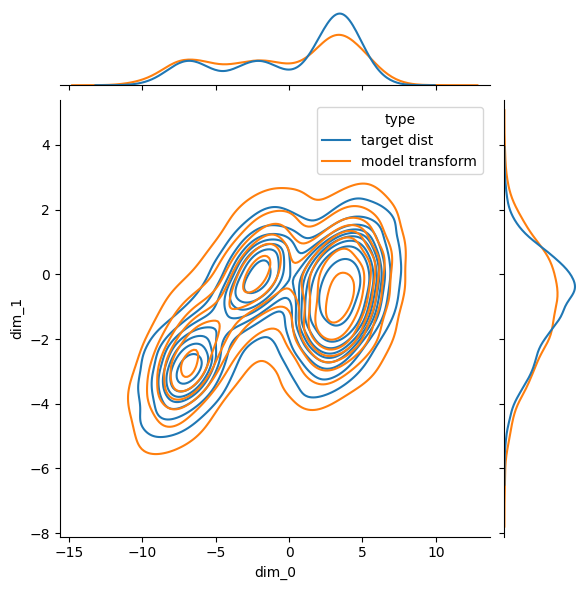

trail: 0 m step: 9 kl_test: 0.1355910301208496


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer_lr_input = optimizer_lr * (outer_lr_factor**mirror_itr)
  optimizer = torch.optim.Adam(model2.parameters(), lr=optimizer_lr_input, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = eta
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


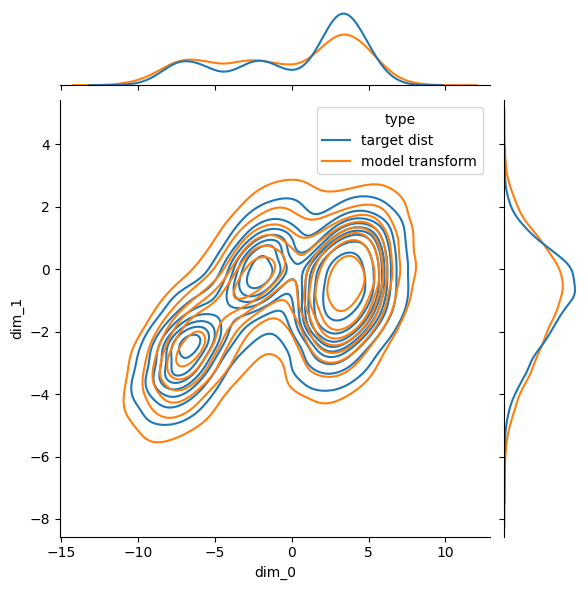

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

  2%|▏         | 100/6000 [00:29<32:07,  3.06it/s]

trail: 0 m step: 0 Loss: 0.11010074615478516  L_n: 0.09980106353759766  kld: 0.00102996826171875 KLD1: 0.1041456013917923 KLD2: 0.08635266870260239


  3%|▎         | 200/6000 [00:59<31:17,  3.09it/s]

trail: 0 m step: 0 Loss: 0.13046932220458984  L_n: 0.1183481216430664  kld: 0.0012121200561523438 KLD1: 0.10586467385292053 KLD2: 0.07765896618366241


  5%|▌         | 300/6000 [01:28<30:39,  3.10it/s]

trail: 0 m step: 0 Loss: 0.11200952529907227  L_n: 0.10109949111938477  kld: 0.00109100341796875 KLD1: 0.10546142607927322 KLD2: 0.08671597391366959


  7%|▋         | 400/6000 [01:57<30:15,  3.09it/s]

trail: 0 m step: 0 Loss: 0.12354898452758789  L_n: 0.11082696914672852  kld: 0.0012722015380859375 KLD1: 0.10634586960077286 KLD2: 0.0910211130976677


  8%|▊         | 500/6000 [02:27<29:39,  3.09it/s]

trail: 0 m step: 0 Loss: 0.12157630920410156  L_n: 0.10608386993408203  kld: 0.0015492439270019531 KLD1: 0.10538085550069809 KLD2: 0.0881045013666153


 10%|█         | 600/6000 [02:56<29:03,  3.10it/s]

trail: 0 m step: 0 Loss: 0.11978006362915039  L_n: 0.10219907760620117  kld: 0.0017580986022949219 KLD1: 0.10275649279356003 KLD2: 0.0785205289721489


 12%|█▏        | 700/6000 [03:26<28:36,  3.09it/s]

trail: 0 m step: 0 Loss: 0.1195673942565918  L_n: 0.10641622543334961  kld: 0.0013151168823242188 KLD1: 0.10583760589361191 KLD2: 0.07887744903564453


 13%|█▎        | 800/6000 [03:56<28:01,  3.09it/s]

trail: 0 m step: 0 Loss: 0.11113739013671875  L_n: 0.10524368286132812  kld: 0.0005893707275390625 KLD1: 0.11045729368925095 KLD2: 0.08893425017595291


 15%|█▌        | 900/6000 [04:25<27:36,  3.08it/s]

trail: 0 m step: 0 Loss: 0.11987066268920898  L_n: 0.10462617874145508  kld: 0.0015244483947753906 KLD1: 0.1022070050239563 KLD2: 0.09108352661132812


 17%|█▋        | 1000/6000 [04:54<26:45,  3.11it/s]

trail: 0 m step: 0 Loss: 0.13126373291015625  L_n: 0.10403633117675781  kld: 0.0027227401733398438 KLD1: 0.0908367782831192 KLD2: 0.08497776836156845


 18%|█▊        | 1100/6000 [05:24<26:24,  3.09it/s]

trail: 0 m step: 0 Loss: 0.12152719497680664  L_n: 0.10181474685668945  kld: 0.0019712448120117188 KLD1: 0.10401138663291931 KLD2: 0.0848677009344101


 20%|██        | 1201/6000 [05:53<22:04,  3.62it/s]

trail: 0 m step: 0 Loss: 0.11350679397583008  L_n: 0.10101842880249023  kld: 0.0012488365173339844 KLD1: 0.10405056923627853 KLD2: 0.07991683483123779


 22%|██▏       | 1300/6000 [06:22<25:15,  3.10it/s]

trail: 0 m step: 0 Loss: 0.11128520965576172  L_n: 0.09920692443847656  kld: 0.0012078285217285156 KLD1: 0.102658711373806 KLD2: 0.08668876439332962


 23%|██▎       | 1400/6000 [06:52<24:47,  3.09it/s]

trail: 0 m step: 0 Loss: 0.11328697204589844  L_n: 0.1014852523803711  kld: 0.0011801719665527344 KLD1: 0.10632932186126709 KLD2: 0.07806196063756943


 25%|██▌       | 1500/6000 [07:21<24:17,  3.09it/s]

trail: 0 m step: 0 Loss: 0.11713743209838867  L_n: 0.10003805160522461  kld: 0.0017099380493164062 KLD1: 0.0991726890206337 KLD2: 0.08349654078483582


 27%|██▋       | 1600/6000 [07:51<23:41,  3.09it/s]

trail: 0 m step: 0 Loss: 0.11738824844360352  L_n: 0.09825754165649414  kld: 0.0019130706787109375 KLD1: 0.0986819788813591 KLD2: 0.08244315534830093


 28%|██▊       | 1700/6000 [08:20<23:11,  3.09it/s]

trail: 0 m step: 0 Loss: 0.12352752685546875  L_n: 0.10246086120605469  kld: 0.0021066665649414062 KLD1: 0.09409026801586151 KLD2: 0.0895000621676445


 30%|███       | 1800/6000 [08:49<22:34,  3.10it/s]

trail: 0 m step: 0 Loss: 0.1260690689086914  L_n: 0.10277557373046875  kld: 0.0023293495178222656 KLD1: 0.09649540483951569 KLD2: 0.0793038085103035


 32%|███▏      | 1900/6000 [09:19<22:22,  3.05it/s]

trail: 0 m step: 0 Loss: 0.11864948272705078  L_n: 0.10995197296142578  kld: 0.0008697509765625 KLD1: 0.10686154663562775 KLD2: 0.08350449800491333


 33%|███▎      | 2000/6000 [09:48<21:31,  3.10it/s]

trail: 0 m step: 0 Loss: 0.1175837516784668  L_n: 0.10182428359985352  kld: 0.0015759468078613281 KLD1: 0.10237162560224533 KLD2: 0.07854076474905014


 35%|███▌      | 2100/6000 [10:18<20:11,  3.22it/s]

trail: 0 m step: 0 Loss: 0.11425209045410156  L_n: 0.10556888580322266  kld: 0.0008683204650878906 KLD1: 0.10944301635026932 KLD2: 0.07757368683815002


 37%|███▋      | 2200/6000 [10:47<20:31,  3.09it/s]

trail: 0 m step: 0 Loss: 0.1045985221862793  L_n: 0.09561491012573242  kld: 0.0008983612060546875 KLD1: 0.10465646535158157 KLD2: 0.08644852042198181


 38%|███▊      | 2300/6000 [11:17<19:54,  3.10it/s]

trail: 0 m step: 0 Loss: 0.1286311149597168  L_n: 0.10724973678588867  kld: 0.0021381378173828125 KLD1: 0.09535098820924759 KLD2: 0.08669828623533249


 40%|████      | 2400/6000 [11:47<19:30,  3.08it/s]

trail: 0 m step: 0 Loss: 0.10662031173706055  L_n: 0.1047368049621582  kld: 0.00018835067749023438 KLD1: 0.11392770707607269 KLD2: 0.09064166247844696


 42%|████▏     | 2500/6000 [12:16<18:53,  3.09it/s]

trail: 0 m step: 0 Loss: 0.1356959342956543  L_n: 0.10975122451782227  kld: 0.002594470977783203 KLD1: 0.09347102791070938 KLD2: 0.08241106569766998


 43%|████▎     | 2600/6000 [12:46<18:18,  3.09it/s]

trail: 0 m step: 0 Loss: 0.11891889572143555  L_n: 0.10077047348022461  kld: 0.0018148422241210938 KLD1: 0.09926629066467285 KLD2: 0.08182958513498306


 45%|████▌     | 2700/6000 [13:16<17:47,  3.09it/s]

trail: 0 m step: 0 Loss: 0.11766433715820312  L_n: 0.1030874252319336  kld: 0.0014576911926269531 KLD1: 0.10290193557739258 KLD2: 0.0864921361207962


 47%|████▋     | 2800/6000 [13:45<17:13,  3.10it/s]

trail: 0 m step: 0 Loss: 0.10906648635864258  L_n: 0.0962061882019043  kld: 0.0012860298156738281 KLD1: 0.10429642349481583 KLD2: 0.0784994512796402


 48%|████▊     | 2900/6000 [14:15<16:38,  3.11it/s]

trail: 0 m step: 0 Loss: 0.12379026412963867  L_n: 0.10882234573364258  kld: 0.0014967918395996094 KLD1: 0.10140302777290344 KLD2: 0.0797833725810051


 50%|█████     | 3000/6000 [14:44<16:11,  3.09it/s]

trail: 0 m step: 0 Loss: 0.1084127426147461  L_n: 0.09641075134277344  kld: 0.0012001991271972656 KLD1: 0.10636359453201294 KLD2: 0.07869069278240204


 52%|█████▏    | 3100/6000 [15:13<15:35,  3.10it/s]

trail: 0 m step: 0 Loss: 0.10669946670532227  L_n: 0.09374856948852539  kld: 0.0012950897216796875 KLD1: 0.10740088671445847 KLD2: 0.0759296715259552


 53%|█████▎    | 3200/6000 [15:42<14:11,  3.29it/s]

trail: 0 m step: 0 Loss: 0.12429618835449219  L_n: 0.10782146453857422  kld: 0.0016474723815917969 KLD1: 0.09860196709632874 KLD2: 0.08663754910230637


 55%|█████▌    | 3300/6000 [16:12<14:33,  3.09it/s]

trail: 0 m step: 0 Loss: 0.12291622161865234  L_n: 0.10902595520019531  kld: 0.0013890266418457031 KLD1: 0.10191547870635986 KLD2: 0.08237927407026291


 57%|█████▋    | 3400/6000 [16:41<13:59,  3.10it/s]

trail: 0 m step: 0 Loss: 0.12665367126464844  L_n: 0.11283016204833984  kld: 0.0013823509216308594 KLD1: 0.1026577576994896 KLD2: 0.07867621630430222


 58%|█████▊    | 3500/6000 [17:11<13:30,  3.08it/s]

trail: 0 m step: 0 Loss: 0.12284040451049805  L_n: 0.10543584823608398  kld: 0.0017404556274414062 KLD1: 0.10116809606552124 KLD2: 0.08726710826158524


 60%|██████    | 3600/6000 [17:40<12:58,  3.08it/s]

trail: 0 m step: 0 Loss: 0.12244129180908203  L_n: 0.10871315002441406  kld: 0.0013728141784667969 KLD1: 0.10146023333072662 KLD2: 0.08005684614181519


 62%|██████▏   | 3700/6000 [18:10<12:25,  3.09it/s]

trail: 0 m step: 0 Loss: 0.10619115829467773  L_n: 0.09163331985473633  kld: 0.0014557838439941406 KLD1: 0.10358782857656479 KLD2: 0.08375425636768341


 63%|██████▎   | 3800/6000 [18:39<11:53,  3.08it/s]

trail: 0 m step: 0 Loss: 0.11963891983032227  L_n: 0.10552453994750977  kld: 0.00141143798828125 KLD1: 0.10295728594064713 KLD2: 0.07969379425048828


 65%|██████▌   | 3900/6000 [19:08<11:17,  3.10it/s]

trail: 0 m step: 0 Loss: 0.12414312362670898  L_n: 0.10767316818237305  kld: 0.0016469955444335938 KLD1: 0.10264769941568375 KLD2: 0.07613157480955124


 67%|██████▋   | 4000/6000 [19:38<10:46,  3.09it/s]

trail: 0 m step: 0 Loss: 0.12375020980834961  L_n: 0.10502481460571289  kld: 0.0018725395202636719 KLD1: 0.09918104112148285 KLD2: 0.08311900496482849


 68%|██████▊   | 4100/6000 [20:07<10:15,  3.09it/s]

trail: 0 m step: 0 Loss: 0.09546995162963867  L_n: 0.09067773818969727  kld: 0.0004792213439941406 KLD1: 0.11264585703611374 KLD2: 0.0873364582657814


 70%|███████   | 4200/6000 [20:37<09:51,  3.04it/s]

trail: 0 m step: 0 Loss: 0.10760736465454102  L_n: 0.09418439865112305  kld: 0.0013422966003417969 KLD1: 0.10073359310626984 KLD2: 0.08064940571784973


 72%|███████▏  | 4300/6000 [21:06<09:11,  3.08it/s]

trail: 0 m step: 0 Loss: 0.11343955993652344  L_n: 0.10080337524414062  kld: 0.0012636184692382812 KLD1: 0.10501479357481003 KLD2: 0.08104825019836426


 73%|███████▎  | 4400/6000 [21:35<08:35,  3.10it/s]

trail: 0 m step: 0 Loss: 0.11181116104125977  L_n: 0.10538816452026367  kld: 0.0006422996520996094 KLD1: 0.10719047486782074 KLD2: 0.08373254537582397


 75%|███████▌  | 4500/6000 [22:05<08:04,  3.10it/s]

trail: 0 m step: 0 Loss: 0.10349273681640625  L_n: 0.09578227996826172  kld: 0.0007710456848144531 KLD1: 0.10771875083446503 KLD2: 0.07934380322694778


 77%|███████▋  | 4600/6000 [22:34<07:30,  3.11it/s]

trail: 0 m step: 0 Loss: 0.11657381057739258  L_n: 0.09730958938598633  kld: 0.001926422119140625 KLD1: 0.09801599383354187 KLD2: 0.07979916781187057


 78%|███████▊  | 4700/6000 [23:04<06:59,  3.10it/s]

trail: 0 m step: 0 Loss: 0.11238908767700195  L_n: 0.10684823989868164  kld: 0.0005540847778320312 KLD1: 0.11050402373075485 KLD2: 0.08531627804040909


 80%|████████  | 4800/6000 [23:33<06:35,  3.04it/s]

trail: 0 m step: 0 Loss: 0.11931705474853516  L_n: 0.10217475891113281  kld: 0.0017142295837402344 KLD1: 0.09929739683866501 KLD2: 0.08016286045312881


 82%|████████▏ | 4900/6000 [24:03<05:54,  3.10it/s]

trail: 0 m step: 0 Loss: 0.1162872314453125  L_n: 0.10393238067626953  kld: 0.0012354850769042969 KLD1: 0.10466210544109344 KLD2: 0.08388926088809967


 83%|████████▎ | 5000/6000 [24:32<05:23,  3.09it/s]

trail: 0 m step: 0 Loss: 0.11314630508422852  L_n: 0.10221719741821289  kld: 0.0010929107666015625 KLD1: 0.10719362646341324 KLD2: 0.08407694101333618


 85%|████████▌ | 5100/6000 [25:02<04:51,  3.09it/s]

trail: 0 m step: 0 Loss: 0.11054611206054688  L_n: 0.09661293029785156  kld: 0.0013933181762695312 KLD1: 0.10030560940504074 KLD2: 0.08611437678337097


 87%|████████▋ | 5200/6000 [25:31<04:21,  3.06it/s]

trail: 0 m step: 0 Loss: 0.1174764633178711  L_n: 0.1070098876953125  kld: 0.0010466575622558594 KLD1: 0.10479021072387695 KLD2: 0.07975367456674576


 88%|████████▊ | 5300/6000 [26:01<03:46,  3.09it/s]

trail: 0 m step: 0 Loss: 0.12495088577270508  L_n: 0.11671113967895508  kld: 0.000823974609375 KLD1: 0.10836932063102722 KLD2: 0.0839623510837555


 90%|█████████ | 5400/6000 [26:30<03:14,  3.09it/s]

trail: 0 m step: 0 Loss: 0.10332536697387695  L_n: 0.09865236282348633  kld: 0.0004673004150390625 KLD1: 0.11172080039978027 KLD2: 0.08561693131923676


 92%|█████████▏| 5500/6000 [26:59<02:41,  3.09it/s]

trail: 0 m step: 0 Loss: 0.12284278869628906  L_n: 0.10944366455078125  kld: 0.0013399124145507812 KLD1: 0.10312865674495697 KLD2: 0.0807858407497406


 93%|█████████▎| 5600/6000 [27:29<02:09,  3.10it/s]

trail: 0 m step: 0 Loss: 0.11701726913452148  L_n: 0.10276937484741211  kld: 0.0014247894287109375 KLD1: 0.10520390421152115 KLD2: 0.08248871564865112


 95%|█████████▌| 5700/6000 [27:58<01:37,  3.09it/s]

trail: 0 m step: 0 Loss: 0.1094212532043457  L_n: 0.09977006912231445  kld: 0.000965118408203125 KLD1: 0.10626567155122757 KLD2: 0.0865907371044159


 97%|█████████▋| 5800/6000 [28:28<01:04,  3.09it/s]

trail: 0 m step: 0 Loss: 0.11217498779296875  L_n: 0.09731197357177734  kld: 0.0014863014221191406 KLD1: 0.10210234671831131 KLD2: 0.08320526778697968


 98%|█████████▊| 5900/6000 [28:57<00:32,  3.11it/s]

trail: 0 m step: 0 Loss: 0.10936546325683594  L_n: 0.09660530090332031  kld: 0.0012760162353515625 KLD1: 0.10320810228586197 KLD2: 0.08392587304115295


100%|██████████| 6000/6000 [29:27<00:00,  3.39it/s]

trail: 0 m step: 0 Loss: 0.1062474250793457  L_n: 0.0912318229675293  kld: 0.0015015602111816406 KLD1: 0.09950191527605057 KLD2: 0.08174438774585724



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


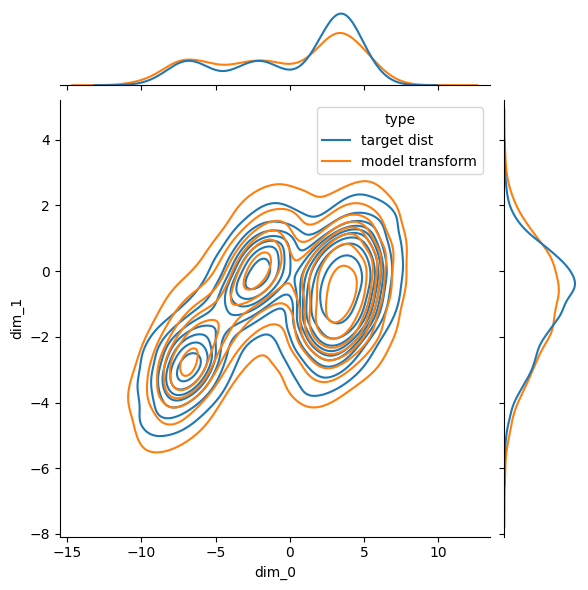

trail: 0 m step: 0 kl_test: 0.10650253295898438


  2%|▏         | 100/6000 [00:29<32:33,  3.02it/s]

trail: 0 m step: 1 Loss: 0.08467685259305513  L_n: 0.07486867904663086  kld: 0.0012750625610351562 KLD1: 0.07716339081525803 KLD2: 0.06697671860456467


  3%|▎         | 200/6000 [00:59<31:09,  3.10it/s]

trail: 0 m step: 1 Loss: 0.10031652450561523  L_n: 0.08853864669799805  kld: 0.0015311241149902344 KLD1: 0.07893244177103043 KLD2: 0.05835840851068497


  5%|▌         | 300/6000 [01:28<30:22,  3.13it/s]

trail: 0 m step: 1 Loss: 0.08643153997567984  L_n: 0.07540559768676758  kld: 0.0014333724975585938 KLD1: 0.07900793105363846 KLD2: 0.06693098694086075


  7%|▋         | 400/6000 [01:57<30:11,  3.09it/s]

trail: 0 m step: 1 Loss: 0.0955657958984375  L_n: 0.083740234375  kld: 0.001537322998046875 KLD1: 0.07988389581441879 KLD2: 0.0709981918334961


  8%|▊         | 500/6000 [02:27<29:34,  3.10it/s]

trail: 0 m step: 1 Loss: 0.09351147138155423  L_n: 0.07952547073364258  kld: 0.0018181800842285156 KLD1: 0.07880230247974396 KLD2: 0.06862267851829529


 10%|█         | 600/6000 [02:56<29:15,  3.08it/s]

trail: 0 m step: 1 Loss: 0.09152790216299203  L_n: 0.07570791244506836  kld: 0.002056598663330078 KLD1: 0.07609594613313675 KLD2: 0.05994954705238342


 12%|█▏        | 700/6000 [03:26<28:43,  3.08it/s]

trail: 0 m step: 1 Loss: 0.09309559602003831  L_n: 0.0802760124206543  kld: 0.0016665458679199219 KLD1: 0.07838709652423859 KLD2: 0.06012402102351189


 13%|█▎        | 800/6000 [03:55<28:06,  3.08it/s]

trail: 0 m step: 1 Loss: 0.08358386846689078  L_n: 0.07813692092895508  kld: 0.0007081031799316406 KLD1: 0.08277802169322968 KLD2: 0.06903687119483948


 15%|█▌        | 900/6000 [04:25<27:29,  3.09it/s]

trail: 0 m step: 1 Loss: 0.0932908424964318  L_n: 0.07887935638427734  kld: 0.0018734931945800781 KLD1: 0.07572787255048752 KLD2: 0.07088647037744522


 17%|█▋        | 1000/6000 [04:54<26:49,  3.11it/s]

trail: 0 m step: 1 Loss: 0.10140708776620719  L_n: 0.07683897018432617  kld: 0.0031938552856445312 KLD1: 0.0653751939535141 KLD2: 0.06534287333488464


 18%|█▊        | 1100/6000 [05:23<26:18,  3.10it/s]

trail: 0 m step: 1 Loss: 0.09142820651714618  L_n: 0.07514238357543945  kld: 0.002117156982421875 KLD1: 0.07885317504405975 KLD2: 0.06582029163837433


 20%|██        | 1201/6000 [05:53<22:24,  3.57it/s]

trail: 0 m step: 1 Loss: 0.0863505510183481  L_n: 0.0745396614074707  kld: 0.0015354156494140625 KLD1: 0.07755570858716965 KLD2: 0.061032719910144806


 22%|██▏       | 1300/6000 [06:22<25:15,  3.10it/s]

trail: 0 m step: 1 Loss: 0.08333870080801156  L_n: 0.07381296157836914  kld: 0.0012383460998535156 KLD1: 0.07652679085731506 KLD2: 0.06779436767101288


 23%|██▎       | 1400/6000 [06:52<24:43,  3.10it/s]

trail: 0 m step: 1 Loss: 0.08651073162372296  L_n: 0.07609367370605469  kld: 0.001354217529296875 KLD1: 0.0799318328499794 KLD2: 0.05961551517248154


 25%|██▌       | 1500/6000 [07:21<24:14,  3.09it/s]

trail: 0 m step: 1 Loss: 0.08867990053617036  L_n: 0.0739603042602539  kld: 0.0019135475158691406 KLD1: 0.07398992776870728 KLD2: 0.0647224560379982


 27%|██▋       | 1600/6000 [07:51<23:36,  3.11it/s]

trail: 0 m step: 1 Loss: 0.08918002935556266  L_n: 0.07343339920043945  kld: 0.0020470619201660156 KLD1: 0.07411269098520279 KLD2: 0.06370270997285843


 28%|██▊       | 1700/6000 [08:20<23:08,  3.10it/s]

trail: 0 m step: 1 Loss: 0.09543261161217323  L_n: 0.0763554573059082  kld: 0.002480030059814453 KLD1: 0.06828859448432922 KLD2: 0.06951552629470825


 30%|███       | 1800/6000 [08:50<22:41,  3.09it/s]

trail: 0 m step: 1 Loss: 0.09658120228694035  L_n: 0.07744169235229492  kld: 0.0024881362915039062 KLD1: 0.07230532914400101 KLD2: 0.06105397269129753


 32%|███▏      | 1900/6000 [09:19<22:03,  3.10it/s]

trail: 0 m step: 1 Loss: 0.08991061724149263  L_n: 0.08072233200073242  kld: 0.0011944770812988281 KLD1: 0.07980267703533173 KLD2: 0.06348666548728943


 33%|███▎      | 2000/6000 [09:48<21:32,  3.10it/s]

trail: 0 m step: 1 Loss: 0.08981095827542818  L_n: 0.07513904571533203  kld: 0.0019073486328125 KLD1: 0.07520325481891632 KLD2: 0.05947675555944443


 35%|███▌      | 2100/6000 [10:18<21:04,  3.08it/s]

trail: 0 m step: 1 Loss: 0.0868835082420936  L_n: 0.07912206649780273  kld: 0.0010089874267578125 KLD1: 0.08330492675304413 KLD2: 0.05949430912733078


 37%|███▋      | 2200/6000 [10:48<20:30,  3.09it/s]

trail: 0 m step: 1 Loss: 0.08072893436138447  L_n: 0.07092809677124023  kld: 0.00127410888671875 KLD1: 0.07791153341531754 KLD2: 0.06678996980190277


 38%|███▊      | 2300/6000 [11:17<19:59,  3.09it/s]

trail: 0 m step: 1 Loss: 0.09894928565392128  L_n: 0.07996749877929688  kld: 0.002467632293701172 KLD1: 0.06972383707761765 KLD2: 0.06709962338209152


 40%|████      | 2400/6000 [11:46<19:22,  3.10it/s]

trail: 0 m step: 1 Loss: 0.08073491316575271  L_n: 0.07772350311279297  kld: 0.0003914833068847656 KLD1: 0.08470729738473892 KLD2: 0.07038802653551102


 42%|████▏     | 2500/6000 [12:16<18:46,  3.11it/s]

trail: 0 m step: 1 Loss: 0.10585770240196815  L_n: 0.08277511596679688  kld: 0.0030007362365722656 KLD1: 0.06812974810600281 KLD2: 0.063141830265522


 43%|████▎     | 2600/6000 [12:45<18:24,  3.08it/s]

trail: 0 m step: 1 Loss: 0.09045938345102164  L_n: 0.07366371154785156  kld: 0.0021834373474121094 KLD1: 0.07369540631771088 KLD2: 0.06251813471317291


 45%|████▌     | 2700/6000 [13:15<17:47,  3.09it/s]

trail: 0 m step: 1 Loss: 0.09103118456326997  L_n: 0.07736063003540039  kld: 0.0017771720886230469 KLD1: 0.07583078742027283 KLD2: 0.06691604107618332


 47%|████▋     | 2800/6000 [13:45<17:13,  3.10it/s]

trail: 0 m step: 1 Loss: 0.08320966133704552  L_n: 0.07129240036010742  kld: 0.0015492439270019531 KLD1: 0.07796667516231537 KLD2: 0.05978606268763542


 48%|████▊     | 2900/6000 [14:14<16:38,  3.10it/s]

trail: 0 m step: 1 Loss: 0.09534491025484525  L_n: 0.08188343048095703  kld: 0.0017499923706054688 KLD1: 0.07584907114505768 KLD2: 0.06092624366283417


 50%|█████     | 3000/6000 [14:43<16:08,  3.10it/s]

trail: 0 m step: 1 Loss: 0.08157671414888822  L_n: 0.07092857360839844  kld: 0.0013842582702636719 KLD1: 0.07995353639125824 KLD2: 0.06005701795220375


 52%|█████▏    | 3100/6000 [15:13<15:32,  3.11it/s]

trail: 0 m step: 1 Loss: 0.07916465172400841  L_n: 0.06805801391601562  kld: 0.0014438629150390625 KLD1: 0.08115717768669128 KLD2: 0.05742287635803223


 53%|█████▎    | 3200/6000 [15:42<14:08,  3.30it/s]

trail: 0 m step: 1 Loss: 0.09636211395263672  L_n: 0.08038806915283203  kld: 0.0020766258239746094 KLD1: 0.07294107228517532 KLD2: 0.06670898199081421


 55%|█████▌    | 3300/6000 [16:12<14:28,  3.11it/s]

trail: 0 m step: 1 Loss: 0.09460577597984901  L_n: 0.08134603500366211  kld: 0.0017237663269042969 KLD1: 0.07539228349924088 KLD2: 0.0629180520772934


 57%|█████▋    | 3400/6000 [16:41<13:59,  3.10it/s]

trail: 0 m step: 1 Loss: 0.09887544925396259  L_n: 0.08545064926147461  kld: 0.0017452239990234375 KLD1: 0.07623600959777832 KLD2: 0.05986235663294792


 58%|█████▊    | 3500/6000 [17:11<13:25,  3.10it/s]

trail: 0 m step: 1 Loss: 0.09390434852013221  L_n: 0.07797431945800781  kld: 0.002070903778076172 KLD1: 0.07475636154413223 KLD2: 0.06728238612413406


 60%|██████    | 3600/6000 [17:40<12:55,  3.09it/s]

trail: 0 m step: 1 Loss: 0.09474835029015174  L_n: 0.08201313018798828  kld: 0.00165557861328125 KLD1: 0.07593715935945511 KLD2: 0.06132490187883377


 62%|██████▏   | 3700/6000 [18:10<12:18,  3.11it/s]

trail: 0 m step: 1 Loss: 0.0797578371488131  L_n: 0.066314697265625  kld: 0.0017476081848144531 KLD1: 0.07755561172962189 KLD2: 0.06437657028436661


 63%|██████▎   | 3800/6000 [18:39<11:50,  3.10it/s]

trail: 0 m step: 1 Loss: 0.09096439068134014  L_n: 0.07811546325683594  kld: 0.0016703605651855469 KLD1: 0.0766841471195221 KLD2: 0.06073929741978645


 65%|██████▌   | 3900/6000 [19:09<11:22,  3.08it/s]

trail: 0 m step: 1 Loss: 0.09665298461914062  L_n: 0.08101272583007812  kld: 0.002033233642578125 KLD1: 0.07530084997415543 KLD2: 0.057623736560344696


 67%|██████▋   | 4000/6000 [19:38<10:49,  3.08it/s]

trail: 0 m step: 1 Loss: 0.09526912982647236  L_n: 0.07893562316894531  kld: 0.0021233558654785156 KLD1: 0.0743093341588974 KLD2: 0.06391404569149017


 68%|██████▊   | 4100/6000 [20:08<10:12,  3.10it/s]

trail: 0 m step: 1 Loss: 0.07266444426316482  L_n: 0.06617212295532227  kld: 0.0008440017700195312 KLD1: 0.08485680818557739 KLD2: 0.0675170049071312


 70%|███████   | 4200/6000 [20:37<09:42,  3.09it/s]

trail: 0 m step: 1 Loss: 0.08194582278911884  L_n: 0.06937932968139648  kld: 0.0016336441040039062 KLD1: 0.07440510392189026 KLD2: 0.06187883019447327


 72%|███████▏  | 4300/6000 [21:07<09:09,  3.09it/s]

trail: 0 m step: 1 Loss: 0.08569167210505559  L_n: 0.0750875473022461  kld: 0.0013785362243652344 KLD1: 0.07852614670991898 KLD2: 0.062398094683885574


 73%|███████▎  | 4400/6000 [21:37<08:48,  3.03it/s]

trail: 0 m step: 1 Loss: 0.08637358592106746  L_n: 0.07895326614379883  kld: 0.0009646415710449219 KLD1: 0.08006271719932556 KLD2: 0.06438632309436798


 75%|███████▌  | 4500/6000 [22:06<08:04,  3.10it/s]

trail: 0 m step: 1 Loss: 0.07837394567636344  L_n: 0.07039976119995117  kld: 0.0010366439819335938 KLD1: 0.08020113408565521 KLD2: 0.06046163663268089


 77%|███████▋  | 4600/6000 [22:36<07:30,  3.10it/s]

trail: 0 m step: 1 Loss: 0.08932106311504658  L_n: 0.07203388214111328  kld: 0.002247333526611328 KLD1: 0.07195702940225601 KLD2: 0.06085597351193428


 78%|███████▊  | 4700/6000 [23:05<06:59,  3.10it/s]

trail: 0 m step: 1 Loss: 0.0859680909376878  L_n: 0.07931804656982422  kld: 0.0008645057678222656 KLD1: 0.08232462406158447 KLD2: 0.06578799337148666


 80%|████████  | 4800/6000 [23:34<06:28,  3.09it/s]

trail: 0 m step: 1 Loss: 0.09083637824425331  L_n: 0.07624149322509766  kld: 0.0018973350524902344 KLD1: 0.0732811763882637 KLD2: 0.061435360461473465


 82%|████████▏ | 4900/6000 [24:04<05:57,  3.08it/s]

trail: 0 m step: 1 Loss: 0.08838297770573543  L_n: 0.0775294303894043  kld: 0.0014109611511230469 KLD1: 0.07962596416473389 KLD2: 0.06455466151237488


 83%|████████▎ | 5000/6000 [24:33<05:25,  3.07it/s]

trail: 0 m step: 1 Loss: 0.08721758769108699  L_n: 0.07684087753295898  kld: 0.0013489723205566406 KLD1: 0.08079791069030762 KLD2: 0.06456568092107773


 85%|████████▌ | 5100/6000 [25:03<04:56,  3.04it/s]

trail: 0 m step: 1 Loss: 0.08517026901245117  L_n: 0.07177114486694336  kld: 0.0017418861389160156 KLD1: 0.07362310588359833 KLD2: 0.06675127148628235


 87%|████████▋ | 5200/6000 [25:32<04:17,  3.11it/s]

trail: 0 m step: 1 Loss: 0.08951641963078426  L_n: 0.07956886291503906  kld: 0.001293182373046875 KLD1: 0.07856923341751099 KLD2: 0.06094852089881897


 88%|████████▊ | 5300/6000 [26:02<03:47,  3.07it/s]

trail: 0 m step: 1 Loss: 0.0958861571091872  L_n: 0.08799266815185547  kld: 0.001026153564453125 KLD1: 0.080544114112854 KLD2: 0.06458353251218796


 90%|█████████ | 5400/6000 [26:31<03:15,  3.07it/s]

trail: 0 m step: 1 Loss: 0.07799104543832633  L_n: 0.07268714904785156  kld: 0.0006895065307617188 KLD1: 0.08438215404748917 KLD2: 0.06609439849853516


 92%|█████████▏| 5500/6000 [27:01<02:40,  3.11it/s]

trail: 0 m step: 1 Loss: 0.09404626259436974  L_n: 0.08217668533325195  kld: 0.0015430450439453125 KLD1: 0.07741818577051163 KLD2: 0.062060803174972534


 93%|█████████▎| 5600/6000 [27:30<02:08,  3.11it/s]

trail: 0 m step: 1 Loss: 0.09052533369797927  L_n: 0.0778341293334961  kld: 0.0016498565673828125 KLD1: 0.07905911654233932 KLD2: 0.06344278156757355


 95%|█████████▌| 5700/6000 [28:00<01:39,  3.02it/s]

trail: 0 m step: 1 Loss: 0.08333613322331355  L_n: 0.07415151596069336  kld: 0.001194000244140625 KLD1: 0.08071485161781311 KLD2: 0.06705790758132935


 97%|█████████▋| 5800/6000 [28:29<01:04,  3.10it/s]

trail: 0 m step: 1 Loss: 0.08529193584735577  L_n: 0.07215690612792969  kld: 0.0017075538635253906 KLD1: 0.07610156387090683 KLD2: 0.06393633782863617


 98%|█████████▊| 5900/6000 [28:59<00:32,  3.09it/s]

trail: 0 m step: 1 Loss: 0.08306752718411958  L_n: 0.07063674926757812  kld: 0.0016160011291503906 KLD1: 0.07735458761453629 KLD2: 0.06455424427986145


100%|██████████| 6000/6000 [29:28<00:00,  3.39it/s]

trail: 0 m step: 1 Loss: 0.08072941119854267  L_n: 0.06668472290039062  kld: 0.0018258094787597656 KLD1: 0.07357414066791534 KLD2: 0.06272277981042862



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


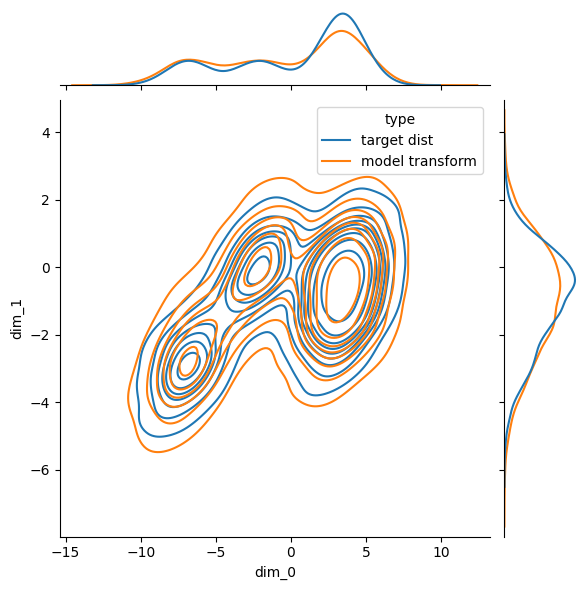

trail: 0 m step: 1 kl_test: 0.079193115234375


  2%|▏         | 100/6000 [00:29<32:17,  3.04it/s]

trail: 0 m step: 2 Loss: 0.06099599070802948  L_n: 0.05271482467651367  kld: 0.0013995170593261719 KLD1: 0.05374384671449661 KLD2: 0.04889562726020813


  3%|▎         | 200/6000 [00:59<31:10,  3.10it/s]

trail: 0 m step: 2 Loss: 0.0717650362725794  L_n: 0.0625753402709961  kld: 0.0015530586242675781 KLD1: 0.05566318333148956 KLD2: 0.04115459322929382


  5%|▌         | 300/6000 [01:28<30:35,  3.11it/s]

trail: 0 m step: 2 Loss: 0.06380403958834134  L_n: 0.053680419921875  kld: 0.0017108917236328125 KLD1: 0.055026452988386154 KLD2: 0.04861384257674217


  7%|▋         | 400/6000 [01:58<30:16,  3.08it/s]

trail: 0 m step: 2 Loss: 0.06960198159753923  L_n: 0.059484004974365234  kld: 0.0017099380493164062 KLD1: 0.05661403760313988 KLD2: 0.05201747268438339


  8%|▊         | 500/6000 [02:27<29:42,  3.09it/s]

trail: 0 m step: 2 Loss: 0.06737196939231375  L_n: 0.056345462799072266  kld: 0.0018634796142578125 KLD1: 0.05496197193861008 KLD2: 0.05051848292350769


 10%|█         | 600/6000 [02:57<28:54,  3.11it/s]

trail: 0 m step: 2 Loss: 0.06554653517593292  L_n: 0.05192422866821289  kld: 0.0023021697998046875 KLD1: 0.05233842507004738 KLD2: 0.04264926537871361


 12%|█▏        | 700/6000 [03:26<28:36,  3.09it/s]

trail: 0 m step: 2 Loss: 0.0681356142258503  L_n: 0.05675077438354492  kld: 0.0019240379333496094 KLD1: 0.05455339699983597 KLD2: 0.04296434670686722


 13%|█▎        | 800/6000 [03:56<28:32,  3.04it/s]

trail: 0 m step: 2 Loss: 0.06008630391408706  L_n: 0.05515146255493164  kld: 0.0008339881896972656 KLD1: 0.05863962322473526 KLD2: 0.05071112886071205


 15%|█▌        | 900/6000 [04:25<27:32,  3.09it/s]

trail: 0 m step: 2 Loss: 0.06791499944833608  L_n: 0.0560307502746582  kld: 0.0020084381103515625 KLD1: 0.05363290756940842 KLD2: 0.052513591945171356


 17%|█▋        | 1000/6000 [04:55<27:07,  3.07it/s]

trail: 0 m step: 2 Loss: 0.07409473283756414  L_n: 0.05311107635498047  kld: 0.0035462379455566406 KLD1: 0.043965939432382584 KLD2: 0.04741598293185234


 18%|█▊        | 1100/6000 [05:24<26:56,  3.03it/s]

trail: 0 m step: 2 Loss: 0.06548981130475828  L_n: 0.052584171295166016  kld: 0.0021810531616210938 KLD1: 0.056802403181791306 KLD2: 0.048263292759656906


 20%|██        | 1200/6000 [05:54<26:15,  3.05it/s]

trail: 0 m step: 2 Loss: 0.06262738888080303  L_n: 0.05173349380493164  kld: 0.0018410682678222656 KLD1: 0.05419578030705452 KLD2: 0.043576598167419434


 22%|██▏       | 1300/6000 [06:23<25:12,  3.11it/s]

trail: 0 m step: 2 Loss: 0.05949318338428023  L_n: 0.051395416259765625  kld: 0.0013685226440429688 KLD1: 0.053629979491233826 KLD2: 0.04982399195432663


 23%|██▎       | 1400/6000 [06:53<24:47,  3.09it/s]

trail: 0 m step: 2 Loss: 0.06304382572512654  L_n: 0.054068565368652344  kld: 0.0015168190002441406 KLD1: 0.05645706504583359 KLD2: 0.04266173392534256


 25%|██▌       | 1500/6000 [07:22<24:07,  3.11it/s]

trail: 0 m step: 2 Loss: 0.063554622717863  L_n: 0.050942420959472656  kld: 0.0021314620971679688 KLD1: 0.051942307502031326 KLD2: 0.047037266194820404


 27%|██▋       | 1600/6000 [07:51<23:41,  3.10it/s]

trail: 0 m step: 2 Loss: 0.06542673900987975  L_n: 0.05217123031616211  kld: 0.0022401809692382812 KLD1: 0.05174726992845535 KLD2: 0.046240609139204025


 28%|██▊       | 1700/6000 [08:21<23:14,  3.08it/s]

trail: 0 m step: 2 Loss: 0.0702332124202209  L_n: 0.053227901458740234  kld: 0.0028738975524902344 KLD1: 0.04659629240632057 KLD2: 0.05073006451129913


 30%|███       | 1800/6000 [08:50<22:36,  3.10it/s]

trail: 0 m step: 2 Loss: 0.06915125197912814  L_n: 0.054256439208984375  kld: 0.002517223358154297 KLD1: 0.049994323402643204 KLD2: 0.04410474747419357


 32%|███▏      | 1900/6000 [09:20<22:01,  3.10it/s]

trail: 0 m step: 2 Loss: 0.06451734283266689  L_n: 0.056365966796875  kld: 0.0013775825500488281 KLD1: 0.05567740276455879 KLD2: 0.045438144356012344


 33%|███▎      | 2000/6000 [09:49<21:25,  3.11it/s]

trail: 0 m step: 2 Loss: 0.06370914335081562  L_n: 0.0512690544128418  kld: 0.002102375030517578 KLD1: 0.05172159895300865 KLD2: 0.04201193153858185


 35%|███▌      | 2100/6000 [10:19<20:58,  3.10it/s]

trail: 0 m step: 2 Loss: 0.06201568580943451  L_n: 0.055418968200683594  kld: 0.0011148452758789062 KLD1: 0.05912286043167114 KLD2: 0.04230019077658653


 37%|███▋      | 2200/6000 [10:48<20:32,  3.08it/s]

trail: 0 m step: 2 Loss: 0.058501734536075024  L_n: 0.04927253723144531  kld: 0.0015597343444824219 KLD1: 0.053627148270606995 KLD2: 0.048613741993904114


 38%|███▊      | 2300/6000 [11:17<19:52,  3.10it/s]

trail: 0 m step: 2 Loss: 0.07227960563975677  L_n: 0.05709981918334961  kld: 0.0025653839111328125 KLD1: 0.04856998845934868 KLD2: 0.04915059730410576


 40%|████      | 2400/6000 [11:47<19:22,  3.10it/s]

trail: 0 m step: 2 Loss: 0.057269940009483926  L_n: 0.05382204055786133  kld: 0.0005826950073242188 KLD1: 0.05953940376639366 KLD2: 0.051558807492256165


 42%|████▏     | 2500/6000 [12:16<18:45,  3.11it/s]

trail: 0 m step: 2 Loss: 0.07735054591703697  L_n: 0.05816984176635742  kld: 0.0032415390014648438 KLD1: 0.04630511999130249 KLD2: 0.04560793191194534


 43%|████▎     | 2600/6000 [12:46<18:15,  3.10it/s]

trail: 0 m step: 2 Loss: 0.0649797394430849  L_n: 0.05082416534423828  kld: 0.002392292022705078 KLD1: 0.051086459308862686 KLD2: 0.04498162120580673


 45%|████▌     | 2700/6000 [13:16<17:46,  3.09it/s]

trail: 0 m step: 2 Loss: 0.06552213183521519  L_n: 0.05386924743652344  kld: 0.0019693374633789062 KLD1: 0.052418600767850876 KLD2: 0.048734091222286224


 47%|████▋     | 2800/6000 [13:45<17:32,  3.04it/s]

trail: 0 m step: 2 Loss: 0.05981663133971084  L_n: 0.04941368103027344  kld: 0.0017580986022949219 KLD1: 0.0546301007270813 KLD2: 0.042512401938438416


 48%|████▊     | 2900/6000 [14:15<16:38,  3.11it/s]

trail: 0 m step: 2 Loss: 0.07029980597411387  L_n: 0.058596134185791016  kld: 0.0019779205322265625 KLD1: 0.05238444730639458 KLD2: 0.04341873154044151


 50%|█████     | 3000/6000 [14:44<16:12,  3.09it/s]

trail: 0 m step: 2 Loss: 0.05792244228385609  L_n: 0.04839134216308594  kld: 0.0016107559204101562 KLD1: 0.05606657639145851 KLD2: 0.042759258300065994


 52%|█████▏    | 3100/6000 [15:14<15:37,  3.09it/s]

trail: 0 m step: 2 Loss: 0.0553737053504357  L_n: 0.04635047912597656  kld: 0.0015249252319335938 KLD1: 0.057565439492464066 KLD2: 0.040278900414705276


 53%|█████▎    | 3200/6000 [15:43<15:06,  3.09it/s]

trail: 0 m step: 2 Loss: 0.07007380209025546  L_n: 0.0562596321105957  kld: 0.0023345947265625 KLD1: 0.050224412232637405 KLD2: 0.048551272600889206


 55%|█████▌    | 3300/6000 [16:13<14:58,  3.00it/s]

trail: 0 m step: 2 Loss: 0.06863588976436819  L_n: 0.05732440948486328  kld: 0.0019116401672363281 KLD1: 0.052161503583192825 KLD2: 0.045191045850515366


 57%|█████▋    | 3400/6000 [16:43<14:02,  3.08it/s]

trail: 0 m step: 2 Loss: 0.0719892259180193  L_n: 0.0604548454284668  kld: 0.001949310302734375 KLD1: 0.05242877081036568 KLD2: 0.042682766914367676


 58%|█████▊    | 3500/6000 [17:12<13:33,  3.07it/s]

trail: 0 m step: 2 Loss: 0.06703820595374474  L_n: 0.0538334846496582  kld: 0.002231597900390625 KLD1: 0.05201307311654091 KLD2: 0.04895634204149246


 60%|██████    | 3600/6000 [17:42<13:13,  3.02it/s]

trail: 0 m step: 2 Loss: 0.06901686572464259  L_n: 0.05790853500366211  kld: 0.0018773078918457031 KLD1: 0.05344478785991669 KLD2: 0.044044129550457


 62%|██████▏   | 3700/6000 [18:11<12:32,  3.06it/s]

trail: 0 m step: 2 Loss: 0.055447919834294965  L_n: 0.043721675872802734  kld: 0.0019817352294921875 KLD1: 0.054034579545259476 KLD2: 0.04629657045006752


 63%|██████▎   | 3800/6000 [18:41<11:51,  3.09it/s]

trail: 0 m step: 2 Loss: 0.06676191126806495  L_n: 0.05507516860961914  kld: 0.0019750595092773438 KLD1: 0.053451117128133774 KLD2: 0.04332001879811287


 65%|██████▌   | 3900/6000 [19:10<11:16,  3.10it/s]

trail: 0 m step: 2 Loss: 0.0712654378992566  L_n: 0.057691097259521484  kld: 0.0022940635681152344 KLD1: 0.05151212587952614 KLD2: 0.04093668982386589


 67%|██████▋   | 4000/6000 [19:39<11:14,  2.97it/s]

trail: 0 m step: 2 Loss: 0.06944634364201471  L_n: 0.055397987365722656  kld: 0.0023741722106933594 KLD1: 0.051636021584272385 KLD2: 0.045952197164297104


 68%|██████▊   | 4100/6000 [20:09<10:10,  3.11it/s]

trail: 0 m step: 2 Loss: 0.052077030994483  L_n: 0.0452122688293457  kld: 0.0011601448059082031 KLD1: 0.059488046914339066 KLD2: 0.048895660787820816


 70%|███████   | 4200/6000 [20:38<09:41,  3.10it/s]

trail: 0 m step: 2 Loss: 0.05808704139212885  L_n: 0.047472476959228516  kld: 0.0017938613891601562 KLD1: 0.05158858373761177 KLD2: 0.04437719285488129


 72%|███████▏  | 4300/6000 [21:08<09:16,  3.06it/s]

trail: 0 m step: 2 Loss: 0.061093217522434934  L_n: 0.05148029327392578  kld: 0.0016245841979980469 KLD1: 0.05444404110312462 KLD2: 0.04468056187033653


 73%|███████▎  | 4400/6000 [21:37<08:36,  3.10it/s]

trail: 0 m step: 2 Loss: 0.06287913914968277  L_n: 0.05556011199951172  kld: 0.0012369155883789062 KLD1: 0.055887069553136826 KLD2: 0.04639441519975662


 75%|███████▌  | 4500/6000 [22:07<08:03,  3.10it/s]

trail: 0 m step: 2 Loss: 0.05518239207521698  L_n: 0.04785490036010742  kld: 0.0012383460998535156 KLD1: 0.056056369096040726 KLD2: 0.04302288219332695


 77%|███████▋  | 4600/6000 [22:36<07:30,  3.10it/s]

trail: 0 m step: 2 Loss: 0.06415353865313106  L_n: 0.04905557632446289  kld: 0.002551555633544922 KLD1: 0.04962293803691864 KLD2: 0.043301280587911606


 78%|███████▊  | 4700/6000 [23:06<07:01,  3.09it/s]

trail: 0 m step: 2 Loss: 0.062070823985444015  L_n: 0.05566596984863281  kld: 0.0010824203491210938 KLD1: 0.05796143785119057 KLD2: 0.04775453358888626


 80%|████████  | 4800/6000 [23:35<06:27,  3.10it/s]

trail: 0 m step: 2 Loss: 0.0662612576456465  L_n: 0.05379295349121094  kld: 0.0021071434020996094 KLD1: 0.05000163987278938 KLD2: 0.044031836092472076


 82%|████████▏ | 4900/6000 [24:05<05:55,  3.10it/s]

trail: 0 m step: 2 Loss: 0.06308286994166629  L_n: 0.05430793762207031  kld: 0.0014829635620117188 KLD1: 0.0568118691444397 KLD2: 0.046648260205984116


 83%|████████▎ | 5000/6000 [24:34<05:24,  3.08it/s]

trail: 0 m step: 2 Loss: 0.06352180559959637  L_n: 0.05418539047241211  kld: 0.0015778541564941406 KLD1: 0.05700436979532242 KLD2: 0.04641130194067955


 85%|████████▌ | 5100/6000 [25:04<04:52,  3.08it/s]

trail: 0 m step: 2 Loss: 0.060894607792239215  L_n: 0.04898214340209961  kld: 0.0020132064819335938 KLD1: 0.05099921301007271 KLD2: 0.0486113466322422


 87%|████████▋ | 5200/6000 [25:33<04:18,  3.09it/s]

trail: 0 m step: 2 Loss: 0.06392012545342982  L_n: 0.05551481246948242  kld: 0.0014204978942871094 KLD1: 0.055370211601257324 KLD2: 0.043647002428770065


 88%|████████▊ | 5300/6000 [26:03<03:47,  3.08it/s]

trail: 0 m step: 2 Loss: 0.06991737693019168  L_n: 0.06257295608520508  kld: 0.0012412071228027344 KLD1: 0.056338243186473846 KLD2: 0.046531353145837784


 90%|█████████ | 5400/6000 [26:32<03:13,  3.10it/s]

trail: 0 m step: 2 Loss: 0.05482012562497833  L_n: 0.04974985122680664  kld: 0.0008568763732910156 KLD1: 0.05950027331709862 KLD2: 0.047878582030534744


 92%|█████████▏| 5500/6000 [27:02<02:40,  3.11it/s]

trail: 0 m step: 2 Loss: 0.0692019688307181  L_n: 0.05891752243041992  kld: 0.0017380714416503906 KLD1: 0.053709302097558975 KLD2: 0.044503189623355865


 93%|█████████▎| 5600/6000 [27:31<02:08,  3.11it/s]

trail: 0 m step: 2 Loss: 0.06541750416953182  L_n: 0.05473804473876953  kld: 0.0018048286437988281 KLD1: 0.05601263791322708 KLD2: 0.04548890143632889


 95%|█████████▌| 5700/6000 [28:01<01:36,  3.10it/s]

trail: 0 m step: 2 Loss: 0.0594722335860574  L_n: 0.0519556999206543  kld: 0.001270294189453125 KLD1: 0.05734114348888397 KLD2: 0.048900529742240906


 97%|█████████▋| 5800/6000 [28:30<01:04,  3.10it/s]

trail: 0 m step: 2 Loss: 0.06116788627127924  L_n: 0.05007648468017578  kld: 0.0018744468688964844 KLD1: 0.05336587876081467 KLD2: 0.04614666476845741


 98%|█████████▊| 5900/6000 [28:59<00:32,  3.10it/s]

trail: 0 m step: 2 Loss: 0.05881858295237524  L_n: 0.04827737808227539  kld: 0.001781463623046875 KLD1: 0.05358100309967995 KLD2: 0.04668870568275452


100%|██████████| 6000/6000 [29:29<00:00,  3.39it/s]

trail: 0 m step: 2 Loss: 0.05718857578977325  L_n: 0.04496574401855469  kld: 0.0020656585693359375 KLD1: 0.051253195852041245 KLD2: 0.04500611498951912



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


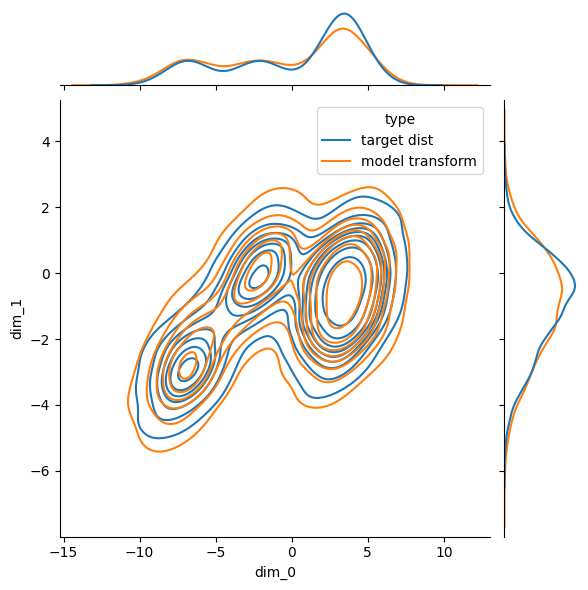

trail: 0 m step: 2 kl_test: 0.05517005920410156


  2%|▏         | 100/6000 [00:29<32:19,  3.04it/s]

trail: 0 m step: 3 Loss: 0.0407088370446894  L_n: 0.03349876403808594  kld: 0.0015840530395507812 KLD1: 0.035013001412153244 KLD2: 0.033352915197610855


  3%|▎         | 200/6000 [00:59<31:25,  3.08it/s]

trail: 0 m step: 3 Loss: 0.04786242362201675  L_n: 0.041359901428222656  kld: 0.0014286041259765625 KLD1: 0.0355575792491436 KLD2: 0.02645997889339924


  5%|▌         | 300/6000 [01:28<30:31,  3.11it/s]

trail: 0 m step: 3 Loss: 0.044128220679274896  L_n: 0.03578519821166992  kld: 0.0018329620361328125 KLD1: 0.035466037690639496 KLD2: 0.032955802977085114


  7%|▋         | 400/6000 [01:58<30:07,  3.10it/s]

trail: 0 m step: 3 Loss: 0.04720155662116431  L_n: 0.03924703598022461  kld: 0.0017476081848144531 KLD1: 0.037003953009843826 KLD2: 0.03554171696305275


  8%|▊         | 500/6000 [02:27<29:27,  3.11it/s]

trail: 0 m step: 3 Loss: 0.045012640095755466  L_n: 0.03678464889526367  kld: 0.0018076896667480469 KLD1: 0.03627701848745346 KLD2: 0.03454988822340965


 10%|█         | 600/6000 [02:57<29:01,  3.10it/s]

trail: 0 m step: 3 Loss: 0.043091952827880746  L_n: 0.03221607208251953  kld: 0.0023894309997558594 KLD1: 0.03335823118686676 KLD2: 0.027924174442887306


 12%|█▏        | 700/6000 [03:26<28:46,  3.07it/s]

trail: 0 m step: 3 Loss: 0.04751833167790173  L_n: 0.03770160675048828  kld: 0.0021567344665527344 KLD1: 0.03484785556793213 KLD2: 0.028223559260368347


 13%|█▎        | 800/6000 [03:56<28:00,  3.10it/s]

trail: 0 m step: 3 Loss: 0.03897923016797753  L_n: 0.03509855270385742  kld: 0.0008525848388671875 KLD1: 0.038742564618587494 KLD2: 0.03455522283911705


 15%|█▌        | 900/6000 [04:25<27:32,  3.09it/s]

trail: 0 m step: 3 Loss: 0.04665532240175257  L_n: 0.036853790283203125  kld: 0.0021533966064453125 KLD1: 0.03454429283738136 KLD2: 0.03597037121653557


 17%|█▋        | 1000/6000 [04:55<26:50,  3.11it/s]

trail: 0 m step: 3 Loss: 0.05000298968433628  L_n: 0.03358173370361328  kld: 0.0036077499389648438 KLD1: 0.026700085029006004 KLD2: 0.03183133527636528


 18%|█▊        | 1100/6000 [05:24<26:22,  3.10it/s]

trail: 0 m step: 3 Loss: 0.04418897541968129  L_n: 0.034589290618896484  kld: 0.002109050750732422 KLD1: 0.0373338982462883 KLD2: 0.03258858621120453


 20%|██        | 1200/6000 [05:53<25:48,  3.10it/s]

trail: 0 m step: 3 Loss: 0.04261009618266908  L_n: 0.03379392623901367  kld: 0.0019369125366210938 KLD1: 0.03509001433849335 KLD2: 0.028761442750692368


 22%|██▏       | 1300/6000 [06:23<25:11,  3.11it/s]

trail: 0 m step: 3 Loss: 0.04006062348321941  L_n: 0.03324556350708008  kld: 0.0014972686767578125 KLD1: 0.03449639678001404 KLD2: 0.03395026922225952


 23%|██▎       | 1400/6000 [06:52<24:44,  3.10it/s]

trail: 0 m step: 3 Loss: 0.04239900924967374  L_n: 0.035060882568359375  kld: 0.0016121864318847656 KLD1: 0.03723945468664169 KLD2: 0.027904534712433815


 25%|██▌       | 1500/6000 [07:22<24:18,  3.08it/s]

trail: 0 m step: 3 Loss: 0.04344514917122759  L_n: 0.033148765563964844  kld: 0.002262115478515625 KLD1: 0.0339205302298069 KLD2: 0.03167586028575897


 27%|██▋       | 1600/6000 [07:51<23:42,  3.09it/s]

trail: 0 m step: 3 Loss: 0.04371163776694616  L_n: 0.03358888626098633  kld: 0.002223968505859375 KLD1: 0.03367551788687706 KLD2: 0.03112919256091118


 28%|██▊       | 1700/6000 [08:21<23:11,  3.09it/s]

trail: 0 m step: 3 Loss: 0.04772875750667136  L_n: 0.033803462982177734  kld: 0.00305938720703125 KLD1: 0.028969133272767067 KLD2: 0.034578949213027954


 30%|███       | 1800/6000 [08:50<22:37,  3.09it/s]

trail: 0 m step: 3 Loss: 0.04761616989434389  L_n: 0.03573322296142578  kld: 0.0026106834411621094 KLD1: 0.03178936243057251 KLD2: 0.02909172885119915


 32%|███▏      | 1900/6000 [09:20<22:10,  3.08it/s]

trail: 0 m step: 3 Loss: 0.04329619670272362  L_n: 0.03669166564941406  kld: 0.0014510154724121094 KLD1: 0.03606020286679268 KLD2: 0.030174212530255318


 33%|███▎      | 2000/6000 [09:49<21:38,  3.08it/s]

trail: 0 m step: 3 Loss: 0.04203676124784585  L_n: 0.0323328971862793  kld: 0.002131938934326172 KLD1: 0.0333026647567749 KLD2: 0.026944946497678757


 35%|███▌      | 2100/6000 [10:19<21:15,  3.06it/s]

trail: 0 m step: 3 Loss: 0.04186318644513637  L_n: 0.03648710250854492  kld: 0.0011811256408691406 KLD1: 0.03893379867076874 KLD2: 0.027534276247024536


 37%|███▋      | 2200/6000 [10:48<20:34,  3.08it/s]

trail: 0 m step: 3 Loss: 0.03898887846976668  L_n: 0.031275272369384766  kld: 0.0016946792602539062 KLD1: 0.033889289945364 KLD2: 0.03285650536417961


 38%|███▊      | 2300/6000 [11:17<19:54,  3.10it/s]

trail: 0 m step: 3 Loss: 0.04919360516339364  L_n: 0.037935733795166016  kld: 0.0024733543395996094 KLD1: 0.032073333859443665 KLD2: 0.033565107733011246


 40%|████      | 2400/6000 [11:47<19:27,  3.08it/s]

trail: 0 m step: 3 Loss: 0.037460793133589375  L_n: 0.03428983688354492  kld: 0.0006966590881347656 KLD1: 0.03882301598787308 KLD2: 0.03515549376606941


 42%|████▏     | 2500/6000 [12:16<18:47,  3.10it/s]

trail: 0 m step: 3 Loss: 0.05336566963247891  L_n: 0.03870677947998047  kld: 0.0032205581665039062 KLD1: 0.028867444023489952 KLD2: 0.03052598424255848


 43%|████▎     | 2600/6000 [12:45<18:15,  3.10it/s]

trail: 0 m step: 3 Loss: 0.04388716332631378  L_n: 0.03258371353149414  kld: 0.002483367919921875 KLD1: 0.03193114325404167 KLD2: 0.029763584956526756


 45%|████▌     | 2700/6000 [13:15<18:23,  2.99it/s]

trail: 0 m step: 3 Loss: 0.04473224595616392  L_n: 0.035497188568115234  kld: 0.002028942108154297 KLD1: 0.033521585166454315 KLD2: 0.03295281156897545


 47%|████▋     | 2800/6000 [13:44<17:25,  3.06it/s]

trail: 0 m step: 3 Loss: 0.03992427909271143  L_n: 0.031783103942871094  kld: 0.0017886161804199219 KLD1: 0.03578886017203331 KLD2: 0.027819126844406128


 48%|████▊     | 2900/6000 [14:14<16:39,  3.10it/s]

trail: 0 m step: 3 Loss: 0.04773235147412821  L_n: 0.038069725036621094  kld: 0.0021228790283203125 KLD1: 0.033452488481998444 KLD2: 0.028350448235869408


 50%|█████     | 3000/6000 [14:43<16:07,  3.10it/s]

trail: 0 m step: 3 Loss: 0.03849865297431234  L_n: 0.030494213104248047  kld: 0.001758575439453125 KLD1: 0.036311838775873184 KLD2: 0.02798864059150219


 52%|█████▏    | 3100/6000 [15:13<15:38,  3.09it/s]

trail: 0 m step: 3 Loss: 0.03581735075306881  L_n: 0.02918243408203125  kld: 0.0014576911926269531 KLD1: 0.03849641606211662 KLD2: 0.025866124778985977


 53%|█████▎    | 3200/6000 [15:42<15:02,  3.10it/s]

trail: 0 m step: 3 Loss: 0.047896558824972395  L_n: 0.036643028259277344  kld: 0.002472400665283203 KLD1: 0.031559187918901443 KLD2: 0.03289429098367691


 55%|█████▌    | 3300/6000 [16:12<14:26,  3.12it/s]

trail: 0 m step: 3 Loss: 0.04640765292133371  L_n: 0.0370640754699707  kld: 0.002052783966064453 KLD1: 0.03296296298503876 KLD2: 0.03007211908698082


 57%|█████▋    | 3400/6000 [16:41<14:09,  3.06it/s]

trail: 0 m step: 3 Loss: 0.04901435714881421  L_n: 0.039664268493652344  kld: 0.0020542144775390625 KLD1: 0.033710777759552 KLD2: 0.027796948328614235


 58%|█████▊    | 3500/6000 [17:11<13:37,  3.06it/s]

trail: 0 m step: 3 Loss: 0.04504911499127617  L_n: 0.0348048210144043  kld: 0.00225067138671875 KLD1: 0.03311920911073685 KLD2: 0.03295125067234039


 60%|██████    | 3600/6000 [17:40<12:53,  3.10it/s]

trail: 0 m step: 3 Loss: 0.047746022180584165  L_n: 0.03858041763305664  kld: 0.002013683319091797 KLD1: 0.03423086553812027 KLD2: 0.029104528948664665


 62%|██████▏   | 3700/6000 [18:09<12:30,  3.07it/s]

trail: 0 m step: 3 Loss: 0.037357635697723796  L_n: 0.027310848236083984  kld: 0.0022072792053222656 KLD1: 0.03446948155760765 KLD2: 0.030624382197856903


 63%|██████▎   | 3800/6000 [18:39<11:49,  3.10it/s]

trail: 0 m step: 3 Loss: 0.04586137268941512  L_n: 0.036103248596191406  kld: 0.00214385986328125 KLD1: 0.034370191395282745 KLD2: 0.028302818536758423


 65%|██████▌   | 3900/6000 [19:08<11:14,  3.11it/s]

trail: 0 m step: 3 Loss: 0.04880125434712274  L_n: 0.03782987594604492  kld: 0.002410411834716797 KLD1: 0.03298330679535866 KLD2: 0.026681428775191307


 67%|██████▋   | 4000/6000 [19:38<10:48,  3.09it/s]

trail: 0 m step: 3 Loss: 0.04688287074315206  L_n: 0.035770416259765625  kld: 0.00244140625 KLD1: 0.033075492829084396 KLD2: 0.03060181438922882


 68%|██████▊   | 4100/6000 [20:07<10:14,  3.09it/s]

trail: 0 m step: 3 Loss: 0.03483954851986551  L_n: 0.02892303466796875  kld: 0.0012998580932617188 KLD1: 0.0386439673602581 KLD2: 0.03292390704154968


 70%|███████   | 4200/6000 [20:37<09:39,  3.11it/s]

trail: 0 m step: 3 Loss: 0.03816499197868309  L_n: 0.02968740463256836  kld: 0.0018625259399414062 KLD1: 0.03325453773140907 KLD2: 0.029439406469464302


 72%|███████▏  | 4300/6000 [21:06<09:05,  3.11it/s]

trail: 0 m step: 3 Loss: 0.040215321220915375  L_n: 0.032584190368652344  kld: 0.0016765594482421875 KLD1: 0.03538597375154495 KLD2: 0.029522038996219635


 73%|███████▎  | 4400/6000 [21:36<08:37,  3.09it/s]

trail: 0 m step: 3 Loss: 0.043214510612505155  L_n: 0.036685943603515625  kld: 0.001434326171875 KLD1: 0.0354924239218235 KLD2: 0.030989520251750946


 75%|███████▌  | 4500/6000 [22:05<08:03,  3.10it/s]

trail: 0 m step: 3 Loss: 0.03617824507562692  L_n: 0.03032684326171875  kld: 0.001285552978515625 KLD1: 0.036774810403585434 KLD2: 0.02816583774983883


 77%|███████▋  | 4600/6000 [22:35<07:32,  3.10it/s]

trail: 0 m step: 3 Loss: 0.04319923619655354  L_n: 0.03076934814453125  kld: 0.002730846405029297 KLD1: 0.031235085800290108 KLD2: 0.028322450816631317


 78%|███████▊  | 4700/6000 [23:04<07:00,  3.09it/s]

trail: 0 m step: 3 Loss: 0.04243772508450188  L_n: 0.0370030403137207  kld: 0.001194000244140625 KLD1: 0.037700943648815155 KLD2: 0.03225826472043991


 80%|████████  | 4800/6000 [23:33<06:25,  3.11it/s]

trail: 0 m step: 3 Loss: 0.0450777312978919  L_n: 0.03527402877807617  kld: 0.0021538734436035156 KLD1: 0.03208847716450691 KLD2: 0.029137853533029556


 82%|████████▏ | 4900/6000 [24:03<05:53,  3.12it/s]

trail: 0 m step: 3 Loss: 0.04223952121934296  L_n: 0.035320281982421875  kld: 0.0015201568603515625 KLD1: 0.03753980994224548 KLD2: 0.031215716153383255


 83%|████████▎ | 5000/6000 [24:32<05:21,  3.11it/s]

trail: 0 m step: 3 Loss: 0.04267677221181016  L_n: 0.035128116607666016  kld: 0.0016584396362304688 KLD1: 0.03646143525838852 KLD2: 0.03081141971051693


 85%|████████▌ | 5100/6000 [25:02<04:52,  3.08it/s]

trail: 0 m step: 3 Loss: 0.040102480105720005  L_n: 0.03043985366821289  kld: 0.0021228790283203125 KLD1: 0.032301925122737885 KLD2: 0.0328918881714344


 87%|████████▋ | 5200/6000 [25:31<04:18,  3.10it/s]

trail: 0 m step: 3 Loss: 0.042249438867929257  L_n: 0.035527706146240234  kld: 0.0014767646789550781 KLD1: 0.03613647073507309 KLD2: 0.028774455189704895


 88%|████████▊ | 5300/6000 [26:01<03:45,  3.10it/s]

trail: 0 m step: 3 Loss: 0.047425516638150256  L_n: 0.041459083557128906  kld: 0.0013108253479003906 KLD1: 0.036727454513311386 KLD2: 0.031108330935239792


 90%|█████████ | 5400/6000 [26:30<03:13,  3.10it/s]

trail: 0 m step: 3 Loss: 0.0354253250629076  L_n: 0.031190872192382812  kld: 0.0009303092956542969 KLD1: 0.03851715102791786 KLD2: 0.03214145451784134


 92%|█████████▏| 5500/6000 [27:00<02:40,  3.12it/s]

trail: 0 m step: 3 Loss: 0.047857681078209785  L_n: 0.03965139389038086  kld: 0.0018029212951660156 KLD1: 0.034976184368133545 KLD2: 0.029463021084666252


 93%|█████████▎| 5600/6000 [27:29<02:15,  2.94it/s]

trail: 0 m step: 3 Loss: 0.04438293180956209  L_n: 0.03588581085205078  kld: 0.0018668174743652344 KLD1: 0.036646049469709396 KLD2: 0.030222326517105103


 95%|█████████▌| 5700/6000 [27:59<01:37,  3.07it/s]

trail: 0 m step: 3 Loss: 0.039988255793797625  L_n: 0.034108638763427734  kld: 0.0012917518615722656 KLD1: 0.03694498911499977 KLD2: 0.03324022889137268


 97%|█████████▋| 5800/6000 [28:28<01:06,  2.99it/s]

trail: 0 m step: 3 Loss: 0.04079464863363482  L_n: 0.032199859619140625  kld: 0.001888275146484375 KLD1: 0.03402750939130783 KLD2: 0.030770672485232353


 98%|█████████▊| 5900/6000 [28:58<00:32,  3.09it/s]

trail: 0 m step: 3 Loss: 0.03950425869885715  L_n: 0.03070545196533203  kld: 0.0019330978393554688 KLD1: 0.03482943773269653 KLD2: 0.031234288588166237


100%|██████████| 6000/6000 [29:28<00:00,  3.39it/s]

trail: 0 m step: 3 Loss: 0.037495251509293566  L_n: 0.0279693603515625  kld: 0.0020928382873535156 KLD1: 0.03274467960000038 KLD2: 0.02986094355583191



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


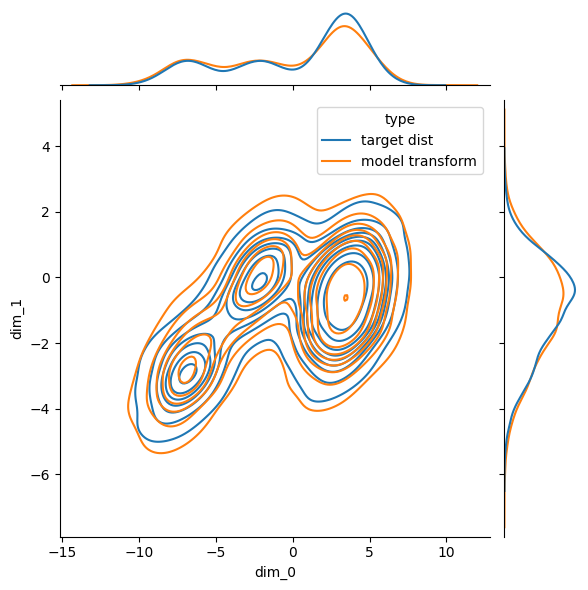

trail: 0 m step: 3 kl_test: 0.03572416305541992


  2%|▏         | 100/6000 [00:29<32:13,  3.05it/s]

trail: 0 m step: 4 Loss: 0.02491244251022427  L_n: 0.01880025863647461  kld: 0.0017457008361816406 KLD1: 0.02052953839302063 KLD2: 0.02071884088218212


  3%|▎         | 200/6000 [00:58<31:12,  3.10it/s]

trail: 0 m step: 4 Loss: 0.029797554183067225  L_n: 0.025224685668945312  kld: 0.0013060569763183594 KLD1: 0.021461091935634613 KLD2: 0.015050675719976425


  5%|▌         | 300/6000 [01:28<30:27,  3.12it/s]

trail: 0 m step: 4 Loss: 0.027631107020589307  L_n: 0.02158069610595703  kld: 0.001728057861328125 KLD1: 0.021343911066651344 KLD2: 0.020731236785650253


  7%|▋         | 400/6000 [01:57<30:14,  3.09it/s]

trail: 0 m step: 4 Loss: 0.02952458715660891  L_n: 0.023584365844726562  kld: 0.0016965866088867188 KLD1: 0.022534063085913658 KLD2: 0.022341186180710793


  8%|▊         | 500/6000 [02:27<29:29,  3.11it/s]

trail: 0 m step: 4 Loss: 0.027424774551912497  L_n: 0.022302627563476562  kld: 0.0014629364013671875 KLD1: 0.022118670865893364 KLD2: 0.022143233567476273


 10%|█         | 600/6000 [02:56<29:12,  3.08it/s]

trail: 0 m step: 4 Loss: 0.026110671681059884  L_n: 0.018210411071777344  kld: 0.0022563934326171875 KLD1: 0.01941870152950287 KLD2: 0.016450190916657448


 12%|█▏        | 700/6000 [03:26<28:32,  3.10it/s]

trail: 0 m step: 4 Loss: 0.031136184174291332  L_n: 0.023544788360595703  kld: 0.0021681785583496094 KLD1: 0.021368520334362984 KLD2: 0.01690797321498394


 13%|█▎        | 800/6000 [03:55<28:23,  3.05it/s]

trail: 0 m step: 4 Loss: 0.023516917770464277  L_n: 0.02083730697631836  kld: 0.0007653236389160156 KLD1: 0.02383076213300228 KLD2: 0.02179785631597042


 15%|█▌        | 900/6000 [04:25<27:34,  3.08it/s]

trail: 0 m step: 4 Loss: 0.029393487106680653  L_n: 0.022064208984375  kld: 0.0020933151245117188 KLD1: 0.02063850127160549 KLD2: 0.022742383182048798


 17%|█▋        | 1000/6000 [04:54<26:52,  3.10it/s]

trail: 0 m step: 4 Loss: 0.0312764903985754  L_n: 0.019447803497314453  kld: 0.0033783912658691406 KLD1: 0.014343343675136566 KLD2: 0.019858943298459053


 18%|█▊        | 1100/6000 [05:24<26:29,  3.08it/s]

trail: 0 m step: 4 Loss: 0.027226903893434132  L_n: 0.020752429962158203  kld: 0.0018491744995117188 KLD1: 0.022822363302111626 KLD2: 0.02035519853234291


 20%|██        | 1200/6000 [05:53<27:42,  2.89it/s]

trail: 0 m step: 4 Loss: 0.025893586610429637  L_n: 0.01898670196533203  kld: 0.001972675323486328 KLD1: 0.019999617710709572 KLD2: 0.01712401956319809


 22%|██▏       | 1300/6000 [06:23<25:15,  3.10it/s]

trail: 0 m step: 4 Loss: 0.025491296157738076  L_n: 0.020105361938476562  kld: 0.0015382766723632812 KLD1: 0.020150676369667053 KLD2: 0.021004213020205498


 23%|██▎       | 1400/6000 [06:52<24:51,  3.08it/s]

trail: 0 m step: 4 Loss: 0.02735670749590446  L_n: 0.02190399169921875  kld: 0.0015573501586914062 KLD1: 0.022703129798173904 KLD2: 0.01639576256275177


 25%|██▌       | 1500/6000 [07:22<24:21,  3.08it/s]

trail: 0 m step: 4 Loss: 0.026883251622529476  L_n: 0.019351959228515625  kld: 0.002151012420654297 KLD1: 0.01943536289036274 KLD2: 0.019944967702031136


 27%|██▋       | 1600/6000 [07:51<23:41,  3.09it/s]

trail: 0 m step: 4 Loss: 0.026454968978525485  L_n: 0.019150733947753906  kld: 0.002086162567138672 KLD1: 0.019651882350444794 KLD2: 0.01917584426701069


 28%|██▊       | 1700/6000 [08:21<23:21,  3.07it/s]

trail: 0 m step: 4 Loss: 0.03033753617763736  L_n: 0.019984722137451172  kld: 0.002956867218017578 KLD1: 0.01643216423690319 KLD2: 0.0220259390771389


 30%|███       | 1800/6000 [08:50<22:41,  3.09it/s]

trail: 0 m step: 4 Loss: 0.03036157348852924  L_n: 0.021432876586914062  kld: 0.0025501251220703125 KLD1: 0.018166467547416687 KLD2: 0.01748894527554512


 32%|███▏      | 1900/6000 [09:20<22:00,  3.10it/s]

trail: 0 m step: 4 Loss: 0.026607937874745087  L_n: 0.021525859832763672  kld: 0.0014514923095703125 KLD1: 0.02167624980211258 KLD2: 0.018014702945947647


 33%|███▎      | 2000/6000 [09:49<21:27,  3.11it/s]

trail: 0 m step: 4 Loss: 0.025565076127263837  L_n: 0.017921924591064453  kld: 0.0021829605102539062 KLD1: 0.019005062058568 KLD2: 0.015533522702753544


 35%|███▌      | 2100/6000 [10:19<20:59,  3.10it/s]

trail: 0 m step: 4 Loss: 0.025688276517617008  L_n: 0.021481037139892578  kld: 0.001201629638671875 KLD1: 0.022983640432357788 KLD2: 0.016152380034327507


 37%|███▋      | 2200/6000 [10:48<20:29,  3.09it/s]

trail: 0 m step: 4 Loss: 0.024350485653608627  L_n: 0.018249988555908203  kld: 0.0017423629760742188 KLD1: 0.01967981830239296 KLD2: 0.020435310900211334


 38%|███▊      | 2300/6000 [11:17<19:51,  3.11it/s]

trail: 0 m step: 4 Loss: 0.030461444970268453  L_n: 0.022910118103027344  kld: 0.0021567344665527344 KLD1: 0.019215160980820656 KLD2: 0.02122337929904461


 40%|████      | 2400/6000 [11:47<19:25,  3.09it/s]

trail: 0 m step: 4 Loss: 0.02187749311990011  L_n: 0.019358158111572266  kld: 0.0007195472717285156 KLD1: 0.02278909832239151 KLD2: 0.02221451885998249


 42%|████▏     | 2500/6000 [12:16<18:46,  3.11it/s]

trail: 0 m step: 4 Loss: 0.035288749825181855  L_n: 0.02500438690185547  kld: 0.00293731689453125 KLD1: 0.01604386791586876 KLD2: 0.01878862828016281


 43%|████▎     | 2600/6000 [12:46<18:15,  3.10it/s]

trail: 0 m step: 4 Loss: 0.026756157916298658  L_n: 0.01861715316772461  kld: 0.0023245811462402344 KLD1: 0.018754392862319946 KLD2: 0.01805182918906212


 45%|████▌     | 2700/6000 [13:16<17:40,  3.11it/s]

trail: 0 m step: 4 Loss: 0.027623994682421264  L_n: 0.021463394165039062  kld: 0.0017595291137695312 KLD1: 0.019918056204915047 KLD2: 0.020599795505404472


 47%|████▋     | 2800/6000 [13:45<17:08,  3.11it/s]

trail: 0 m step: 4 Loss: 0.02420280400513225  L_n: 0.01837778091430664  kld: 0.0016636848449707031 KLD1: 0.021220844238996506 KLD2: 0.01661697030067444


 48%|████▊     | 2900/6000 [14:15<16:36,  3.11it/s]

trail: 0 m step: 4 Loss: 0.030596477787291222  L_n: 0.02345752716064453  kld: 0.0020389556884765625 KLD1: 0.01941751316189766 KLD2: 0.016842126846313477


 50%|█████     | 3000/6000 [14:44<16:08,  3.10it/s]

trail: 0 m step: 4 Loss: 0.02257894298483613  L_n: 0.016732215881347656  kld: 0.0016698837280273438 KLD1: 0.02159658819437027 KLD2: 0.01668100617825985


 52%|█████▏    | 3100/6000 [15:13<15:34,  3.10it/s]

trail: 0 m step: 4 Loss: 0.0212829340147432  L_n: 0.016648292541503906  kld: 0.001323699951171875 KLD1: 0.0238244216889143 KLD2: 0.014677909202873707


 53%|█████▎    | 3200/6000 [15:43<15:05,  3.09it/s]

trail: 0 m step: 4 Loss: 0.029707367682898562  L_n: 0.02139139175415039  kld: 0.0023751258850097656 KLD1: 0.018384212628006935 KLD2: 0.020506130531430244


 55%|█████▌    | 3300/6000 [16:12<14:31,  3.10it/s]

trail: 0 m step: 4 Loss: 0.028926585527917364  L_n: 0.02181100845336914  kld: 0.0020322799682617188 KLD1: 0.018550151959061623 KLD2: 0.018089789897203445


 57%|█████▋    | 3400/6000 [16:42<13:56,  3.11it/s]

trail: 0 m step: 4 Loss: 0.03065906670041697  L_n: 0.02383565902709961  kld: 0.0019488334655761719 KLD1: 0.019863741472363472 KLD2: 0.016358623281121254


 58%|█████▊    | 3500/6000 [17:11<13:24,  3.11it/s]

trail: 0 m step: 4 Loss: 0.02789994171990437  L_n: 0.020821094512939453  kld: 0.00202178955078125 KLD1: 0.01925787143409252 KLD2: 0.02043473720550537


 60%|██████    | 3600/6000 [17:41<13:05,  3.06it/s]

trail: 0 m step: 4 Loss: 0.0306664899736095  L_n: 0.023754596710205078  kld: 0.0019741058349609375 KLD1: 0.020190294831991196 KLD2: 0.017493169754743576


 62%|██████▏   | 3700/6000 [18:10<12:21,  3.10it/s]

trail: 0 m step: 4 Loss: 0.02304190022659662  L_n: 0.015377044677734375  kld: 0.002189159393310547 KLD1: 0.019806748256087303 KLD2: 0.018625320866703987


 63%|██████▎   | 3800/6000 [18:40<11:55,  3.08it/s]

trail: 0 m step: 4 Loss: 0.02937721979893129  L_n: 0.022198200225830078  kld: 0.0020503997802734375 KLD1: 0.02016359753906727 KLD2: 0.01694006659090519


 65%|██████▌   | 3900/6000 [19:09<11:20,  3.09it/s]

trail: 0 m step: 4 Loss: 0.03119064964277604  L_n: 0.023308753967285156  kld: 0.002251148223876953 KLD1: 0.019205626100301743 KLD2: 0.01584024354815483


 67%|██████▋   | 4000/6000 [19:39<10:49,  3.08it/s]

trail: 0 m step: 4 Loss: 0.03003667431933502  L_n: 0.02158212661743164  kld: 0.002414703369140625 KLD1: 0.018625689670443535 KLD2: 0.018559738993644714


 68%|██████▊   | 4100/6000 [20:08<10:24,  3.04it/s]

trail: 0 m step: 4 Loss: 0.02117782493736358  L_n: 0.016451358795166016  kld: 0.0013499259948730469 KLD1: 0.023235224187374115 KLD2: 0.02045554667711258


 70%|███████   | 4200/6000 [20:38<09:41,  3.09it/s]

trail: 0 m step: 4 Loss: 0.023183554069722324  L_n: 0.01673412322998047  kld: 0.0018420219421386719 KLD1: 0.019446982070803642 KLD2: 0.01776941865682602


 72%|███████▏  | 4300/6000 [21:07<09:17,  3.05it/s]

trail: 0 m step: 4 Loss: 0.02439897069827185  L_n: 0.018715858459472656  kld: 0.0016231536865234375 KLD1: 0.021200139075517654 KLD2: 0.017755772918462753


 73%|███████▎  | 4400/6000 [21:37<08:35,  3.10it/s]

trail: 0 m step: 4 Loss: 0.02730366035125648  L_n: 0.022174835205078125  kld: 0.00146484375 KLD1: 0.020159725099802017 KLD2: 0.01894579641520977


 75%|███████▌  | 4500/6000 [22:06<08:02,  3.11it/s]

trail: 0 m step: 4 Loss: 0.02170095079432081  L_n: 0.017530441284179688  kld: 0.0011911392211914062 KLD1: 0.022341256961226463 KLD2: 0.016646431758999825


 77%|███████▋  | 4600/6000 [22:36<07:30,  3.11it/s]

trail: 0 m step: 4 Loss: 0.02756988327316466  L_n: 0.01811695098876953  kld: 0.0026998519897460938 KLD1: 0.017755452543497086 KLD2: 0.016748227179050446


 78%|███████▊  | 4700/6000 [23:05<06:58,  3.11it/s]

trail: 0 m step: 4 Loss: 0.02655606408241245  L_n: 0.022502422332763672  kld: 0.0011577606201171875 KLD1: 0.023016493767499924 KLD2: 0.020037923008203506


 80%|████████  | 4800/6000 [23:34<06:29,  3.08it/s]

trail: 0 m step: 4 Loss: 0.028229250793868402  L_n: 0.02100515365600586  kld: 0.002063274383544922 KLD1: 0.01912110485136509 KLD2: 0.01741855777800083


 82%|████████▏ | 4900/6000 [24:04<05:54,  3.10it/s]

trail: 0 m step: 4 Loss: 0.026226729113891768  L_n: 0.02108287811279297  kld: 0.0014691352844238281 KLD1: 0.022079655900597572 KLD2: 0.019105136394500732


 83%|████████▎ | 5000/6000 [24:33<05:22,  3.10it/s]

trail: 0 m step: 4 Loss: 0.026607149952303847  L_n: 0.02107095718383789  kld: 0.0015811920166015625 KLD1: 0.021622490137815475 KLD2: 0.01866375096142292


 85%|████████▌ | 5100/6000 [25:03<04:49,  3.11it/s]

trail: 0 m step: 4 Loss: 0.024873692867222554  L_n: 0.017799854278564453  kld: 0.0020203590393066406 KLD1: 0.018932459875941277 KLD2: 0.02060665749013424


 87%|████████▋ | 5200/6000 [25:32<04:17,  3.11it/s]

trail: 0 m step: 4 Loss: 0.025524276072795074  L_n: 0.020577430725097656  kld: 0.0014128684997558594 KLD1: 0.02199254184961319 KLD2: 0.017219573259353638


 88%|████████▊ | 5300/6000 [26:02<03:46,  3.10it/s]

trail: 0 m step: 4 Loss: 0.028889038020090865  L_n: 0.024703502655029297  kld: 0.0011954307556152344 KLD1: 0.022423217073082924 KLD2: 0.018937071785330772


 90%|█████████ | 5400/6000 [26:31<03:13,  3.10it/s]

trail: 0 m step: 4 Loss: 0.021034386373276613  L_n: 0.018022537231445312  kld: 0.0008602142333984375 KLD1: 0.02308991551399231 KLD2: 0.019754841923713684


 92%|█████████▏| 5500/6000 [27:00<02:41,  3.10it/s]

trail: 0 m step: 4 Loss: 0.030047209213346054  L_n: 0.024083614349365234  kld: 0.0017032623291015625 KLD1: 0.020046766847372055 KLD2: 0.01777235046029091


 93%|█████████▎| 5600/6000 [27:30<02:09,  3.10it/s]

trail: 0 m step: 4 Loss: 0.027451038076773997  L_n: 0.0209197998046875  kld: 0.001865386962890625 KLD1: 0.02096262387931347 KLD2: 0.01825650967657566


 95%|█████████▌| 5700/6000 [27:59<01:36,  3.11it/s]

trail: 0 m step: 4 Loss: 0.02364673905335723  L_n: 0.019327640533447266  kld: 0.0012335777282714844 KLD1: 0.021463043987751007 KLD2: 0.020847676321864128


 97%|█████████▋| 5800/6000 [28:28<01:04,  3.10it/s]

trail: 0 m step: 4 Loss: 0.025499671736224673  L_n: 0.01937580108642578  kld: 0.0017490386962890625 KLD1: 0.020403483882546425 KLD2: 0.01876492239534855


 98%|█████████▊| 5900/6000 [28:58<00:32,  3.09it/s]

trail: 0 m step: 4 Loss: 0.024409938871157208  L_n: 0.01741790771484375  kld: 0.0019969940185546875 KLD1: 0.01987084187567234 KLD2: 0.019054938107728958


100%|██████████| 6000/6000 [29:27<00:00,  3.39it/s]

trail: 0 m step: 4 Loss: 0.022615993387295683  L_n: 0.015854358673095703  kld: 0.0019311904907226562 KLD1: 0.01966816745698452 KLD2: 0.018053412437438965



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


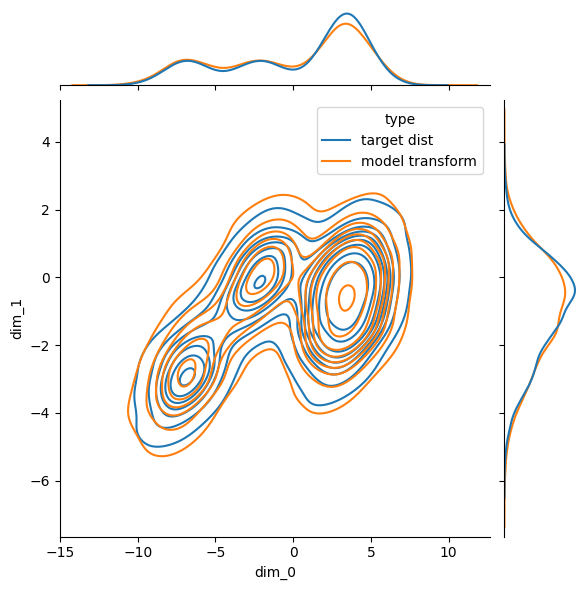

trail: 0 m step: 4 kl_test: 0.02160167694091797


  2%|▏         | 100/6000 [00:29<31:59,  3.07it/s]

trail: 0 m step: 5 Loss: 0.01397640333257261  L_n: 0.009620189666748047  kld: 0.001617431640625 KLD1: 0.01086138840764761 KLD2: 0.011896871961653233


  3%|▎         | 200/6000 [00:58<31:08,  3.10it/s]

trail: 0 m step: 5 Loss: 0.01664648422481337  L_n: 0.014063835144042969  kld: 0.0009589195251464844 KLD1: 0.011778914369642735 KLD2: 0.007460589986294508


  5%|▌         | 300/6000 [01:27<30:28,  3.12it/s]

trail: 0 m step: 5 Loss: 0.016048324768137667  L_n: 0.012119770050048828  kld: 0.0014586448669433594 KLD1: 0.012251583859324455 KLD2: 0.012023626826703548


  7%|▋         | 400/6000 [01:57<30:23,  3.07it/s]

trail: 0 m step: 5 Loss: 0.0169317943348314  L_n: 0.012901782989501953  kld: 0.0014963150024414062 KLD1: 0.012832757085561752 KLD2: 0.012941112741827965


  8%|▊         | 500/6000 [02:26<29:39,  3.09it/s]

trail: 0 m step: 5 Loss: 0.01535782190375844  L_n: 0.012350082397460938  kld: 0.0011167526245117188 KLD1: 0.011464504525065422 KLD2: 0.013041741214692593


 10%|█         | 600/6000 [02:55<28:59,  3.11it/s]

trail: 0 m step: 5 Loss: 0.014173078096100467  L_n: 0.009119510650634766  kld: 0.0018763542175292969 KLD1: 0.0105998944491148 KLD2: 0.008786753751337528


 12%|█▏        | 700/6000 [03:25<28:32,  3.10it/s]

trail: 0 m step: 5 Loss: 0.018667234798087143  L_n: 0.013102531433105469  kld: 0.0020661354064941406 KLD1: 0.011750590056180954 KLD2: 0.009004478342831135


 13%|█▎        | 800/6000 [03:54<28:00,  3.09it/s]

trail: 0 m step: 5 Loss: 0.01207961823279377  L_n: 0.010738849639892578  kld: 0.0004978179931640625 KLD1: 0.013628133572638035 KLD2: 0.012495877221226692


 15%|█▌        | 900/6000 [04:24<27:26,  3.10it/s]

trail: 0 m step: 5 Loss: 0.017067945819047428  L_n: 0.012144088745117188  kld: 0.0018281936645507812 KLD1: 0.011002784594893456 KLD2: 0.013192231766879559


 17%|█▋        | 1000/6000 [04:53<26:47,  3.11it/s]

trail: 0 m step: 5 Loss: 0.019031519352920502  L_n: 0.010654926300048828  kld: 0.003110170364379883 KLD1: 0.006267036311328411 KLD2: 0.011116460897028446


 18%|█▊        | 1100/6000 [05:22<26:18,  3.11it/s]

trail: 0 m step: 5 Loss: 0.016009662872275905  L_n: 0.0120849609375  kld: 0.00145721435546875 KLD1: 0.013018137775361538 KLD2: 0.011653364636003971


 20%|██        | 1200/6000 [05:51<25:44,  3.11it/s]

trail: 0 m step: 5 Loss: 0.014865693969401489  L_n: 0.01023721694946289  kld: 0.0017185211181640625 KLD1: 0.010376344434916973 KLD2: 0.009182934649288654


 22%|██▏       | 1300/6000 [06:21<25:15,  3.10it/s]

trail: 0 m step: 5 Loss: 0.01371613098312081  L_n: 0.010445117950439453  kld: 0.0012145042419433594 KLD1: 0.010637028142809868 KLD2: 0.01221303641796112


 23%|██▎       | 1400/6000 [06:50<24:45,  3.10it/s]

trail: 0 m step: 5 Loss: 0.01534049732933921  L_n: 0.011962890625  kld: 0.0012540817260742188 KLD1: 0.012658398598432541 KLD2: 0.008646955713629723


 25%|██▌       | 1500/6000 [07:20<24:10,  3.10it/s]

trail: 0 m step: 5 Loss: 0.015666554927734742  L_n: 0.010449886322021484  kld: 0.0019369125366210938 KLD1: 0.00955098494887352 KLD2: 0.011538883671164513


 27%|██▋       | 1600/6000 [07:49<23:47,  3.08it/s]

trail: 0 m step: 5 Loss: 0.01505365160006501  L_n: 0.01009511947631836  kld: 0.0018410682678222656 KLD1: 0.01044418290257454 KLD2: 0.010961505584418774


 28%|██▊       | 1700/6000 [08:18<23:09,  3.09it/s]

trail: 0 m step: 5 Loss: 0.017496983486575947  L_n: 0.010478496551513672  kld: 0.002605915069580078 KLD1: 0.008198860101401806 KLD2: 0.012966720387339592


 30%|███       | 1800/6000 [08:48<22:27,  3.12it/s]

trail: 0 m step: 5 Loss: 0.01787456081550749  L_n: 0.012375354766845703  kld: 0.0020418167114257812 KLD1: 0.009560735896229744 KLD2: 0.009458592161536217


 32%|███▏      | 1900/6000 [09:17<22:04,  3.10it/s]

trail: 0 m step: 5 Loss: 0.014883112993519375  L_n: 0.011772632598876953  kld: 0.0011548995971679688 KLD1: 0.01145668514072895 KLD2: 0.009856265038251877


 33%|███▎      | 2000/6000 [09:47<21:28,  3.10it/s]

trail: 0 m step: 5 Loss: 0.014784937866587626  L_n: 0.009418010711669922  kld: 0.0019927024841308594 KLD1: 0.010042073205113411 KLD2: 0.00802155863493681


 35%|███▌      | 2100/6000 [10:16<20:58,  3.10it/s]

trail: 0 m step: 5 Loss: 0.014057841934117922  L_n: 0.011384010314941406  kld: 0.0009927749633789062 KLD1: 0.012393509969115257 KLD2: 0.008474268950521946


 37%|███▋      | 2200/6000 [10:45<20:24,  3.10it/s]

trail: 0 m step: 5 Loss: 0.013024643980467522  L_n: 0.009150028228759766  kld: 0.0014386177062988281 KLD1: 0.010548769496381283 KLD2: 0.011655808426439762


 38%|███▊      | 2300/6000 [11:15<19:55,  3.09it/s]

trail: 0 m step: 5 Loss: 0.017932474437727525  L_n: 0.013247489929199219  kld: 0.001739501953125 KLD1: 0.009949632920324802 KLD2: 0.012287908233702183


 40%|████      | 2400/6000 [11:44<19:20,  3.10it/s]

trail: 0 m step: 5 Loss: 0.011848615767129082  L_n: 0.010288238525390625  kld: 0.0005793571472167969 KLD1: 0.012274759821593761 KLD2: 0.01275719329714775


 42%|████▏     | 2500/6000 [12:13<19:14,  3.03it/s]

trail: 0 m step: 5 Loss: 0.021367584195001545  L_n: 0.014691352844238281  kld: 0.0024788379669189453 KLD1: 0.008949607610702515 KLD2: 0.010484631173312664


 43%|████▎     | 2600/6000 [12:43<18:53,  3.00it/s]

trail: 0 m step: 5 Loss: 0.015006155268213906  L_n: 0.00983572006225586  kld: 0.0019197463989257812 KLD1: 0.01004231907427311 KLD2: 0.009900836274027824


 45%|████▌     | 2700/6000 [13:12<17:43,  3.10it/s]

trail: 0 m step: 5 Loss: 0.015254780901573098  L_n: 0.011061668395996094  kld: 0.0015568733215332031 KLD1: 0.010636991821229458 KLD2: 0.011610208079218864


 47%|████▋     | 2800/6000 [13:41<17:34,  3.03it/s]

trail: 0 m step: 5 Loss: 0.013001563842219293  L_n: 0.009451866149902344  kld: 0.0013179779052734375 KLD1: 0.011803803034126759 KLD2: 0.008832058869302273


 48%|████▊     | 2900/6000 [14:11<16:50,  3.07it/s]

trail: 0 m step: 5 Loss: 0.017437084810220726  L_n: 0.012731552124023438  kld: 0.00174713134765625 KLD1: 0.010149727575480938 KLD2: 0.008869721554219723


 50%|█████     | 3000/6000 [14:40<16:12,  3.08it/s]

trail: 0 m step: 5 Loss: 0.012223124135185353  L_n: 0.00848078727722168  kld: 0.0013895034790039062 KLD1: 0.011579222045838833 KLD2: 0.008840776979923248


 52%|█████▏    | 3100/6000 [15:10<16:08,  3.00it/s]

trail: 0 m step: 5 Loss: 0.011693100588892533  L_n: 0.00855565071105957  kld: 0.0011649131774902344 KLD1: 0.012898719869554043 KLD2: 0.007026829291135073


 53%|█████▎    | 3200/6000 [15:39<14:22,  3.25it/s]

trail: 0 m step: 5 Loss: 0.01741393307441593  L_n: 0.011722087860107422  kld: 0.00211334228515625 KLD1: 0.009820898994803429 KLD2: 0.011541996151208878


 55%|█████▌    | 3300/6000 [16:08<14:49,  3.04it/s]

trail: 0 m step: 5 Loss: 0.016185262347291382  L_n: 0.01162099838256836  kld: 0.0016946792602539062 KLD1: 0.009386515244841576 KLD2: 0.009885868988931179


 57%|█████▋    | 3400/6000 [16:38<14:41,  2.95it/s]

trail: 0 m step: 5 Loss: 0.01721603498540464  L_n: 0.012859821319580078  kld: 0.001617431640625 KLD1: 0.010478230193257332 KLD2: 0.008548995479941368


 58%|█████▊    | 3500/6000 [17:07<13:32,  3.08it/s]

trail: 0 m step: 5 Loss: 0.01506468131345823  L_n: 0.010839462280273438  kld: 0.0015687942504882812 KLD1: 0.010160005651414394 KLD2: 0.011555450037121773


 60%|██████    | 3600/6000 [17:37<12:49,  3.12it/s]

trail: 0 m step: 5 Loss: 0.01763649414834947  L_n: 0.013082504272460938  kld: 0.0016908645629882812 KLD1: 0.010966271162033081 KLD2: 0.009495597332715988


 62%|██████▏   | 3700/6000 [18:06<12:23,  3.09it/s]

trail: 0 m step: 5 Loss: 0.012864876876988124  L_n: 0.007505655288696289  kld: 0.0019898414611816406 KLD1: 0.010232822969555855 KLD2: 0.010124254040420055


 63%|██████▎   | 3800/6000 [18:36<11:58,  3.06it/s]

trail: 0 m step: 5 Loss: 0.01695203325728942  L_n: 0.01183938980102539  kld: 0.0018982887268066406 KLD1: 0.010483307763934135 KLD2: 0.00910088513046503


 65%|██████▌   | 3900/6000 [19:05<11:21,  3.08it/s]

trail: 0 m step: 5 Loss: 0.018367384968357263  L_n: 0.012681961059570312  kld: 0.0021109580993652344 KLD1: 0.009429780766367912 KLD2: 0.008252628147602081


 67%|██████▋   | 4000/6000 [19:35<10:44,  3.10it/s]

trail: 0 m step: 5 Loss: 0.017780666552074054  L_n: 0.012164592742919922  kld: 0.0020852088928222656 KLD1: 0.009928146377205849 KLD2: 0.010113075375556946


 68%|██████▊   | 4100/6000 [20:04<10:11,  3.11it/s]

trail: 0 m step: 5 Loss: 0.011291744621730087  L_n: 0.007617473602294922  kld: 0.0013642311096191406 KLD1: 0.013011137023568153 KLD2: 0.011582977138459682


 70%|███████   | 4200/6000 [20:34<09:38,  3.11it/s]

trail: 0 m step: 5 Loss: 0.013015715092211002  L_n: 0.008581161499023438  kld: 0.0016465187072753906 KLD1: 0.010367754846811295 KLD2: 0.009588681161403656


 72%|███████▏  | 4300/6000 [21:03<09:09,  3.10it/s]

trail: 0 m step: 5 Loss: 0.013276619664140538  L_n: 0.009541988372802734  kld: 0.0013866424560546875 KLD1: 0.011461473070085049 KLD2: 0.009639441967010498


 73%|███████▎  | 4400/6000 [21:32<08:36,  3.10it/s]

trail: 0 m step: 5 Loss: 0.015504189584886901  L_n: 0.011951923370361328  kld: 0.0013189315795898438 KLD1: 0.010457261465489864 KLD2: 0.010533180087804794


 75%|███████▌  | 4500/6000 [22:02<08:03,  3.10it/s]

trail: 0 m step: 5 Loss: 0.01195999304812697  L_n: 0.009246349334716797  kld: 0.0010075569152832031 KLD1: 0.011992352083325386 KLD2: 0.00876785907894373


 77%|███████▋  | 4600/6000 [22:32<07:30,  3.11it/s]

trail: 0 m step: 5 Loss: 0.01621011577657705  L_n: 0.009678363800048828  kld: 0.0024251937866210938 KLD1: 0.009138848632574081 KLD2: 0.008792906068265438


 78%|███████▊  | 4700/6000 [23:01<07:01,  3.08it/s]

trail: 0 m step: 5 Loss: 0.015122995598173324  L_n: 0.012523651123046875  kld: 0.000965118408203125 KLD1: 0.01266119722276926 KLD2: 0.011324304156005383


 80%|████████  | 4800/6000 [23:30<06:27,  3.09it/s]

trail: 0 m step: 5 Loss: 0.015872263693721987  L_n: 0.011536598205566406  kld: 0.00160980224609375 KLD1: 0.009881962090730667 KLD2: 0.009368573315441608


 82%|████████▏ | 4900/6000 [24:00<05:55,  3.10it/s]

trail: 0 m step: 5 Loss: 0.01509432595747819  L_n: 0.01155233383178711  kld: 0.0013151168823242188 KLD1: 0.01155204139649868 KLD2: 0.010651293210685253


 83%|████████▎ | 5000/6000 [24:29<05:22,  3.10it/s]

trail: 0 m step: 5 Loss: 0.01522196444855372  L_n: 0.011599063873291016  kld: 0.0013451576232910156 KLD1: 0.011535882018506527 KLD2: 0.01012739259749651


 85%|████████▌ | 5100/6000 [24:59<04:48,  3.12it/s]

trail: 0 m step: 5 Loss: 0.014613034261294833  L_n: 0.009608268737792969  kld: 0.0018582344055175781 KLD1: 0.009382539428770542 KLD2: 0.011848382651805878


 87%|████████▋ | 5200/6000 [25:28<04:18,  3.09it/s]

trail: 0 m step: 5 Loss: 0.013798375490615605  L_n: 0.01050424575805664  kld: 0.0012230873107910156 KLD1: 0.012395228259265423 KLD2: 0.009299412369728088


 88%|████████▊ | 5300/6000 [25:57<03:45,  3.10it/s]

trail: 0 m step: 5 Loss: 0.016089728854268667  L_n: 0.013487815856933594  kld: 0.0009660720825195312 KLD1: 0.012152896262705326 KLD2: 0.010337898507714272


 90%|█████████ | 5400/6000 [26:27<03:13,  3.10it/s]

trail: 0 m step: 5 Loss: 0.011593411912089562  L_n: 0.009592533111572266  kld: 0.0007429122924804688 KLD1: 0.012709145434200764 KLD2: 0.01101711206138134


 92%|█████████▏| 5500/6000 [26:56<02:41,  3.10it/s]

trail: 0 m step: 5 Loss: 0.017559126175475434  L_n: 0.01343536376953125  kld: 0.0015311241149902344 KLD1: 0.010779347270727158 KLD2: 0.00964377261698246


 93%|█████████▎| 5600/6000 [27:26<02:18,  2.89it/s]

trail: 0 m step: 5 Loss: 0.015519219860234065  L_n: 0.01118612289428711  kld: 0.0016088485717773438 KLD1: 0.011128443293273449 KLD2: 0.009850089438259602


 95%|█████████▌| 5700/6000 [27:56<01:36,  3.10it/s]

trail: 0 m step: 5 Loss: 0.012370651911843908  L_n: 0.009678840637207031  kld: 0.00099945068359375 KLD1: 0.011355715803802013 KLD2: 0.012205390259623528


 97%|█████████▋| 5800/6000 [28:25<01:04,  3.10it/s]

trail: 0 m step: 5 Loss: 0.014107228861415733  L_n: 0.01018381118774414  kld: 0.0014567375183105469 KLD1: 0.0112952571362257 KLD2: 0.01035511028021574


 98%|█████████▊| 5900/6000 [28:55<00:32,  3.08it/s]

trail: 0 m step: 5 Loss: 0.013830319015951248  L_n: 0.008639335632324219  kld: 0.0019273757934570312 KLD1: 0.009159207344055176 KLD2: 0.010562695562839508


100%|██████████| 6000/6000 [29:24<00:00,  3.40it/s]

trail: 0 m step: 5 Loss: 0.01274881120626339  L_n: 0.008172988891601562  kld: 0.0016989707946777344 KLD1: 0.01089524943381548 KLD2: 0.00972238089889288



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


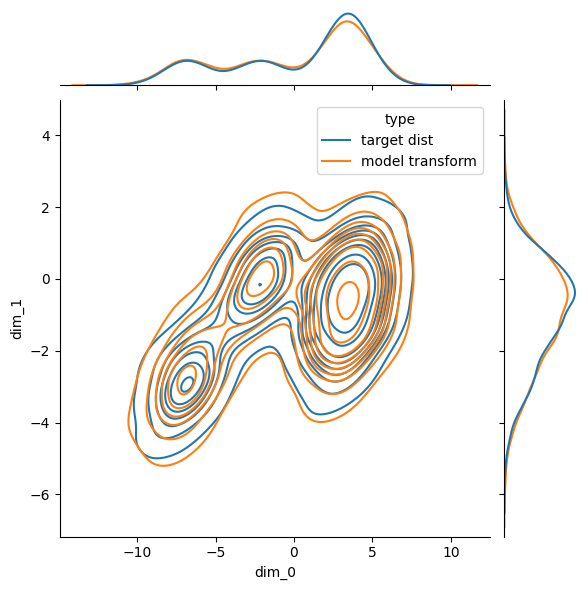

trail: 0 m step: 5 kl_test: 0.01113271713256836


  2%|▏         | 100/6000 [00:29<32:50,  2.99it/s]

trail: 0 m step: 6 Loss: 0.007012568702078708  L_n: 0.004597663879394531  kld: 0.001165628433227539 KLD1: 0.005229793954640627 KLD2: 0.00645780935883522


  3%|▎         | 200/6000 [00:58<33:02,  2.93it/s]

trail: 0 m step: 6 Loss: 0.008833936759906005  L_n: 0.0074558258056640625  kld: 0.0006651878356933594 KLD1: 0.006307120900601149 KLD2: 0.0029763937927782536


  5%|▌         | 300/6000 [01:27<31:10,  3.05it/s]

trail: 0 m step: 6 Loss: 0.00816859084115448  L_n: 0.005762577056884766  kld: 0.001161336898803711 KLD1: 0.00607459619641304 KLD2: 0.006277588661760092


  7%|▋         | 400/6000 [01:57<30:24,  3.07it/s]

trail: 0 m step: 6 Loss: 0.009443616840560255  L_n: 0.006735801696777344  kld: 0.0013070106506347656 KLD1: 0.006306178402155638 KLD2: 0.006928941700607538


  8%|▊         | 500/6000 [02:26<29:37,  3.09it/s]

trail: 0 m step: 6 Loss: 0.007649139683320184  L_n: 0.0064389705657958984  kld: 0.0005841255187988281 KLD1: 0.005102291237562895 KLD2: 0.007295671850442886


 10%|█         | 600/6000 [02:55<28:45,  3.13it/s]

trail: 0 m step: 6 Loss: 0.007019717277353228  L_n: 0.0038890838623046875  kld: 0.0015110969543457031 KLD1: 0.0040604593232274055 KLD2: 0.004012731369584799


 12%|█▏        | 700/6000 [03:25<28:30,  3.10it/s]

trail: 0 m step: 6 Loss: 0.010559907455844298  L_n: 0.0067021846771240234  kld: 0.0018620491027832031 KLD1: 0.005861249752342701 KLD2: 0.004208123777061701


 13%|█▎        | 800/6000 [03:54<27:43,  3.13it/s]

trail: 0 m step: 6 Loss: 0.00509022236831285  L_n: 0.004650115966796875  kld: 0.0002124309539794922 KLD1: 0.00740679819136858 KLD2: 0.006773277651518583


 15%|█▌        | 900/6000 [04:23<27:19,  3.11it/s]

trail: 0 m step: 6 Loss: 0.008934536982865036  L_n: 0.006152629852294922  kld: 0.0013427734375 KLD1: 0.005063740070909262 KLD2: 0.007085870020091534


 17%|█▋        | 1000/6000 [04:53<27:44,  3.00it/s]

trail: 0 m step: 6 Loss: 0.010289811436724373  L_n: 0.005068302154541016  kld: 0.002520322799682617 KLD1: 0.0023907034192234278 KLD2: 0.0058370293118059635


 18%|█▊        | 1100/6000 [05:22<26:19,  3.10it/s]

trail: 0 m step: 6 Loss: 0.009029558298877034  L_n: 0.006705045700073242  kld: 0.0011219978332519531 KLD1: 0.007111012004315853 KLD2: 0.006094497628509998


 20%|██        | 1201/6000 [05:52<22:20,  3.58it/s]

trail: 0 m step: 6 Loss: 0.007273876168252738  L_n: 0.004748821258544922  kld: 0.0012187957763671875 KLD1: 0.004856686107814312 KLD2: 0.004500125534832478


 22%|██▏       | 1300/6000 [06:21<25:24,  3.08it/s]

trail: 0 m step: 6 Loss: 0.007316189575211672  L_n: 0.0054624080657958984  kld: 0.0008947849273681641 KLD1: 0.005009826272726059 KLD2: 0.006574185099452734


 23%|██▎       | 1400/6000 [06:51<25:10,  3.05it/s]

trail: 0 m step: 6 Loss: 0.007815975855197946  L_n: 0.00579524040222168  kld: 0.0009753704071044922 KLD1: 0.006627831142395735 KLD2: 0.003911515232175589


 25%|██▌       | 1500/6000 [07:20<24:25,  3.07it/s]

trail: 0 m step: 6 Loss: 0.009037796194348557  L_n: 0.00568389892578125  kld: 0.0016188621520996094 KLD1: 0.00448241364210844 KLD2: 0.006262907292693853


 27%|██▋       | 1600/6000 [07:50<23:33,  3.11it/s]

trail: 0 m step: 6 Loss: 0.007160678965091871  L_n: 0.004420757293701172  kld: 0.0013225078582763672 KLD1: 0.004900818224996328 KLD2: 0.00577967893332243


 28%|██▊       | 1700/6000 [08:20<23:12,  3.09it/s]

trail: 0 m step: 6 Loss: 0.00981987417668715  L_n: 0.005321502685546875  kld: 0.0021712779998779297 KLD1: 0.004111065529286861 KLD2: 0.007020808290690184


 30%|███       | 1800/6000 [08:49<22:38,  3.09it/s]

trail: 0 m step: 6 Loss: 0.009822600312111953  L_n: 0.00669097900390625  kld: 0.0015115737915039062 KLD1: 0.00469142384827137 KLD2: 0.004474316257983446


 32%|███▏      | 1900/6000 [09:19<22:05,  3.09it/s]

trail: 0 m step: 6 Loss: 0.007605765608474036  L_n: 0.006071567535400391  kld: 0.0007405281066894531 KLD1: 0.005521458573639393 KLD2: 0.0047237989492714405


 33%|███▎      | 2000/6000 [09:48<21:32,  3.10it/s]

trail: 0 m step: 6 Loss: 0.007652420245229333  L_n: 0.004365205764770508  kld: 0.0015866756439208984 KLD1: 0.004727994091808796 KLD2: 0.0037546793464571238


 35%|███▌      | 2100/6000 [10:17<20:57,  3.10it/s]

trail: 0 m step: 6 Loss: 0.00743497528882653  L_n: 0.005779266357421875  kld: 0.0007991790771484375 KLD1: 0.006116354838013649 KLD2: 0.0038219657726585865


 37%|███▋      | 2200/6000 [10:47<20:25,  3.10it/s]

trail: 0 m step: 6 Loss: 0.0066262105443402886  L_n: 0.00442814826965332  kld: 0.0010609626770019531 KLD1: 0.0053808013908565044 KLD2: 0.006154550239443779


 38%|███▊      | 2300/6000 [11:16<19:50,  3.11it/s]

trail: 0 m step: 6 Loss: 0.009463904392256518  L_n: 0.006831169128417969  kld: 0.0012707710266113281 KLD1: 0.004777322988957167 KLD2: 0.006464667152613401


 40%|████      | 2400/6000 [11:46<19:22,  3.10it/s]

trail: 0 m step: 6 Loss: 0.0052388845860028895  L_n: 0.004430294036865234  kld: 0.0003902912139892578 KLD1: 0.005822556093335152 KLD2: 0.006652111653238535


 42%|████▏     | 2500/6000 [12:15<18:51,  3.09it/s]

trail: 0 m step: 6 Loss: 0.011609607155008899  L_n: 0.0076847076416015625  kld: 0.0018944740295410156 KLD1: 0.004342798143625259 KLD2: 0.005345570854842663


 43%|████▎     | 2600/6000 [12:44<18:17,  3.10it/s]

trail: 0 m step: 6 Loss: 0.007937882518108813  L_n: 0.004923820495605469  kld: 0.0014548301696777344 KLD1: 0.005045474972575903 KLD2: 0.004850219003856182


 45%|████▌     | 2700/6000 [13:14<17:43,  3.10it/s]

trail: 0 m step: 6 Loss: 0.008080882043657374  L_n: 0.005281686782836914  kld: 0.0013511180877685547 KLD1: 0.004788573365658522 KLD2: 0.005891620647162199


 47%|████▋     | 2800/6000 [13:43<17:16,  3.09it/s]

trail: 0 m step: 6 Loss: 0.005963611210352525  L_n: 0.004083156585693359  kld: 0.0009076595306396484 KLD1: 0.0064891730435192585 KLD2: 0.004272946622222662


 48%|████▊     | 2900/6000 [14:13<16:36,  3.11it/s]

trail: 0 m step: 6 Loss: 0.008756940747476821  L_n: 0.005815982818603516  kld: 0.0014195442199707031 KLD1: 0.0046121529303491116 KLD2: 0.0041019851341843605


 50%|█████     | 3000/6000 [14:42<16:10,  3.09it/s]

trail: 0 m step: 6 Loss: 0.005681895900535875  L_n: 0.003420114517211914  kld: 0.0010917186737060547 KLD1: 0.006010344717651606 KLD2: 0.0041396720334887505


 52%|█████▏    | 3100/6000 [15:12<15:32,  3.11it/s]

trail: 0 m step: 6 Loss: 0.005650962245967066  L_n: 0.0037522315979003906  kld: 0.0009164810180664062 KLD1: 0.006498252507299185 KLD2: 0.002611441072076559


 53%|█████▎    | 3200/6000 [15:41<14:26,  3.23it/s]

trail: 0 m step: 6 Loss: 0.009188699452456902  L_n: 0.0056149959564208984  kld: 0.0017249584197998047 KLD1: 0.0048041571862995625 KLD2: 0.006040565203875303


 55%|█████▌    | 3300/6000 [16:10<15:04,  2.99it/s]

trail: 0 m step: 6 Loss: 0.009045274472888738  L_n: 0.006418466567993164  kld: 0.0012679100036621094 KLD1: 0.004494962282478809 KLD2: 0.0049048964865505695


 57%|█████▋    | 3400/6000 [16:39<13:57,  3.10it/s]

trail: 0 m step: 6 Loss: 0.008644348992567583  L_n: 0.006276369094848633  kld: 0.0011429786682128906 KLD1: 0.005025490187108517 KLD2: 0.003969151992350817


 58%|█████▊    | 3500/6000 [17:09<13:35,  3.07it/s]

trail: 0 m step: 6 Loss: 0.0075779015749401005  L_n: 0.005216836929321289  kld: 0.0011396408081054688 KLD1: 0.0048953332006931305 KLD2: 0.005837098695337772


 60%|██████    | 3600/6000 [17:38<12:53,  3.10it/s]

trail: 0 m step: 6 Loss: 0.009947759049254573  L_n: 0.0072019100189208984  kld: 0.001325368881225586 KLD1: 0.005324119236320257 KLD2: 0.004544610623270273


 62%|██████▏   | 3700/6000 [18:07<12:32,  3.06it/s]

trail: 0 m step: 6 Loss: 0.006466007383635848  L_n: 0.0032281875610351562  kld: 0.0015628337860107422 KLD1: 0.004633163567632437 KLD2: 0.004915296100080013


 63%|██████▎   | 3800/6000 [18:37<11:50,  3.10it/s]

trail: 0 m step: 6 Loss: 0.008372152087012188  L_n: 0.0053136348724365234  kld: 0.001476287841796875 KLD1: 0.004623385611921549 KLD2: 0.004539418499916792


 65%|██████▌   | 3900/6000 [19:06<11:13,  3.12it/s]

trail: 0 m step: 6 Loss: 0.009368874053618735  L_n: 0.006017446517944336  kld: 0.0016176700592041016 KLD1: 0.0038600959815084934 KLD2: 0.0038408159743994474


 67%|██████▋   | 4000/6000 [19:36<10:42,  3.11it/s]

trail: 0 m step: 6 Loss: 0.009488998345420392  L_n: 0.006166219711303711  kld: 0.001603841781616211 KLD1: 0.005126532632857561 KLD2: 0.00486797234043479


 68%|██████▊   | 4100/6000 [20:05<10:18,  3.07it/s]

trail: 0 m step: 6 Loss: 0.00484629538192576  L_n: 0.0027618408203125  kld: 0.0010061264038085938 KLD1: 0.0070273918099701405 KLD2: 0.005852116271853447


 70%|███████   | 4200/6000 [20:34<09:40,  3.10it/s]

trail: 0 m step: 6 Loss: 0.006478847180764094  L_n: 0.0036687850952148438  kld: 0.001356363296508789 KLD1: 0.004918415565043688 KLD2: 0.004606905393302441


 72%|███████▏  | 4300/6000 [21:04<09:16,  3.06it/s]

trail: 0 m step: 6 Loss: 0.006940656407692937  L_n: 0.0048122406005859375  kld: 0.0010273456573486328 KLD1: 0.005705257877707481 KLD2: 0.004667340777814388


 73%|███████▎  | 4400/6000 [21:33<08:35,  3.10it/s]

trail: 0 m step: 6 Loss: 0.008343272908547429  L_n: 0.00621485710144043  kld: 0.0010273456573486328 KLD1: 0.00465245358645916 KLD2: 0.005269966088235378


 75%|███████▌  | 4500/6000 [22:03<08:03,  3.10it/s]

trail: 0 m step: 6 Loss: 0.005756168530156354  L_n: 0.004096508026123047  kld: 0.00080108642578125 KLD1: 0.005924005061388016 KLD2: 0.004025414120405912


 77%|███████▋  | 4600/6000 [22:32<07:33,  3.08it/s]

trail: 0 m step: 6 Loss: 0.009387067111486753  L_n: 0.004945993423461914  kld: 0.0021436214447021484 KLD1: 0.004020672291517258 KLD2: 0.0039576697163283825


 78%|███████▊  | 4700/6000 [23:01<07:04,  3.07it/s]

trail: 0 m step: 6 Loss: 0.0074520834184235475  L_n: 0.005839347839355469  kld: 0.0007784366607666016 KLD1: 0.006156993564218283 KLD2: 0.005819140467792749


 80%|████████  | 4800/6000 [23:30<06:27,  3.10it/s]

trail: 0 m step: 6 Loss: 0.007463079093019538  L_n: 0.005250692367553711  kld: 0.0010678768157958984 KLD1: 0.004683011677116156 KLD2: 0.00441577797755599


 82%|████████▏ | 4900/6000 [24:00<05:56,  3.09it/s]

trail: 0 m step: 6 Loss: 0.007618033766363935  L_n: 0.005619525909423828  kld: 0.0009646415710449219 KLD1: 0.005471196491271257 KLD2: 0.005344705656170845


 83%|████████▎ | 5000/6000 [24:29<05:24,  3.08it/s]

trail: 0 m step: 6 Loss: 0.007692250382146033  L_n: 0.0056917667388916016  kld: 0.0009655952453613281 KLD1: 0.006205122452229261 KLD2: 0.004903328604996204


 85%|████████▌ | 5100/6000 [24:58<04:49,  3.10it/s]

trail: 0 m step: 6 Loss: 0.00780354088527534  L_n: 0.004744529724121094  kld: 0.0014765262603759766 KLD1: 0.004115717019885778 KLD2: 0.00632793502882123


 87%|████████▋ | 5200/6000 [25:28<04:17,  3.11it/s]

trail: 0 m step: 6 Loss: 0.006984066927992228  L_n: 0.0051648616790771484  kld: 0.0008780956268310547 KLD1: 0.00608255248516798 KLD2: 0.004583178553730249


 88%|████████▊ | 5300/6000 [25:57<03:45,  3.10it/s]

trail: 0 m step: 6 Loss: 0.008538191315551742  L_n: 0.007080554962158203  kld: 0.0007035732269287109 KLD1: 0.006695070303976536 KLD2: 0.005035887937992811


 90%|█████████ | 5400/6000 [26:27<03:12,  3.11it/s]

trail: 0 m step: 6 Loss: 0.0058717202696684885  L_n: 0.0047168731689453125  kld: 0.0005574226379394531 KLD1: 0.006278680171817541 KLD2: 0.005543668754398823


 92%|█████████▏| 5500/6000 [26:56<02:43,  3.06it/s]

trail: 0 m step: 6 Loss: 0.009182277088506616  L_n: 0.006785154342651367  kld: 0.0011570453643798828 KLD1: 0.0052539450116455555 KLD2: 0.004627926740795374


 93%|█████████▎| 5600/6000 [27:25<02:06,  3.16it/s]

trail: 0 m step: 6 Loss: 0.007893241171549712  L_n: 0.005445241928100586  kld: 0.0011816024780273438 KLD1: 0.005548335146158934 KLD2: 0.004546395968645811


 95%|█████████▌| 5700/6000 [27:55<01:36,  3.10it/s]

trail: 0 m step: 6 Loss: 0.005838798350064755  L_n: 0.0044918060302734375  kld: 0.0006501674652099609 KLD1: 0.005695536732673645 KLD2: 0.006737966556102037


 97%|█████████▋| 5800/6000 [28:24<01:04,  3.11it/s]

trail: 0 m step: 6 Loss: 0.0073898064254493455  L_n: 0.005028247833251953  kld: 0.0011398792266845703 KLD1: 0.005656483583152294 KLD2: 0.005178042221814394


 98%|█████████▊| 5900/6000 [28:53<00:32,  3.11it/s]

trail: 0 m step: 6 Loss: 0.007019109541190442  L_n: 0.003961086273193359  kld: 0.0014760494232177734 KLD1: 0.004054154735058546 KLD2: 0.005308420397341251


100%|██████████| 6000/6000 [29:23<00:00,  3.40it/s]

trail: 0 m step: 6 Loss: 0.006607935108235261  L_n: 0.0040013790130615234  kld: 0.0012581348419189453 KLD1: 0.005421748850494623 KLD2: 0.004639528691768646



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


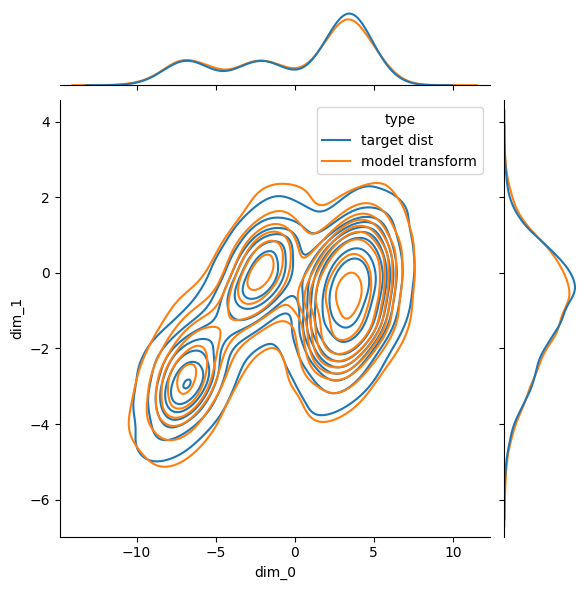

trail: 0 m step: 6 kl_test: 0.0059964656829833984


  2%|▏         | 100/6000 [00:28<31:25,  3.13it/s]

trail: 0 m step: 7 Loss: 0.00311354667089144  L_n: 0.0017681121826171875  kld: 0.0008442401885986328 KLD1: 0.0017486130818724632 KLD2: 0.0032950895838439465


  3%|▎         | 200/6000 [00:57<31:29,  3.07it/s]

trail: 0 m step: 7 Loss: 0.004349273868474049  L_n: 0.003892183303833008  kld: 0.0002868175506591797 KLD1: 0.0030935846734791994 KLD2: 0.0009534250129945576


  5%|▌         | 300/6000 [01:26<31:02,  3.06it/s]

trail: 0 m step: 7 Loss: 0.0037654616534205246  L_n: 0.002631664276123047  kld: 0.0007114410400390625 KLD1: 0.0026515035424381495 KLD2: 0.003268105210736394


  7%|▋         | 400/6000 [01:56<30:23,  3.07it/s]

trail: 0 m step: 7 Loss: 0.005188432531646733  L_n: 0.003633260726928711  kld: 0.0009758472442626953 KLD1: 0.003455911995843053 KLD2: 0.0034880239982157946


  8%|▊         | 500/6000 [02:25<29:33,  3.10it/s]

trail: 0 m step: 7 Loss: 0.003909933497648954  L_n: 0.003553152084350586  kld: 0.0002238750457763672 KLD1: 0.0019855345599353313 KLD2: 0.0040681492537260056


 10%|█         | 600/6000 [02:54<28:54,  3.11it/s]

trail: 0 m step: 7 Loss: 0.0031848937328375544  L_n: 0.0014348030090332031  kld: 0.0010981559753417969 KLD1: 0.0015386692248284817 KLD2: 0.0017861896194517612


 12%|█▏        | 700/6000 [03:24<28:58,  3.05it/s]

trail: 0 m step: 7 Loss: 0.005701371092851605  L_n: 0.0035238265991210938  kld: 0.0013663768768310547 KLD1: 0.002896481892094016 KLD2: 0.0018287601415067911


 13%|█▎        | 800/6000 [03:54<27:48,  3.12it/s]

trail: 0 m step: 7 Loss: 0.0017217463292973209  L_n: 0.0017054080963134766  kld: 1.0251998901367188e-05 KLD1: 0.0038551860488951206 KLD2: 0.0034032328985631466


 15%|█▌        | 900/6000 [04:23<26:21,  3.23it/s]

trail: 0 m step: 7 Loss: 0.004479111680080982  L_n: 0.0030014514923095703  kld: 0.0009272098541259766 KLD1: 0.0023548502940684557 KLD2: 0.003632877254858613


 17%|█▋        | 1001/6000 [04:52<22:39,  3.68it/s]

trail: 0 m step: 7 Loss: 0.004926223661669924  L_n: 0.001992940902709961  kld: 0.0018405914306640625 KLD1: 0.0003848661726806313 KLD2: 0.0029297529254108667


 18%|█▊        | 1100/6000 [05:21<26:34,  3.07it/s]

trail: 0 m step: 7 Loss: 0.004948717557126412  L_n: 0.003667116165161133  kld: 0.0008041858673095703 KLD1: 0.0038515455089509487 KLD2: 0.0030285597313195467


 20%|██        | 1201/6000 [05:51<21:40,  3.69it/s]

trail: 0 m step: 7 Loss: 0.0031617824985206355  L_n: 0.001967191696166992  kld: 0.0007495880126953125 KLD1: 0.00200403924100101 KLD2: 0.002072361996397376


 22%|██▏       | 1300/6000 [06:19<25:20,  3.09it/s]

trail: 0 m step: 7 Loss: 0.0033016003480537195  L_n: 0.0023851394653320312  kld: 0.0005750656127929688 KLD1: 0.001879335381090641 KLD2: 0.0033586532808840275


 23%|██▎       | 1400/6000 [06:49<24:50,  3.09it/s]

trail: 0 m step: 7 Loss: 0.003944767662932673  L_n: 0.0030906200408935547  kld: 0.0005359649658203125 KLD1: 0.003292027162387967 KLD2: 0.0015008163172751665


 25%|██▌       | 1500/6000 [07:18<24:09,  3.11it/s]

trail: 0 m step: 7 Loss: 0.004818163314637668  L_n: 0.002758026123046875  kld: 0.0012927055358886719 KLD1: 0.002120983088389039 KLD2: 0.003261155914515257


 27%|██▋       | 1600/6000 [07:47<23:38,  3.10it/s]

trail: 0 m step: 7 Loss: 0.003031318898538503  L_n: 0.001764535903930664  kld: 0.0007948875427246094 KLD1: 0.002322698477655649 KLD2: 0.002909779315814376


 28%|██▊       | 1700/6000 [08:16<23:01,  3.11it/s]

trail: 0 m step: 7 Loss: 0.004859462347864572  L_n: 0.002260923385620117  kld: 0.001630544662475586 KLD1: 0.0013872644631192088 KLD2: 0.0037346030585467815


 30%|███       | 1800/6000 [08:46<23:19,  3.00it/s]

trail: 0 m step: 7 Loss: 0.0048901711555380725  L_n: 0.003203153610229492  kld: 0.0010585784912109375 KLD1: 0.002451924839988351 KLD2: 0.0018915614346042275


 32%|███▏      | 1900/6000 [09:15<21:59,  3.11it/s]

trail: 0 m step: 7 Loss: 0.0033462842805172593  L_n: 0.002754688262939453  kld: 0.0003712177276611328 KLD1: 0.0028217597864568233 KLD2: 0.0021463134326040745


 33%|███▎      | 2000/6000 [09:44<22:06,  3.02it/s]

trail: 0 m step: 7 Loss: 0.003971987282228439  L_n: 0.002072572708129883  kld: 0.001191854476928711 KLD1: 0.0022258106619119644 KLD2: 0.0017115031369030476


 35%|███▌      | 2100/6000 [10:13<21:13,  3.06it/s]

trail: 0 m step: 7 Loss: 0.0034091409103822455  L_n: 0.0024721622467041016  kld: 0.0005879402160644531 KLD1: 0.0025530995335429907 KLD2: 0.0015335794305428863


 37%|███▋      | 2200/6000 [10:42<20:21,  3.11it/s]

trail: 0 m step: 7 Loss: 0.0035554515970325855  L_n: 0.0022749900817871094  kld: 0.0008034706115722656 KLD1: 0.0022188760340213776 KLD2: 0.00303650158457458


 38%|███▊      | 2300/6000 [11:12<20:05,  3.07it/s]

trail: 0 m step: 7 Loss: 0.004613884040083556  L_n: 0.0035245418548583984  kld: 0.0006835460662841797 KLD1: 0.0019482927164062858 KLD2: 0.003276494098827243


 40%|████      | 2400/6000 [11:41<19:18,  3.11it/s]

trail: 0 m step: 7 Loss: 0.001894733389198093  L_n: 0.0017321109771728516  kld: 0.00010204315185546875 KLD1: 0.0022709707263857126 KLD2: 0.0032920169178396463


 42%|████▏     | 2500/6000 [12:10<19:34,  2.98it/s]

trail: 0 m step: 7 Loss: 0.006185002582950258  L_n: 0.0041332244873046875  kld: 0.0012874603271484375 KLD1: 0.0017937738448381424 KLD2: 0.0025448789820075035


 43%|████▎     | 2600/6000 [12:40<18:34,  3.05it/s]

trail: 0 m step: 7 Loss: 0.0037229684165921905  L_n: 0.0021317005157470703  kld: 0.0009984970092773438 KLD1: 0.0020423491951078176 KLD2: 0.002174791879951954


 45%|████▌     | 2700/6000 [13:09<17:41,  3.11it/s]

trail: 0 m step: 7 Loss: 0.003899785678133755  L_n: 0.002310037612915039  kld: 0.0009975433349609375 KLD1: 0.0019100699573755264 KLD2: 0.002753090113401413


 47%|████▋     | 2800/6000 [13:38<17:30,  3.05it/s]

trail: 0 m step: 7 Loss: 0.0025686992521511236  L_n: 0.0014717578887939453  kld: 0.0006883144378662109 KLD1: 0.0028418912552297115 KLD2: 0.0017656205454841256


 48%|████▊     | 2900/6000 [14:07<16:25,  3.15it/s]

trail: 0 m step: 7 Loss: 0.004473399312370427  L_n: 0.0026264190673828125  kld: 0.0011589527130126953 KLD1: 0.0021150882821530104 KLD2: 0.0016436801524832845


 50%|█████     | 3000/6000 [14:36<16:19,  3.06it/s]

trail: 0 m step: 7 Loss: 0.002472333354290036  L_n: 0.001100301742553711  kld: 0.0008609294891357422 KLD1: 0.0030458439141511917 KLD2: 0.0017891139723360538


 52%|█████▏    | 3100/6000 [15:06<15:38,  3.09it/s]

trail: 0 m step: 7 Loss: 0.002319234694626241  L_n: 0.0014183521270751953  kld: 0.0005652904510498047 KLD1: 0.003259270451962948 KLD2: 0.0005821920931339264


 53%|█████▎    | 3200/6000 [15:35<14:09,  3.30it/s]

trail: 0 m step: 7 Loss: 0.005110739356648429  L_n: 0.0030357837677001953  kld: 0.0013020038604736328 KLD1: 0.002026454545557499 KLD2: 0.0029826206155121326


 55%|█████▌    | 3300/6000 [16:04<13:59,  3.22it/s]

trail: 0 m step: 7 Loss: 0.004834169160538913  L_n: 0.0033576488494873047  kld: 0.0009264945983886719 KLD1: 0.0017018740763887763 KLD2: 0.002239122288301587


 57%|█████▋    | 3400/6000 [16:33<13:54,  3.11it/s]

trail: 0 m step: 7 Loss: 0.003963419711064875  L_n: 0.002895355224609375  kld: 0.0006701946258544922 KLD1: 0.0022737886756658554 KLD2: 0.0016465573571622372


 58%|█████▊    | 3500/6000 [17:03<13:25,  3.10it/s]

trail: 0 m step: 7 Loss: 0.0035663052738267535  L_n: 0.002389192581176758  kld: 0.0007386207580566406 KLD1: 0.002221100265160203 KLD2: 0.0026364573277533054


 60%|██████    | 3600/6000 [17:32<12:53,  3.10it/s]

trail: 0 m step: 7 Loss: 0.004697154681076535  L_n: 0.003251791000366211  kld: 0.0009069442749023438 KLD1: 0.0025285326410084963 KLD2: 0.002045215340331197


 62%|██████▏   | 3700/6000 [18:01<12:22,  3.10it/s]

trail: 0 m step: 7 Loss: 0.0028670693087873437  L_n: 0.001161813735961914  kld: 0.0010700225830078125 KLD1: 0.001597166177816689 KLD2: 0.002129301428794861


 63%|██████▎   | 3800/6000 [18:30<11:45,  3.12it/s]

trail: 0 m step: 7 Loss: 0.0037969135628683186  L_n: 0.0020346641540527344  kld: 0.0011057853698730469 KLD1: 0.0017979869153350592 KLD2: 0.002135536167770624


 65%|██████▌   | 3900/6000 [18:59<11:17,  3.10it/s]

trail: 0 m step: 7 Loss: 0.004423000485241628  L_n: 0.0027925968170166016  kld: 0.0010230541229248047 KLD1: 0.0017939454410225153 KLD2: 0.0017991767963394523


 67%|██████▋   | 4000/6000 [19:29<10:44,  3.10it/s]

trail: 0 m step: 7 Loss: 0.0052760042487321876  L_n: 0.003403186798095703  kld: 0.0011751651763916016 KLD1: 0.0021345331333577633 KLD2: 0.002150259679183364


 68%|██████▊   | 4100/6000 [19:58<10:10,  3.11it/s]

trail: 0 m step: 7 Loss: 0.0017116957842092761  L_n: 0.0006067752838134766  kld: 0.0006933212280273438 KLD1: 0.0031094488222151995 KLD2: 0.0028515912126749754


 70%|███████   | 4200/6000 [20:27<09:39,  3.11it/s]

trail: 0 m step: 7 Loss: 0.0027313182217334727  L_n: 0.001135110855102539  kld: 0.001001596450805664 KLD1: 0.001751644886098802 KLD2: 0.0019371408270671964


 72%|███████▏  | 4300/6000 [20:56<09:08,  3.10it/s]

trail: 0 m step: 7 Loss: 0.0029238020572078987  L_n: 0.0018393993377685547  kld: 0.0006804466247558594 KLD1: 0.002535928739234805 KLD2: 0.0021093180403113365


 73%|███████▎  | 4400/6000 [21:25<08:37,  3.09it/s]

trail: 0 m step: 7 Loss: 0.003533756565032843  L_n: 0.0024094581604003906  kld: 0.0007054805755615234 KLD1: 0.0019265998853370547 KLD2: 0.0025549549609422684


 75%|███████▌  | 4500/6000 [21:54<07:59,  3.13it/s]

trail: 0 m step: 7 Loss: 0.0020367937610576104  L_n: 0.0011932849884033203  kld: 0.0005292892456054688 KLD1: 0.002886074362322688 KLD2: 0.0016232851194217801


 77%|███████▋  | 4600/6000 [22:23<07:30,  3.11it/s]

trail: 0 m step: 7 Loss: 0.005111939140162979  L_n: 0.0026311874389648438  kld: 0.0015566349029541016 KLD1: 0.00159794045612216 KLD2: 0.001690072938799858


 78%|███████▊  | 4700/6000 [22:52<07:01,  3.08it/s]

trail: 0 m step: 7 Loss: 0.0032234969910585084  L_n: 0.0024635791778564453  kld: 0.000476837158203125 KLD1: 0.002588468138128519 KLD2: 0.0027676699683070183


 80%|████████  | 4800/6000 [23:21<06:27,  3.10it/s]

trail: 0 m step: 7 Loss: 0.003356613548329222  L_n: 0.0022687911987304688  kld: 0.0006825923919677734 KLD1: 0.0019987309351563454 KLD2: 0.0018412681529298425


 82%|████████▏ | 4900/6000 [23:51<06:09,  2.98it/s]

trail: 0 m step: 7 Loss: 0.0032069537386813663  L_n: 0.0022559165954589844  kld: 0.0005967617034912109 KLD1: 0.002525224583223462 KLD2: 0.002494165673851967


 83%|████████▎ | 5000/6000 [24:20<05:48,  2.87it/s]

trail: 0 m step: 7 Loss: 0.0038740360687241574  L_n: 0.0028238296508789062  kld: 0.0006589889526367188 KLD1: 0.002975563518702984 KLD2: 0.002226333599537611


 85%|████████▌ | 5100/6000 [24:49<04:43,  3.18it/s]

trail: 0 m step: 7 Loss: 0.003812629839404333  L_n: 0.0021054744720458984  kld: 0.0010712146759033203 KLD1: 0.0018723163520917296 KLD2: 0.003139203181490302


 87%|████████▋ | 5201/6000 [25:19<03:37,  3.68it/s]

trail: 0 m step: 7 Loss: 0.0031613642364202096  L_n: 0.002221345901489258  kld: 0.0005898475646972656 KLD1: 0.0028771578799933195 KLD2: 0.00211169570684433


 88%|████████▊ | 5300/6000 [25:48<03:47,  3.08it/s]

trail: 0 m step: 7 Loss: 0.004737479618221692  L_n: 0.004019737243652344  kld: 0.00045037269592285156 KLD1: 0.0033139814622700214 KLD2: 0.0022949299309402704


 90%|█████████ | 5400/6000 [26:17<03:21,  2.98it/s]

trail: 0 m step: 7 Loss: 0.002776682679011544  L_n: 0.0023720264434814453  kld: 0.00025391578674316406 KLD1: 0.0028580601792782545 KLD2: 0.0026361565105617046


 92%|█████████▏| 5500/6000 [26:46<02:43,  3.06it/s]

trail: 0 m step: 7 Loss: 0.0044756173012746045  L_n: 0.003270387649536133  kld: 0.0007562637329101562 KLD1: 0.0025164305698126554 KLD2: 0.0020843730308115482


 93%|█████████▎| 5600/6000 [27:15<02:06,  3.16it/s]

trail: 0 m step: 7 Loss: 0.0035569842869423705  L_n: 0.0023741722106933594  kld: 0.0007421970367431641 KLD1: 0.002735150745138526 KLD2: 0.002002420835196972


 95%|█████████▌| 5700/6000 [27:44<01:37,  3.09it/s]

trail: 0 m step: 7 Loss: 0.0023052932353693992  L_n: 0.001651763916015625  kld: 0.0004100799560546875 KLD1: 0.002655060961842537 KLD2: 0.0037675139028578997


 97%|█████████▋| 5800/6000 [28:13<01:04,  3.09it/s]

trail: 0 m step: 7 Loss: 0.003520272996116144  L_n: 0.0021588802337646484  kld: 0.0008542537689208984 KLD1: 0.002299662446603179 KLD2: 0.0024238270707428455


 98%|█████████▊| 5900/6000 [28:43<00:32,  3.09it/s]

trail: 0 m step: 7 Loss: 0.003386295407986629  L_n: 0.0017285346984863281  kld: 0.0010402202606201172 KLD1: 0.0015374674694612622 KLD2: 0.0024768717121332884


100%|██████████| 6000/6000 [29:11<00:00,  3.42it/s]

trail: 0 m step: 7 Loss: 0.0031402295395431797  L_n: 0.0018377304077148438  kld: 0.0008172988891601562 KLD1: 0.002301526488736272 KLD2: 0.001913366257213056



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


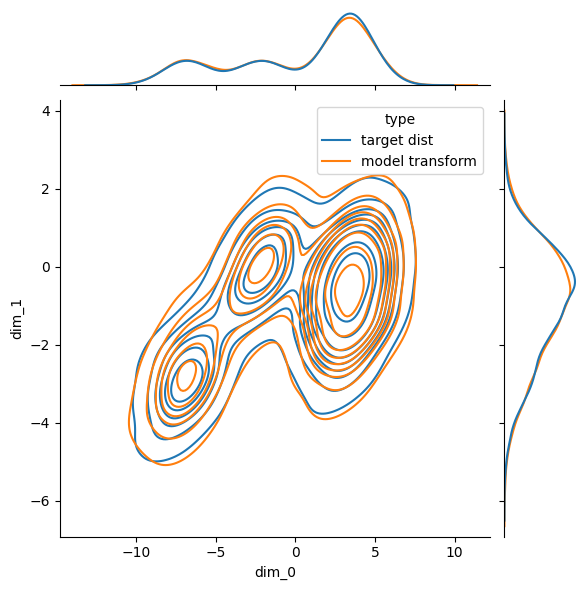

trail: 0 m step: 7 kl_test: 0.002946138381958008


  2%|▏         | 100/6000 [00:28<31:12,  3.15it/s]

trail: 0 m step: 8 Loss: 0.0016695012056142837  L_n: 0.0011074542999267578  kld: 0.0004584789276123047 KLD1: 0.0004276654217392206 KLD2: 0.0018423880683258176


  3%|▎         | 200/6000 [00:56<27:40,  3.49it/s]

trail: 0 m step: 8 Loss: 0.0018658638000488281  L_n: 0.0018658638000488281  kld: 0.0 KLD1: 0.0016336172120645642 KLD2: 0.00012056565174134448


  5%|▌         | 300/6000 [01:25<30:38,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0018833200065481095  L_n: 0.0013797283172607422  kld: 0.0004107952117919922 KLD1: 0.0012657929910346866 KLD2: 0.0017997764516621828


  7%|▋         | 400/6000 [01:54<30:06,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0029573521886085783  L_n: 0.002096891403198242  kld: 0.000701904296875 KLD1: 0.0021448496263474226 KLD2: 0.0018300878582522273


  8%|▊         | 500/6000 [02:23<29:32,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0018344503203273125  L_n: 0.001779794692993164  kld: 4.458427429199219e-05 KLD1: 0.0006767823942936957 KLD2: 0.002384091494604945


 10%|█         | 600/6000 [02:51<27:41,  3.25it/s]

trail: 0 m step: 8 Loss: 0.0015748042078465628  L_n: 0.0006740093231201172  kld: 0.0007348060607910156 KLD1: 0.0006910227821208537 KLD2: 0.000789910031016916


 12%|█▏        | 700/6000 [03:21<28:22,  3.11it/s]

trail: 0 m step: 8 Loss: 0.002887447460386594  L_n: 0.001733541488647461  kld: 0.0009412765502929688 KLD1: 0.0016239011893048882 KLD2: 0.0007551623857580125


 13%|█▎        | 800/6000 [03:49<23:51,  3.63it/s]

trail: 0 m step: 8 Loss: 0.0006766319274902344  L_n: 0.0006766319274902344  kld: 0.0 KLD1: 0.001945336116477847 KLD2: 0.0016965338727459311


 15%|█▌        | 900/6000 [04:18<25:38,  3.31it/s]

trail: 0 m step: 8 Loss: 0.0021640193855041365  L_n: 0.001500844955444336  kld: 0.0005409717559814453 KLD1: 0.0012359964894130826 KLD2: 0.002043753629550338


 17%|█▋        | 1001/6000 [04:47<22:37,  3.68it/s]

trail: 0 m step: 8 Loss: 0.0023626026390078736  L_n: 0.0009012222290039062  kld: 0.0011920928955078125 KLD1: -0.00017781888891477138 KLD2: 0.00154258799739182


 18%|█▊        | 1100/6000 [05:15<26:23,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0026778455051503173  L_n: 0.0018618106842041016  kld: 0.0006656646728515625 KLD1: 0.0020201588049530983 KLD2: 0.0016012589912861586


 20%|██        | 1201/6000 [05:44<21:22,  3.74it/s]

trail: 0 m step: 8 Loss: 0.001599437664829984  L_n: 0.0010268688201904297  kld: 0.00046706199645996094 KLD1: 0.0009804535657167435 KLD2: 0.0009703622781671584


 22%|██▏       | 1300/6000 [06:14<25:14,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0015841677826526753  L_n: 0.001165628433227539  kld: 0.0003414154052734375 KLD1: 0.0006083292537368834 KLD2: 0.001832845970056951


 23%|██▎       | 1400/6000 [06:43<24:39,  3.11it/s]

trail: 0 m step: 8 Loss: 0.002105417152126544  L_n: 0.0017266273498535156  kld: 0.000308990478515625 KLD1: 0.001878773095086217 KLD2: 0.0006449415814131498


 25%|██▌       | 1500/6000 [07:11<24:41,  3.04it/s]

trail: 0 m step: 8 Loss: 0.0027113776485636217  L_n: 0.0015788078308105469  kld: 0.0009238719940185547 KLD1: 0.0012356929946690798 KLD2: 0.001847983105108142


 27%|██▋       | 1600/6000 [07:40<23:29,  3.12it/s]

trail: 0 m step: 8 Loss: 0.0010279181642582167  L_n: 0.0005538463592529297  kld: 0.0003867149353027344 KLD1: 0.0014540128177031875 KLD2: 0.0015339701203629375


 28%|██▊       | 1700/6000 [08:09<23:02,  3.11it/s]

trail: 0 m step: 8 Loss: 0.002394387851026455  L_n: 0.0009520053863525391  kld: 0.001176595687866211 KLD1: 0.0005778975319117308 KLD2: 0.0020298168528825045


 30%|███       | 1800/6000 [08:38<22:32,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0025850264918879737  L_n: 0.0018379688262939453  kld: 0.0006093978881835938 KLD1: 0.0010727874469012022 KLD2: 0.0007858423632569611


 32%|███▏      | 1900/6000 [09:07<21:33,  3.17it/s]

trail: 0 m step: 8 Loss: 0.0015267431865071414  L_n: 0.0013797283172607422  kld: 0.00011992454528808594 KLD1: 0.001389272278174758 KLD2: 0.0009651925647631288


 33%|███▎      | 2000/6000 [09:36<21:31,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0021580620339057017  L_n: 0.001131296157836914  kld: 0.0008375644683837891 KLD1: 0.0011029996676370502 KLD2: 0.0008851660531945527


 35%|███▌      | 2100/6000 [10:04<20:10,  3.22it/s]

trail: 0 m step: 8 Loss: 0.0015548699036777517  L_n: 0.0011801719665527344  kld: 0.0003056526184082031 KLD1: 0.0011887437431141734 KLD2: 0.0005505675217136741


 37%|███▋      | 2200/6000 [10:32<19:57,  3.17it/s]

trail: 0 m step: 8 Loss: 0.0015407538678271094  L_n: 0.0009968280792236328  kld: 0.0004436969757080078 KLD1: 0.0009259178768843412 KLD2: 0.0015016559045761824


 38%|███▊      | 2300/6000 [11:01<19:47,  3.12it/s]

trail: 0 m step: 8 Loss: 0.0022181103363626835  L_n: 0.0018656253814697266  kld: 0.0002875328063964844 KLD1: 0.0008188509964384139 KLD2: 0.0016190409660339355


 40%|████      | 2400/6000 [11:29<17:11,  3.49it/s]

trail: 0 m step: 8 Loss: 0.0006203651428222656  L_n: 0.0006203651428222656  kld: 0.0 KLD1: 0.0005668594967573881 KLD2: 0.001573370536789298


 42%|████▏     | 2500/6000 [11:58<18:33,  3.14it/s]

trail: 0 m step: 8 Loss: 0.003399938385376824  L_n: 0.002264738082885742  kld: 0.0009260177612304688 KLD1: 0.0005614302353933454 KLD2: 0.0010825223289430141


 43%|████▎     | 2600/6000 [12:26<18:15,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0018102219748531976  L_n: 0.0011417865753173828  kld: 0.0005452632904052734 KLD1: 0.000976915704086423 KLD2: 0.0010496892500668764


 45%|████▌     | 2700/6000 [12:55<17:34,  3.13it/s]

trail: 0 m step: 8 Loss: 0.0016741545344909773  L_n: 0.0008940696716308594  kld: 0.0006363391876220703 KLD1: 0.0007686522440053523 KLD2: 0.001295101479627192


 47%|████▋     | 2800/6000 [13:23<17:07,  3.11it/s]

trail: 0 m step: 8 Loss: 0.0011153947942209854  L_n: 0.0006401538848876953  kld: 0.0003876686096191406 KLD1: 0.0013441930059343576 KLD2: 0.0008191345259547234


 48%|████▊     | 2900/6000 [13:52<16:27,  3.14it/s]

trail: 0 m step: 8 Loss: 0.0022173678273035317  L_n: 0.0011754035949707031  kld: 0.0008499622344970703 KLD1: 0.0010373325785622 KLD2: 0.0006338274688459933


 50%|█████     | 3000/6000 [14:21<16:03,  3.11it/s]

trail: 0 m step: 8 Loss: 0.0009468163456564212  L_n: 0.00027370452880859375  kld: 0.0005490779876708984 KLD1: 0.0015392947243526578 KLD2: 0.0008089179755188525


 52%|█████▏    | 3100/6000 [14:49<15:25,  3.13it/s]

trail: 0 m step: 8 Loss: 0.001040847327502673  L_n: 0.0006635189056396484  kld: 0.0003077983856201172 KLD1: 0.0015363881830126047 KLD2: -7.094843022059649e-05


 53%|█████▎    | 3200/6000 [15:18<14:09,  3.30it/s]

trail: 0 m step: 8 Loss: 0.002517059931300289  L_n: 0.0013689994812011719  kld: 0.0009365081787109375 KLD1: 0.0009791050106287003 KLD2: 0.0014490955509245396


 55%|█████▌    | 3300/6000 [15:47<13:58,  3.22it/s]

trail: 0 m step: 8 Loss: 0.0024483962827247406  L_n: 0.001821756362915039  kld: 0.00051116943359375 KLD1: 0.0004746688646264374 KLD2: 0.0010533023159950972


 57%|█████▋    | 3400/6000 [16:16<13:55,  3.11it/s]

trail: 0 m step: 8 Loss: 0.0016462104707219809  L_n: 0.0012273788452148438  kld: 0.00034165382385253906 KLD1: 0.0010003643110394478 KLD2: 0.0007345796329900622


 58%|█████▊    | 3501/6000 [16:45<11:20,  3.67it/s]

trail: 0 m step: 8 Loss: 0.001779718249789389  L_n: 0.0012392997741699219  kld: 0.00044083595275878906 KLD1: 0.000949452689383179 KLD2: 0.0010149073787033558


 60%|██████    | 3600/6000 [17:13<12:50,  3.12it/s]

trail: 0 m step: 8 Loss: 0.0021017639275018023  L_n: 0.0015099048614501953  kld: 0.00048279762268066406 KLD1: 0.0014359225751832128 KLD2: 0.0010206326842308044


 62%|██████▏   | 3700/6000 [17:42<12:20,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0015823613739944728  L_n: 0.0007233619689941406  kld: 0.0007007122039794922 KLD1: 0.00038855517050251365 KLD2: 0.0008037628722377121


 63%|██████▎   | 3800/6000 [18:11<11:45,  3.12it/s]

trail: 0 m step: 8 Loss: 0.0018483143376025685  L_n: 0.0009770393371582031  kld: 0.0007107257843017578 KLD1: 0.0008258800371550024 KLD2: 0.0010841158218681812


 65%|██████▌   | 3900/6000 [18:40<11:16,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0019407735140205425  L_n: 0.0011913776397705078  kld: 0.0006113052368164062 KLD1: 0.000613726326264441 KLD2: 0.0009918591240420938


 67%|██████▋   | 4000/6000 [19:09<10:18,  3.23it/s]

trail: 0 m step: 8 Loss: 0.0027610508293103796  L_n: 0.0016629695892333984  kld: 0.0008957386016845703 KLD1: 0.0008373704622499645 KLD2: 0.0009370300103910267


 68%|██████▊   | 4100/6000 [19:37<09:11,  3.45it/s]

trail: 0 m step: 8 Loss: 0.0005373308296760282  L_n: -6.008148193359375e-05  kld: 0.00048732757568359375 KLD1: 0.001346697797998786 KLD2: 0.0013419901952147484


 70%|███████   | 4200/6000 [20:05<09:39,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0012485616100589084  L_n: 0.0004737377166748047  kld: 0.0006320476531982422 KLD1: 0.0008810756262391806 KLD2: 0.0007741381414234638


 72%|███████▏  | 4300/6000 [20:34<09:08,  3.10it/s]

trail: 0 m step: 8 Loss: 0.001070566228524405  L_n: 0.0006768703460693359  kld: 0.0003211498260498047 KLD1: 0.0012476223055273294 KLD2: 0.0010580176021903753


 73%|███████▎  | 4400/6000 [21:03<08:38,  3.08it/s]

trail: 0 m step: 8 Loss: 0.001232879338606661  L_n: 0.0007851123809814453  kld: 0.00036525726318359375 KLD1: 0.0007084052776917815 KLD2: 0.0012610750272870064


 75%|███████▌  | 4500/6000 [21:32<07:57,  3.14it/s]

trail: 0 m step: 8 Loss: 0.0008523443128778685  L_n: 0.0005612373352050781  kld: 0.00023746490478515625 KLD1: 0.0013590141898021102 KLD2: 0.0008034646743908525


 77%|███████▋  | 4600/6000 [22:00<07:30,  3.11it/s]

trail: 0 m step: 8 Loss: 0.002987105021510902  L_n: 0.0016391277313232422  kld: 0.0010995864868164062 KLD1: 0.0006711828173138201 KLD2: 0.0006814357475377619


 78%|███████▊  | 4700/6000 [22:28<06:59,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0014660160171410148  L_n: 0.0012073516845703125  kld: 0.0002110004425048828 KLD1: 0.0010787220671772957 KLD2: 0.001300534699112177


 80%|████████  | 4800/6000 [22:57<06:27,  3.09it/s]

trail: 0 m step: 8 Loss: 0.001394371485488217  L_n: 0.0009720325469970703  kld: 0.0003445148468017578 KLD1: 0.00043546294909901917 KLD2: 0.0007220871630124748


 82%|████████▏ | 4900/6000 [23:26<05:54,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0010046418850293633  L_n: 0.0006866455078125  kld: 0.0002593994140625 KLD1: 0.0011992923682555556 KLD2: 0.0011575318640097976


 83%|████████▎ | 5000/6000 [23:55<05:21,  3.11it/s]

trail: 0 m step: 8 Loss: 0.0018808596272228552  L_n: 0.001367330551147461  kld: 0.0004189014434814453 KLD1: 0.0012920214794576168 KLD2: 0.001054505119100213


 85%|████████▌ | 5100/6000 [24:23<04:45,  3.15it/s]

trail: 0 m step: 8 Loss: 0.001805066762774486  L_n: 0.0011684894561767578  kld: 0.0005192756652832031 KLD1: 0.0009141412447206676 KLD2: 0.0016272800276055932


 87%|████████▋ | 5201/6000 [24:53<03:33,  3.75it/s]

trail: 0 m step: 8 Loss: 0.0011985924377487874  L_n: 0.0008683204650878906  kld: 0.0002694129943847656 KLD1: 0.0013146190904080868 KLD2: 0.0010458917822688818


 88%|████████▊ | 5300/6000 [25:21<03:41,  3.16it/s]

trail: 0 m step: 8 Loss: 0.0021338093414624737  L_n: 0.0017924308776855469  kld: 0.000278472900390625 KLD1: 0.0014755578013136983 KLD2: 0.0010545254917815328


 90%|█████████ | 5400/6000 [25:49<03:12,  3.12it/s]

trail: 0 m step: 8 Loss: 0.0012813224794925135  L_n: 0.0011813640594482422  kld: 8.153915405273438e-05 KLD1: 0.0011726322118192911 KLD2: 0.001251920242793858


 92%|█████████▏| 5500/6000 [26:18<02:41,  3.09it/s]

trail: 0 m step: 8 Loss: 0.002093451551108787  L_n: 0.0016942024230957031  kld: 0.0003256797790527344 KLD1: 0.0015690906438976526 KLD2: 0.0009683420066721737


 93%|█████████▎| 5600/6000 [26:46<02:03,  3.25it/s]

trail: 0 m step: 8 Loss: 0.001770444168910356  L_n: 0.0011069774627685547  kld: 0.0005412101745605469 KLD1: 0.0009524356573820114 KLD2: 0.0008722656057216227


 95%|█████████▌| 5700/6000 [27:14<01:36,  3.10it/s]

trail: 0 m step: 8 Loss: 0.0009236984761232538  L_n: 0.0006632804870605469  kld: 0.0002124309539794922 KLD1: 0.0014449023874476552 KLD2: 0.0021922821179032326


 97%|█████████▋| 5800/6000 [27:42<01:04,  3.11it/s]

trail: 0 m step: 8 Loss: 0.0014309460001800237  L_n: 0.0008437633514404297  kld: 0.00047898292541503906 KLD1: 0.0010925537208095193 KLD2: 0.0011291096452623606


 98%|█████████▊| 5900/6000 [28:11<00:32,  3.12it/s]

trail: 0 m step: 8 Loss: 0.0015973022882628065  L_n: 0.0007736682891845703  kld: 0.0006718635559082031 KLD1: 0.0007165064453147352 KLD2: 0.0012000090209767222


100%|██████████| 6000/6000 [28:39<00:00,  3.49it/s]

trail: 0 m step: 8 Loss: 0.0011574122792542556  L_n: 0.0006546974182128906  kld: 0.0004100799560546875 KLD1: 0.0010165077401325107 KLD2: 0.0007340973825193942



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


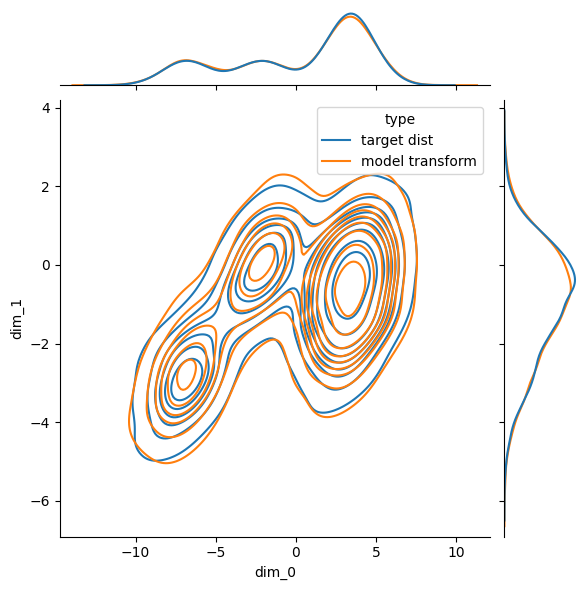

trail: 0 m step: 8 kl_test: 0.0013511180877685547


  2%|▏         | 100/6000 [00:27<30:47,  3.19it/s]

trail: 0 m step: 9 Loss: 0.0010404460157170817  L_n: 0.0007562637329101562  kld: 0.000301361083984375 KLD1: -2.2330330466502346e-05 KLD2: 0.0011421157978475094


  3%|▎         | 200/6000 [00:55<30:47,  3.14it/s]

trail: 0 m step: 9 Loss: 0.0010192553331391588  L_n: 0.0010037422180175781  kld: 1.6450881958007812e-05 KLD1: 0.0011740433983504772 KLD2: -4.545559932012111e-05


  5%|▌         | 300/6000 [01:23<30:15,  3.14it/s]

trail: 0 m step: 9 Loss: 0.0007481650694172107  L_n: 0.0005116462707519531  kld: 0.00025081634521484375 KLD1: 0.0008293650462292135 KLD2: 0.0011496057268232107


  7%|▋         | 400/6000 [01:51<30:01,  3.11it/s]

trail: 0 m step: 9 Loss: 0.001962871359794496  L_n: 0.0014181137084960938  kld: 0.0005776882171630859 KLD1: 0.001690951525233686 KLD2: 0.0011516259983181953


  8%|▊         | 500/6000 [02:19<26:06,  3.51it/s]

trail: 0 m step: 9 Loss: 0.0009465217590332031  L_n: 0.0009465217590332031  kld: 0.0 KLD1: 0.0003630825085565448 KLD2: 0.0016446090303361416


 10%|█         | 600/6000 [02:47<26:53,  3.35it/s]

trail: 0 m step: 9 Loss: 0.0006910497465448963  L_n: 0.0003418922424316406  kld: 0.00037026405334472656 KLD1: 0.00030743933166377246 KLD2: 0.0006064185872673988


 12%|█▏        | 700/6000 [03:15<28:22,  3.11it/s]

trail: 0 m step: 9 Loss: 0.0013727188898415381  L_n: 0.0007243156433105469  kld: 0.0006875991821289062 KLD1: 0.0010093528544530272 KLD2: 0.000354309770045802


 13%|█▎        | 800/6000 [03:43<23:43,  3.65it/s]

trail: 0 m step: 9 Loss: 0.0004374980926513672  L_n: 0.0004374980926513672  kld: 0.0 KLD1: 0.0011484851129353046 KLD2: 0.0009863977320492268


 15%|█▌        | 900/6000 [04:11<26:56,  3.15it/s]

trail: 0 m step: 9 Loss: 0.0009651348184175475  L_n: 0.0006222724914550781  kld: 0.0003635883331298828 KLD1: 0.0006223165546543896 KLD2: 0.0011546137975528836


 17%|█▋        | 1000/6000 [04:39<27:24,  3.04it/s]

trail: 0 m step: 9 Loss: 0.001196070529798789  L_n: 0.0005519390106201172  kld: 0.0006830692291259766 KLD1: -0.00016837551083881408 KLD2: 0.0009430940262973309


 18%|█▊        | 1100/6000 [05:07<26:20,  3.10it/s]

trail: 0 m step: 9 Loss: 0.0015734554410498805  L_n: 0.0010983943939208984  kld: 0.0005037784576416016 KLD1: 0.0010013040155172348 KLD2: 0.0009446667390875518


 20%|██        | 1201/6000 [05:36<20:17,  3.94it/s]

trail: 0 m step: 9 Loss: 0.000859289092678179  L_n: 0.0006191730499267578  kld: 0.00025463104248046875 KLD1: 0.00036455964436754584 KLD2: 0.0005204809131100774


 22%|██▏       | 1300/6000 [06:04<25:05,  3.12it/s]

trail: 0 m step: 9 Loss: 0.0008305656187770114  L_n: 0.0007581710815429688  kld: 7.677078247070312e-05 KLD1: 4.223341966280714e-05 KLD2: 0.0011113445507362485


 23%|██▎       | 1400/6000 [06:32<23:42,  3.23it/s]

trail: 0 m step: 9 Loss: 0.0012671735515386124  L_n: 0.0009946823120117188  kld: 0.00028896331787109375 KLD1: 0.001298189046792686 KLD2: 0.000424316298449412


 25%|██▌       | 1501/6000 [07:01<20:05,  3.73it/s]

trail: 0 m step: 9 Loss: 0.001634734382912503  L_n: 0.0010769367218017578  kld: 0.0005915164947509766 KLD1: 0.0007684258162043989 KLD2: 0.001227749278768897


 27%|██▋       | 1600/6000 [07:29<23:25,  3.13it/s]

trail: 0 m step: 9 Loss: 0.00031595527463348954  L_n: 6.437301635742188e-05  kld: 0.00026679039001464844 KLD1: 0.001074259402230382 KLD2: 0.0008591468795202672


 28%|██▊       | 1700/6000 [07:57<23:03,  3.11it/s]

trail: 0 m step: 9 Loss: 0.0011856965225978348  L_n: 0.0004448890686035156  kld: 0.0007855892181396484 KLD1: 0.000471069710329175 KLD2: 0.0012371456250548363


 30%|███       | 1800/6000 [08:25<21:23,  3.27it/s]

trail: 0 m step: 9 Loss: 0.0013947130513199605  L_n: 0.0010352134704589844  kld: 0.00038123130798339844 KLD1: 0.00026455341139808297 KLD2: 0.00024679492344148457


 32%|███▏      | 1900/6000 [08:53<21:01,  3.25it/s]

trail: 0 m step: 9 Loss: 0.0009319206965426082  L_n: 0.0008599758148193359  kld: 7.62939453125e-05 KLD1: 0.0006101604085415602 KLD2: 0.00048137077828869224


 33%|███▎      | 2000/6000 [09:22<21:13,  3.14it/s]

trail: 0 m step: 9 Loss: 0.0009455372752257258  L_n: 0.0003218650817871094  kld: 0.0006613731384277344 KLD1: 0.0010209401370957494 KLD2: 0.0006406347383745015


 35%|███▌      | 2100/6000 [09:49<20:29,  3.17it/s]

trail: 0 m step: 9 Loss: 0.0009051393211181934  L_n: 0.0007648468017578125  kld: 0.000148773193359375 KLD1: 0.0006569597171619534 KLD2: 0.00023396908363793045


 37%|███▋      | 2200/6000 [10:17<19:35,  3.23it/s]

trail: 0 m step: 9 Loss: 0.0006904009774841822  L_n: 0.0004448890686035156  kld: 0.00026035308837890625 KLD1: 0.0005644388147629797 KLD2: 0.0007931160507723689


 38%|███▊      | 2300/6000 [10:45<19:39,  3.14it/s]

trail: 0 m step: 9 Loss: 0.0009260693832619356  L_n: 0.0008993148803710938  kld: 2.8371810913085938e-05 KLD1: 0.0004122870450373739 KLD2: 0.0008939707768149674


 40%|████      | 2400/6000 [11:12<17:10,  3.49it/s]

trail: 0 m step: 9 Loss: 0.00011587142944335938  L_n: 0.00011587142944335938  kld: 0.0 KLD1: -0.00017495176871307194 KLD2: 0.0007751807570457458


 42%|████▏     | 2500/6000 [11:40<18:25,  3.16it/s]

trail: 0 m step: 9 Loss: 0.001842361250758476  L_n: 0.0012958049774169922  kld: 0.0005795955657958984 KLD1: 0.0002758910704869777 KLD2: 0.0005620145821012557


 43%|████▎     | 2601/6000 [12:08<13:51,  4.09it/s]

trail: 0 m step: 9 Loss: 0.0011699434433278537  L_n: 0.0009179115295410156  kld: 0.00026726722717285156 KLD1: 0.0006138827302493155 KLD2: 0.0005239201127551496


 45%|████▌     | 2700/6000 [12:36<17:37,  3.12it/s]

trail: 0 m step: 9 Loss: 0.0008721813799854932  L_n: 0.00041937828063964844  kld: 0.0004801750183105469 KLD1: 0.00042160062002949417 KLD2: 0.0005680684116668999


 47%|████▋     | 2801/6000 [13:04<14:19,  3.72it/s]

trail: 0 m step: 9 Loss: 0.0005599802230749708  L_n: 0.00035381317138671875  kld: 0.0002186298370361328 KLD1: 0.0008112017530947924 KLD2: 0.00046646909322589636


 48%|████▊     | 2901/6000 [13:31<13:34,  3.81it/s]

trail: 0 m step: 9 Loss: 0.0010189015097494297  L_n: 0.00044536590576171875  kld: 0.0006082057952880859 KLD1: 0.0009635918540880084 KLD2: 0.00029808853287249804


 50%|█████     | 3000/6000 [13:59<15:56,  3.14it/s]

trail: 0 m step: 9 Loss: 0.0005563342918413225  L_n: 0.00017547607421875  kld: 0.0004038810729980469 KLD1: 0.0011764661176130176 KLD2: 0.000431001273682341


 52%|█████▏    | 3100/6000 [14:28<14:54,  3.24it/s]

trail: 0 m step: 9 Loss: 0.0005121485911290457  L_n: 0.0003390312194824219  kld: 0.00018358230590820312 KLD1: 0.0009317566873505712 KLD2: -6.830477650510147e-05


 53%|█████▎    | 3200/6000 [14:56<14:03,  3.32it/s]

trail: 0 m step: 9 Loss: 0.001370537832685272  L_n: 0.0007767677307128906  kld: 0.0006296634674072266 KLD1: 0.0005659371963702142 KLD2: 0.0007928562117740512


 55%|█████▌    | 3300/6000 [15:24<13:51,  3.25it/s]

trail: 0 m step: 9 Loss: 0.001340861649175246  L_n: 0.0011396408081054688  kld: 0.00021338462829589844 KLD1: 8.45045069581829e-05 KLD2: 0.0006077495636418462


 57%|█████▋    | 3400/6000 [15:52<13:07,  3.30it/s]

trail: 0 m step: 9 Loss: 0.0005514846063035453  L_n: 0.00044536590576171875  kld: 0.0001125335693359375 KLD1: 0.0004640684346668422 KLD2: 0.0004735486872959882


 58%|█████▊    | 3501/6000 [16:20<11:07,  3.74it/s]

trail: 0 m step: 9 Loss: 0.000949603903766861  L_n: 0.0006968975067138672  kld: 0.00026798248291015625 KLD1: 0.0005931113846600056 KLD2: 0.00034897722071036696


 60%|██████    | 3600/6000 [16:48<12:18,  3.25it/s]

trail: 0 m step: 9 Loss: 0.0010795443460334753  L_n: 0.0008111000061035156  kld: 0.0002846717834472656 KLD1: 0.0007204226567409933 KLD2: 0.0006473910761997104


 62%|██████▏   | 3700/6000 [17:16<12:17,  3.12it/s]

trail: 0 m step: 9 Loss: 0.0011592424071434357  L_n: 0.0007183551788330078  kld: 0.00046753883361816406 KLD1: 4.84773627249524e-05 KLD2: 0.0002636065473780036


 63%|██████▎   | 3800/6000 [17:43<11:48,  3.11it/s]

trail: 0 m step: 9 Loss: 0.0009911405521825835  L_n: 0.00047898292541503906  kld: 0.0005431175231933594 KLD1: 0.0004395494470372796 KLD2: 0.0006751857581548393


 65%|██████▌   | 3900/6000 [18:11<11:05,  3.15it/s]

trail: 0 m step: 9 Loss: 0.0007735865132557202  L_n: 0.0004961490631103516  kld: 0.0002942085266113281 KLD1: 0.00027930751093663275 KLD2: 0.000720372365321964


 67%|██████▋   | 4000/6000 [18:39<10:13,  3.26it/s]

trail: 0 m step: 9 Loss: 0.0012878054274088986  L_n: 0.000701904296875  kld: 0.0006213188171386719 KLD1: 0.0002669058449100703 KLD2: 0.0004851307603530586


 68%|██████▊   | 4100/6000 [19:06<08:38,  3.67it/s]

trail: 0 m step: 9 Loss: 0.00014427092473832145  L_n: -0.00018262863159179688  kld: 0.0003466606140136719 KLD1: 0.0007558850338682532 KLD2: 0.0006644446402788162


 70%|███████   | 4200/6000 [19:34<09:30,  3.16it/s]

trail: 0 m step: 9 Loss: 0.0005984360787057504  L_n: 0.00014495849609375  kld: 0.00048089027404785156 KLD1: 0.0006251262384466827 KLD2: 0.0003036761190742254


 72%|███████▏  | 4300/6000 [20:01<08:42,  3.25it/s]

trail: 0 m step: 9 Loss: 0.0003796069344990903  L_n: 0.0002620220184326172  kld: 0.0001246929168701172 KLD1: 0.0008717862656340003 KLD2: 0.0006476703565567732


 73%|███████▎  | 4401/6000 [20:30<07:25,  3.59it/s]

trail: 0 m step: 9 Loss: 0.00061756574225056  L_n: 0.00047659873962402344  kld: 0.0001494884490966797 KLD1: 0.00012428182526491582 KLD2: 0.0007524178363382816


 75%|███████▌  | 4500/6000 [20:58<07:53,  3.17it/s]

trail: 0 m step: 9 Loss: 0.0004077477014089985  L_n: 0.00028634071350097656  kld: 0.00012874603271484375 KLD1: 0.0007117051864042878 KLD2: 0.0005009737215004861


 77%|███████▋  | 4600/6000 [21:25<07:26,  3.13it/s]

trail: 0 m step: 9 Loss: 0.0017976351610953878  L_n: 0.0011501312255859375  kld: 0.0006866455078125 KLD1: 0.0004831909900531173 KLD2: 0.0002947979955933988


 78%|███████▊  | 4700/6000 [21:53<06:56,  3.12it/s]

trail: 0 m step: 9 Loss: 0.0008848955565084724  L_n: 0.000827789306640625  kld: 6.0558319091796875e-05 KLD1: 0.00031788513297215104 KLD2: 0.0007067254628054798


 80%|████████  | 4801/6000 [22:22<05:26,  3.68it/s]

trail: 0 m step: 9 Loss: 0.0005724037033936936  L_n: 0.000469207763671875  kld: 0.00010943412780761719 KLD1: -0.00016244823927991092 KLD2: 0.00032725351047702134


 82%|████████▏ | 4900/6000 [22:49<05:52,  3.12it/s]

trail: 0 m step: 9 Loss: 0.00022850739362795903  L_n: 8.821487426757812e-05  kld: 0.000148773193359375 KLD1: 0.0005952790379524231 KLD2: 0.0006023993482813239


 83%|████████▎ | 5000/6000 [23:17<05:18,  3.14it/s]

trail: 0 m step: 9 Loss: 0.0010306044827906031  L_n: 0.0007808208465576172  kld: 0.00026488304138183594 KLD1: 0.0006570391706191003 KLD2: 0.0006201606593094766


 85%|████████▌ | 5100/6000 [23:44<04:43,  3.18it/s]

trail: 0 m step: 9 Loss: 0.0010480548694558273  L_n: 0.0008108615875244141  kld: 0.00025153160095214844 KLD1: 0.0005665896460413933 KLD2: 0.0009433650993742049


 87%|████████▋ | 5201/6000 [24:13<03:38,  3.65it/s]

trail: 0 m step: 9 Loss: 0.00048133981406534596  L_n: 0.0003428459167480469  kld: 0.0001468658447265625 KLD1: 0.0008216753485612571 KLD2: 0.0006910628289915621


 88%|████████▊ | 5300/6000 [24:41<03:27,  3.37it/s]

trail: 0 m step: 9 Loss: 0.0009955787662765852  L_n: 0.0008289813995361328  kld: 0.0001766681671142578 KLD1: 0.0007749090436846018 KLD2: 0.0006455399561673403


 90%|█████████ | 5400/6000 [25:09<03:12,  3.12it/s]

trail: 0 m step: 9 Loss: 0.0006883427778417749  L_n: 0.0006809234619140625  kld: 7.867813110351562e-06 KLD1: 0.000573987141251564 KLD2: 0.0006921355379745364


 92%|█████████▏| 5500/6000 [25:36<02:28,  3.37it/s]

trail: 0 m step: 9 Loss: 0.0008557292615720464  L_n: 0.0007815361022949219  kld: 7.867813110351562e-05 KLD1: 0.0009024292812682688 KLD2: 0.0005499710678122938


 93%|█████████▎| 5600/6000 [26:04<02:03,  3.24it/s]

trail: 0 m step: 9 Loss: 0.0008787480644967465  L_n: 0.000518798828125  kld: 0.00038170814514160156 KLD1: 0.0002490663027856499 KLD2: 0.0004737683048006147


 95%|█████████▌| 5700/6000 [26:32<01:36,  3.10it/s]

trail: 0 m step: 9 Loss: 0.0003294664454566551  L_n: 0.0002422332763671875  kld: 9.250640869140625e-05 KLD1: 0.0008371209842152894 KLD2: 0.001485640648752451


 97%|█████████▋| 5800/6000 [26:59<00:59,  3.34it/s]

trail: 0 m step: 9 Loss: 0.0005633658056223297  L_n: 0.00031065940856933594  kld: 0.00026798248291015625 KLD1: 0.0005878618685528636 KLD2: 0.0005976920947432518


 98%|█████████▊| 5900/6000 [27:27<00:29,  3.43it/s]

trail: 0 m step: 9 Loss: 0.0008815395503921164  L_n: 0.0004849433898925781  kld: 0.00042057037353515625 KLD1: 0.00030987506033852696 KLD2: 0.0006843496230430901


100%|██████████| 6000/6000 [27:55<00:00,  3.58it/s]

trail: 0 m step: 9 Loss: 0.0005929204428058727  L_n: 0.0004031658172607422  kld: 0.00020122528076171875 KLD1: 0.0004155424830969423 KLD2: 0.00029816004098393023



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


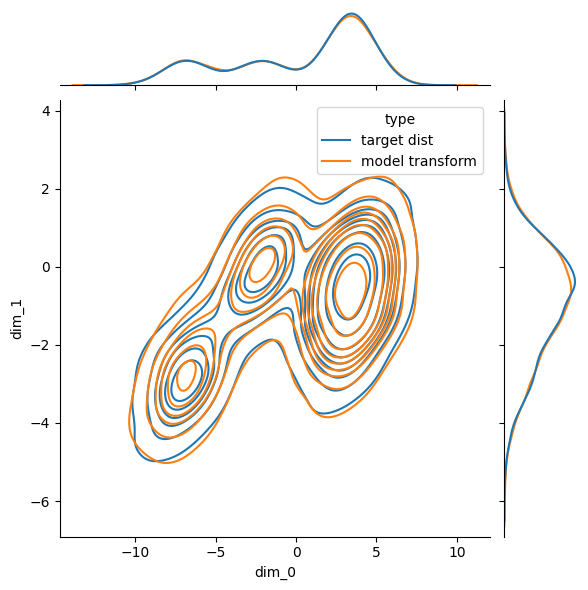

trail: 0 m step: 9 kl_test: 0.0008349418640136719


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = (eta*(1.3**mirror_itr))
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )

